# Sales Data Visualization and Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on sales data to understand relationships between various features and sales volume.

## Objectives:
- Analyze correlations between sales and various factors (weather, holidays, KielerWoche, etc.)
- Visualize relationships for different product groups
- Identify key drivers of sales performance

## 1. Import Libraries

We'll use pandas for data manipulation, matplotlib and seaborn for visualization, and scipy for statistical analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## 2. Load and Prepare Data

Load the cleaned dataset and convert the Date column to datetime format for proper time-based analysis.

In [2]:
df = pd.read_csv("data_prep\data_org.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the analysis period: 01-07-2017 to 31-07-2018
start_date = "2013-07-01"
end_date = "2018-07-31"
mask = (df["Date"] >= start_date) & (df["Date"] <= end_date)
df = df.loc[mask].copy()
print(f"\nFiltered data to period: {start_date} to {end_date}")
print(f"Number of rows in filtered dataset: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()


Filtered data to period: 2013-07-01 to 2018-07-31
Number of rows in filtered dataset: 9334
Date range: 2013-07-01 00:00:00 to 2018-07-31 00:00:00
Dataset shape: (9334, 17)

First few rows:


,id,Date,Product Group,Sales Volume,Cloud Cover,Temperature,Wind Speed,Weather Code,Temperature_H,Wind Speed_H,Cloud Cover_H,Precipitation_H,KielerWoche,Holiday Name (English),month,day_of_week,daily_total_sales
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,15.6,3.5,0.6875,0.3,0,NaN,7,0,1269.249107
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,15.6,3.5,0.6875,0.3,0,NaN,7,0,1269.249107
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,15.6,3.5,0.6875,0.3,0,NaN,7,0,1269.249107
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,15.6,3.5,0.6875,0.3,0,NaN,7,0,1269.249107
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,15.6,3.5,0.6875,0.3,0,NaN,7,0,1269.249107


## 3. Feature Engineering

Create a binary holiday indicator:
- `is_holiday = 1` if there's a holiday on that date
- `is_holiday = 0` if it's a regular day

This simplifies the holiday analysis by converting it to a yes/no question.

In [3]:
# Create binary holiday indicator (1 if holiday, 0 if not)
df["is_holiday"] = df["Holiday Name (English)"].notna().astype(int)

# ---- Daily tables (authoritative, used everywhere below) ----
# 1) Daily total sales across all product groups/items (your definition of "total daily sales")
df_daily = (
    df.groupby("Date", as_index=False)
      .agg(
          daily_total_sales=("Sales Volume", "sum"),
          is_holiday=("is_holiday", "max"),
          KielerWoche=("KielerWoche", "max"),
      )
)

# 2) Daily sales per item/product group (your definition of "daily sales per individual item")
#    (This is what you'll use for per-product ML later.)
df_item_daily = (
    df.groupby(["Date", "Product Group"], as_index=False)
      .agg(
          daily_sales=("Sales Volume", "sum"),
          is_holiday=("is_holiday", "max"),
          KielerWoche=("KielerWoche", "max"),
      )
)

# Closed day definition: total daily sales == 0
df_daily["is_closed"] = (df_daily["daily_total_sales"] == 0).astype(int)

# Calendar/helper columns derived from Date (avoid relying on precomputed columns)
df_daily["day_name"] = df_daily["Date"].dt.day_name()
df_daily["day_of_week"] = df_daily["Date"].dt.dayofweek
df_daily["month"] = df_daily["Date"].dt.month

df_item_daily = df_item_daily.merge(
    df_daily[["Date", "is_closed", "day_name", "day_of_week", "month"]],
    on="Date",
    how="left",
)

print(f"Number of holiday days (unique dates): {df_daily['is_holiday'].sum()}")
print(f"Closed days (total_daily_sales==0): {df_daily['is_closed'].sum()}")
print(f"Open days: {(df_daily['is_closed'] == 0).sum()}")

Number of holiday days (unique dates): 20
Closed days (total_daily_sales==0): 0
Open days: 1819


## 4. Select Features for Analysis

We'll analyze the following features:
- **Product Group**: Different categories of products sold
- **Sales Volume**: The target variable we want to understand
- **Weather features**: Cloud Cover, Temperature, Wind Speed, Weather Code (from 2 locations)
- **Special events**: KielerWoche (Kiel Week festival), holidays
- **Temporal features**: Month, day of week
- **Aggregated metric**: Daily total sales across all products

In [4]:
columns = df.columns.tolist()
print("All available columns:")
print(columns)

cols = [
    "Product Group",
    "Sales Volume",
    "Cloud Cover",
    "Temperature",
    "Wind Speed",
    "Weather Code",
    "Temperature_H",
    "Wind Speed_H",
    "Cloud Cover_H",
    "Precipitation_H",
    "KielerWoche",
    "is_holiday",
    "month",
    "day_of_week",
    "daily_total_sales",
]

print("\nSelected features for analysis:")
print(cols)

All available columns:
['id', 'Date', 'Product Group', 'Sales Volume', 'Cloud Cover', 'Temperature', 'Wind Speed', 'Weather Code', 'Temperature_H', 'Wind Speed_H', 'Cloud Cover_H', 'Precipitation_H', 'KielerWoche', 'Holiday Name (English)', 'month', 'day_of_week', 'daily_total_sales', 'is_holiday']

Selected features for analysis:
['Product Group', 'Sales Volume', 'Cloud Cover', 'Temperature', 'Wind Speed', 'Weather Code', 'Temperature_H', 'Wind Speed_H', 'Cloud Cover_H', 'Precipitation_H', 'KielerWoche', 'is_holiday', 'month', 'day_of_week', 'daily_total_sales']


## 5. Create Dummy Variables for Product Groups

Since "Product Group" is categorical, we convert it into binary dummy variables.
This allows us to:
- Calculate correlations between each product group and other features
- Understand which factors affect different product categories differently

In [5]:
df_enc = pd.get_dummies(df[cols], columns=["Product Group"])

print("Dataset shape after encoding:", df_enc.shape)
print("\nNew columns (Product Group dummies):")
product_cols = [col for col in df_enc.columns if col.startswith('Product Group')]
print(product_cols)

Dataset shape after encoding: (9334, 20)

New columns (Product Group dummies):
['Product Group_1', 'Product Group_2', 'Product Group_3', 'Product Group_4', 'Product Group_5', 'Product Group_6']


## 6. Correlation Matrix Analysis

The correlation matrix shows relationships between all variables:
- Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)
- 0 means no linear relationship
- This helps identify which features are most strongly related to sales

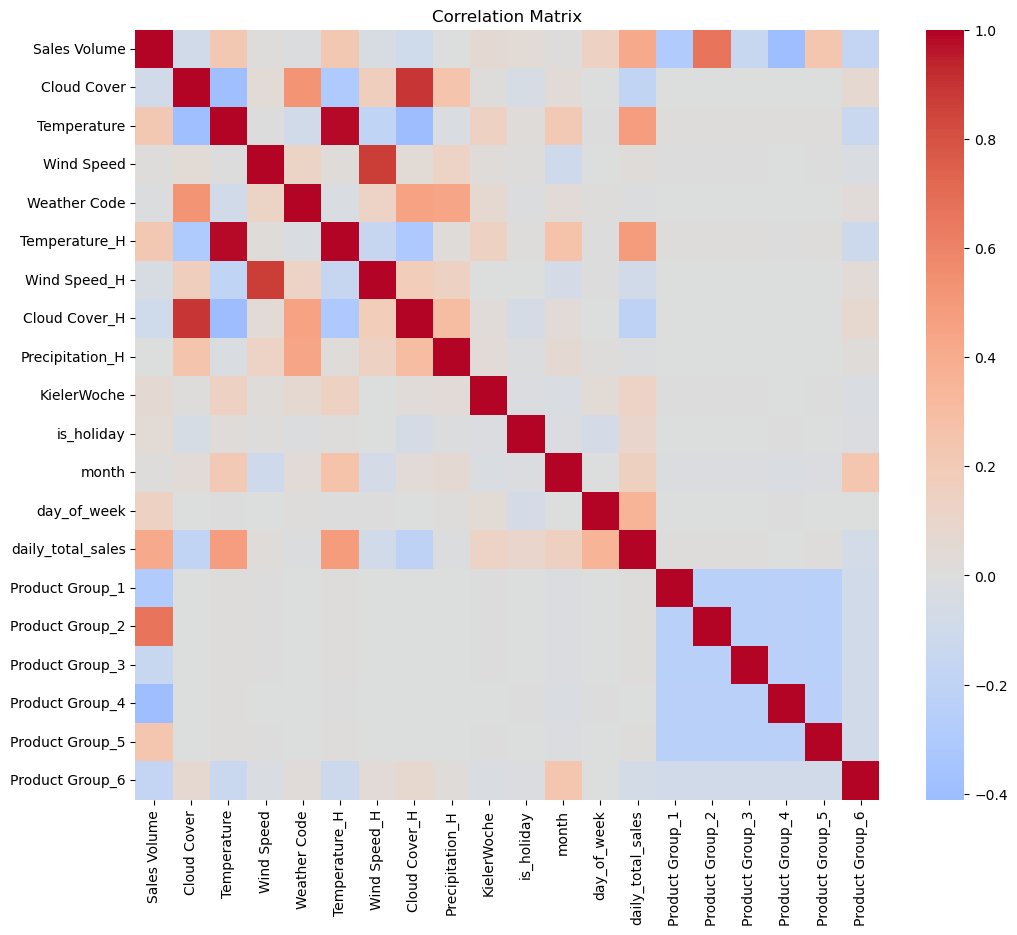

Correlation matrix saved to CSV


In [6]:
correlation_matrix = df_enc.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.savefig("figures\correlation_matrix_data_org.png")
plt.show()

# Save to CSV for detailed inspection
correlation_matrix.to_csv("data_prep\correlation_matrix_data_org.csv")
print("Correlation matrix saved to CSV")

### Display Key Correlations with Sales Volume

Let's examine which features have the strongest correlation with sales.

In [7]:
# Get correlations with Sales Volume, sorted by absolute value
sales_corr = correlation_matrix['Sales Volume'].sort_values(ascending=False)
print("Correlations with Sales Volume (sorted by strength):")
print(sales_corr)

Correlations with Sales Volume (sorted by strength):
Sales Volume         1.000000
Product Group_2      0.666301
daily_total_sales    0.419743
Product Group_5      0.238428
Temperature          0.222653
Temperature_H        0.222427
day_of_week          0.136199
KielerWoche          0.058244
is_holiday           0.043574
Wind Speed           0.014767
month                0.013889
Precipitation_H     -0.007293
Weather Code        -0.010091
Wind Speed_H        -0.041370
Cloud Cover         -0.089822
Cloud Cover_H       -0.100427
Product Group_3     -0.147755
Product Group_6     -0.173855
Product Group_1     -0.287989
Product Group_4     -0.397029
Name: Sales Volume, dtype: float64


## 7. Correlation Matrix as Table

Displaying the correlation values in a table format for easier reading.

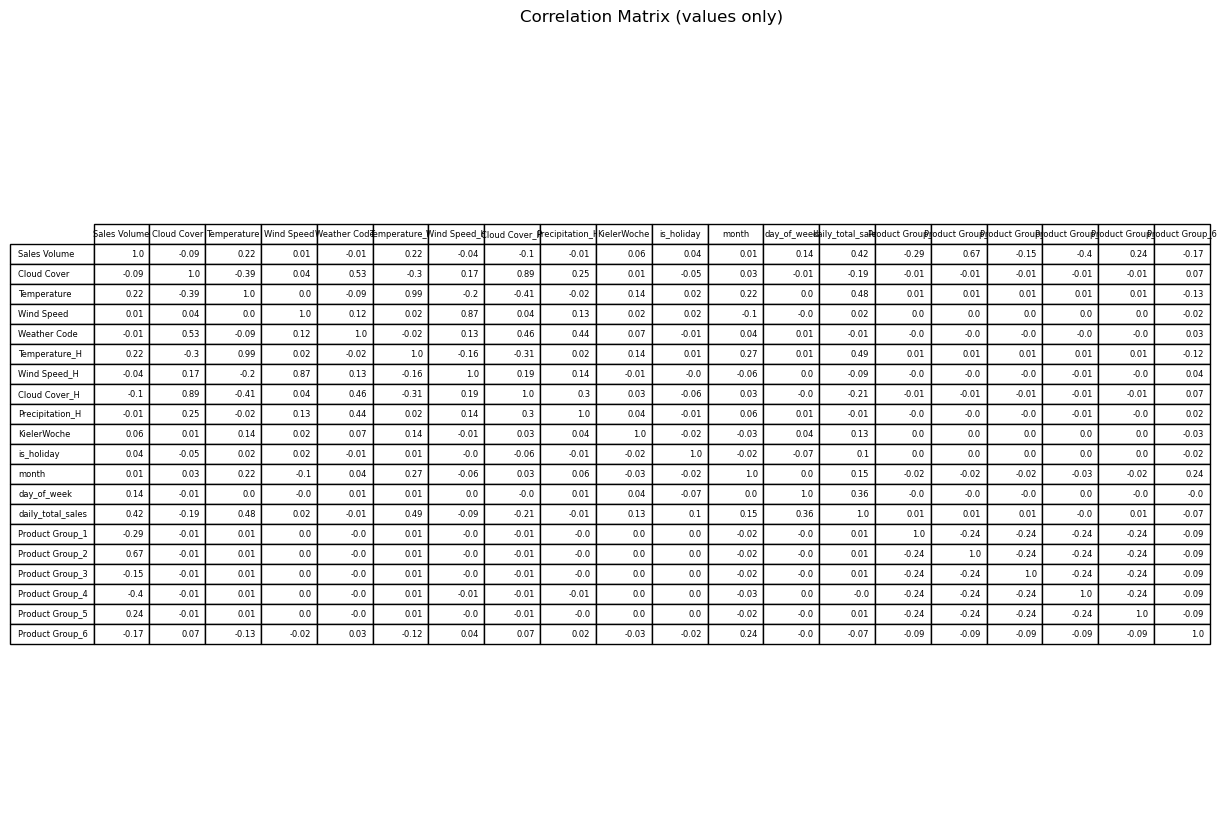

In [8]:
correlation_matrix_rounded = correlation_matrix.round(2)
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")

table = ax.table(
    cellText=correlation_matrix_rounded.values,
    rowLabels=correlation_matrix_rounded.index,
    colLabels=correlation_matrix_rounded.columns,
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.2, 1.2)

plt.title("Correlation Matrix (values only)", pad=20)
plt.show()

## 8. Temperature vs Sales Analysis

Temperature is often a key factor in retail sales. We'll compare temperature data from two weather stations:
- **Temperature**: Main weather station
- **Temperature_H**: Holtenau weather station

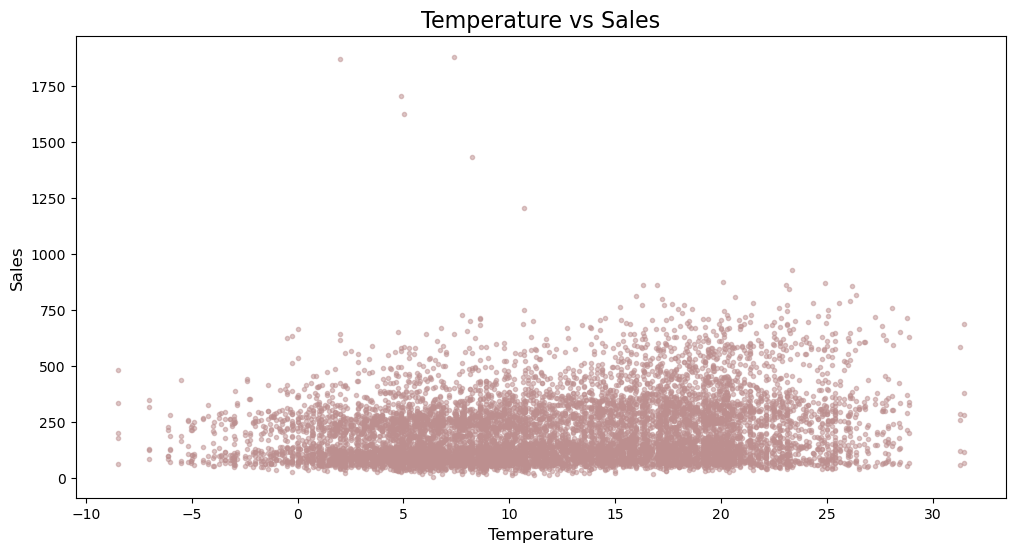

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_enc["Temperature"],
    df_enc["Sales Volume"],
    color="RosyBrown",
    alpha=0.5,
    marker=".",
)
plt.title("Temperature vs Sales", fontsize=16)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.show()

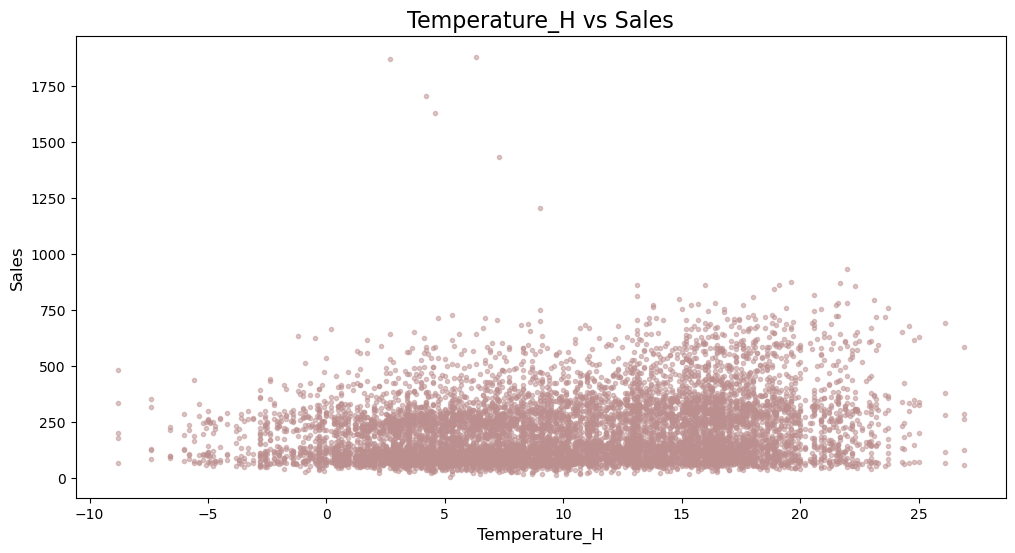

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_enc["Temperature_H"],
    df_enc["Sales Volume"],
    color="RosyBrown",
    alpha=0.5,
    marker=".",
)
plt.title("Temperature_H vs Sales", fontsize=16)
plt.xlabel("Temperature_H", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.show()

### Side-by-Side Comparison of Temperature Data

Comparing both temperature measurements in a single figure for easier visual comparison.

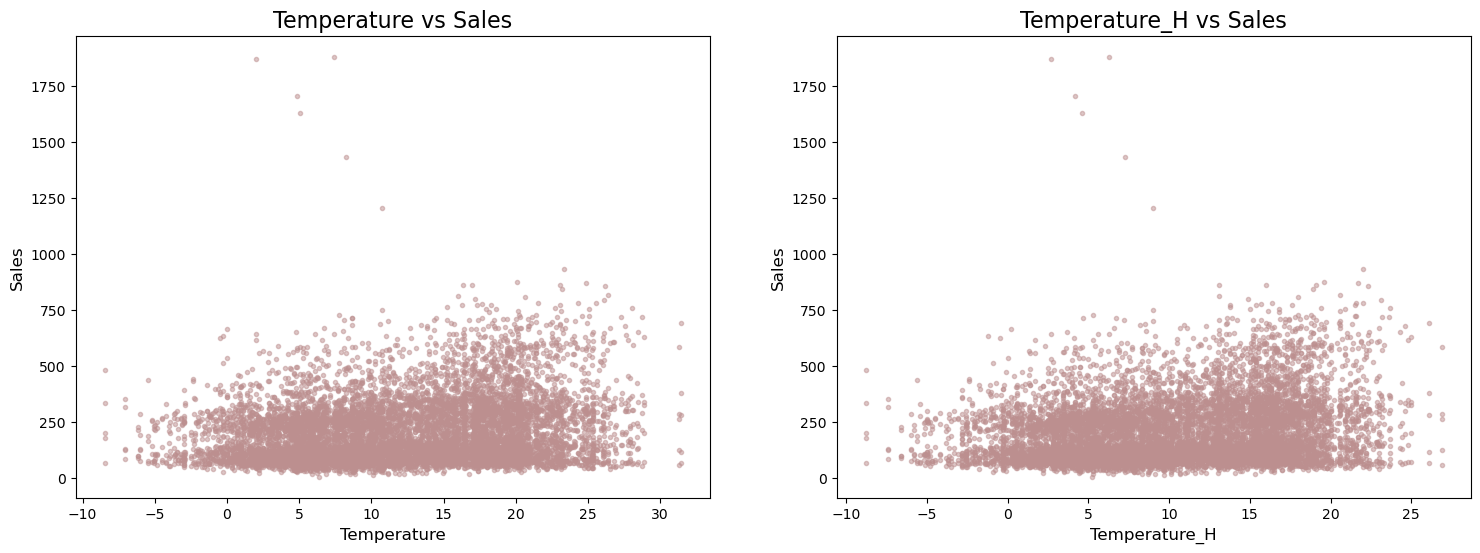

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].scatter(
    df_enc["Temperature"],
    df_enc["Sales Volume"],
    color="RosyBrown",
    alpha=0.5,
    marker=".",
)
axs[0].set_title("Temperature vs Sales", fontsize=16)
axs[0].set_xlabel("Temperature", fontsize=12)
axs[0].set_ylabel("Sales", fontsize=12)

axs[1].scatter(
    df_enc["Temperature_H"],
    df_enc["Sales Volume"],
    color="RosyBrown",
    alpha=0.5,
    marker=".",
)
axs[1].set_title("Temperature_H vs Sales", fontsize=16)
axs[1].set_xlabel("Temperature_H", fontsize=12)
axs[1].set_ylabel("Sales", fontsize=12)

fig.savefig(
    "figures/temperature_vs_sales_scatter_plots_data_org.png"
)
plt.show()

## 9. Multi-Parameter Scatter Plot Analysis

We'll create a comprehensive grid of scatter plots showing the relationship between Sales Volume and multiple features:
- Weather parameters from both stations
- KielerWoche festival indicator
- Holiday indicator

This helps identify which factors have the clearest visual relationships with sales.

In [12]:
def plot_scatter(ax, x, y, x_label, y_label, title):
    """Helper function to create consistent scatter plots"""
    ax.scatter(x, y, alpha=0.5, marker=".")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

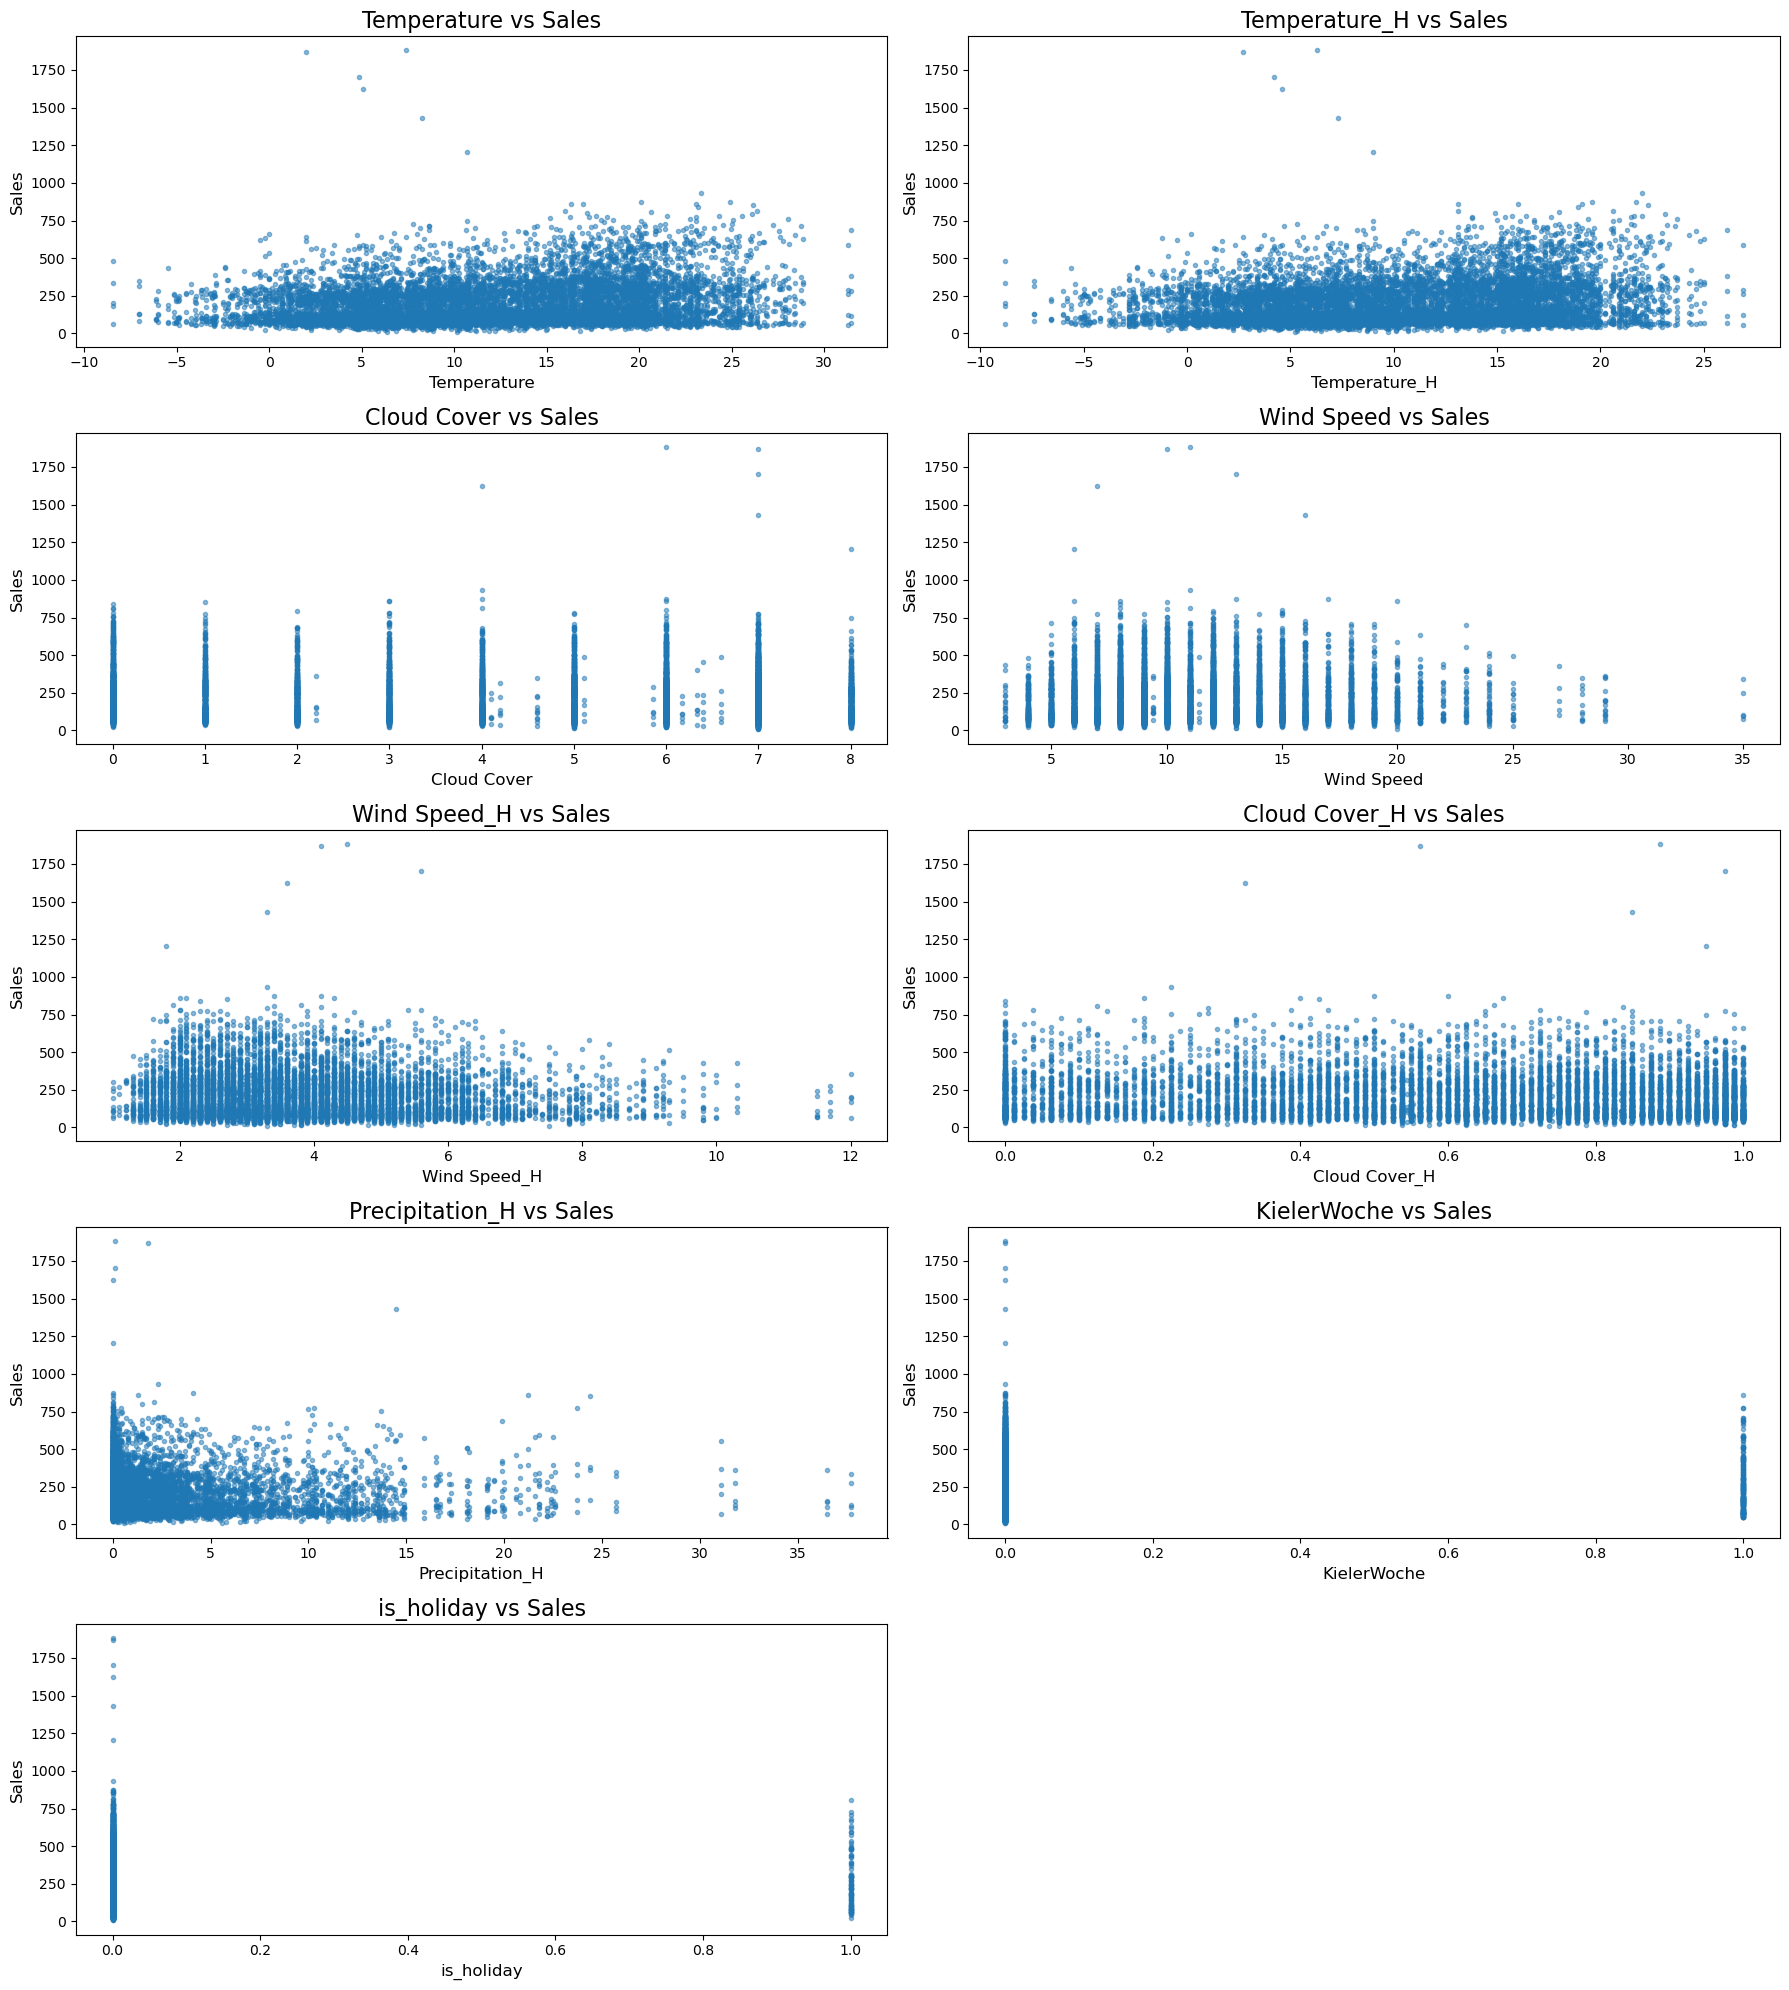

In [13]:
params = [
    "Temperature",
    "Temperature_H",
    "Cloud Cover",
    "Wind Speed",
    "Wind Speed_H",
    "Cloud Cover_H",
    "Precipitation_H",
    "KielerWoche",
    "is_holiday",
]

n = len(params)
cols = 2
rows = (n + cols - 1) // cols  # ceil division

fig, axs = plt.subplots(rows, cols, figsize=(cols * 9, rows * 4))
axs = axs.flatten()  # so we can index 0..n-1 easily

for i, param in enumerate(params):
    plot_scatter(
        axs[i],
        df_enc[param],
        df_enc["Sales Volume"],
        param,
        "Sales",
        f"{param} vs Sales",
    )

# hide any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.savefig(
    "figures\weather_sales_scatter_plots_data_org.png"
)
plt.show()

Box Plots for sales on holydays vs non holidays

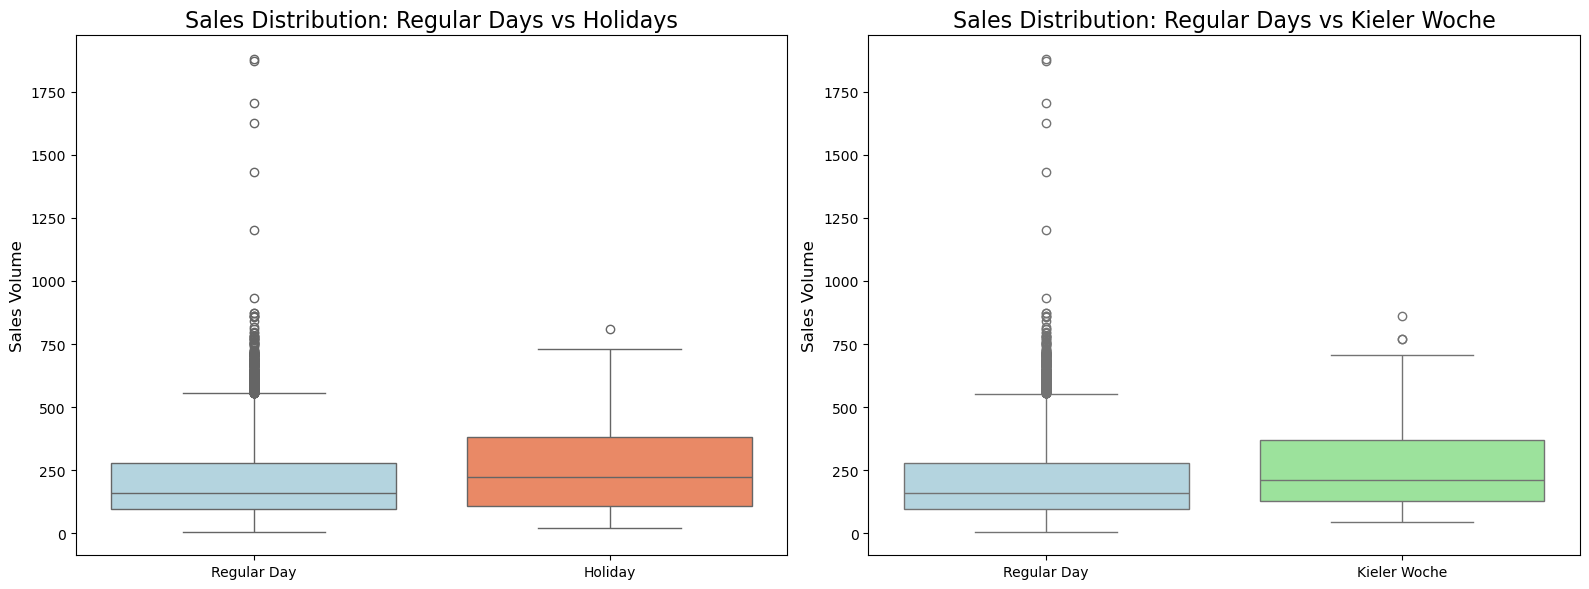

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create labeled versions of the binary columns
df['Holiday_Status'] = df['is_holiday'].map({0: 'Regular Day', 1: 'Holiday'})
df['Kiwo_Status'] = df['KielerWoche'].map({0: 'Regular Day', 1: 'Kieler Woche'})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Holiday impact (use palette when specifying multiple colors)
sns.boxplot(
	data=df,
	x='Holiday_Status',
	y='Sales Volume',
	ax=axes[0],
	order=['Regular Day', 'Holiday'],
    hue="Holiday_Status",
	palette=['lightblue', 'coral'],
)
axes[0].set_title('Sales Distribution: Regular Days vs Holidays', fontsize=16)
axes[0].set_ylabel('Sales Volume', fontsize=12)
axes[0].set_xlabel('')

# KielerWoche impact
sns.boxplot(
	data=df,
	x='Kiwo_Status',
	y='Sales Volume',
	ax=axes[1],
	order=['Regular Day', 'Kieler Woche'],
    hue="Kiwo_Status",
	palette=['lightblue', 'lightgreen'],
)
axes[1].set_title('Sales Distribution: Regular Days vs Kieler Woche', fontsize=16)
axes[1].set_ylabel('Sales Volume', fontsize=12)
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/holiday_kiwo_impact_boxplots.png')
plt.show()


 Bar Chart with Error Bars (Shows Average + Variance)

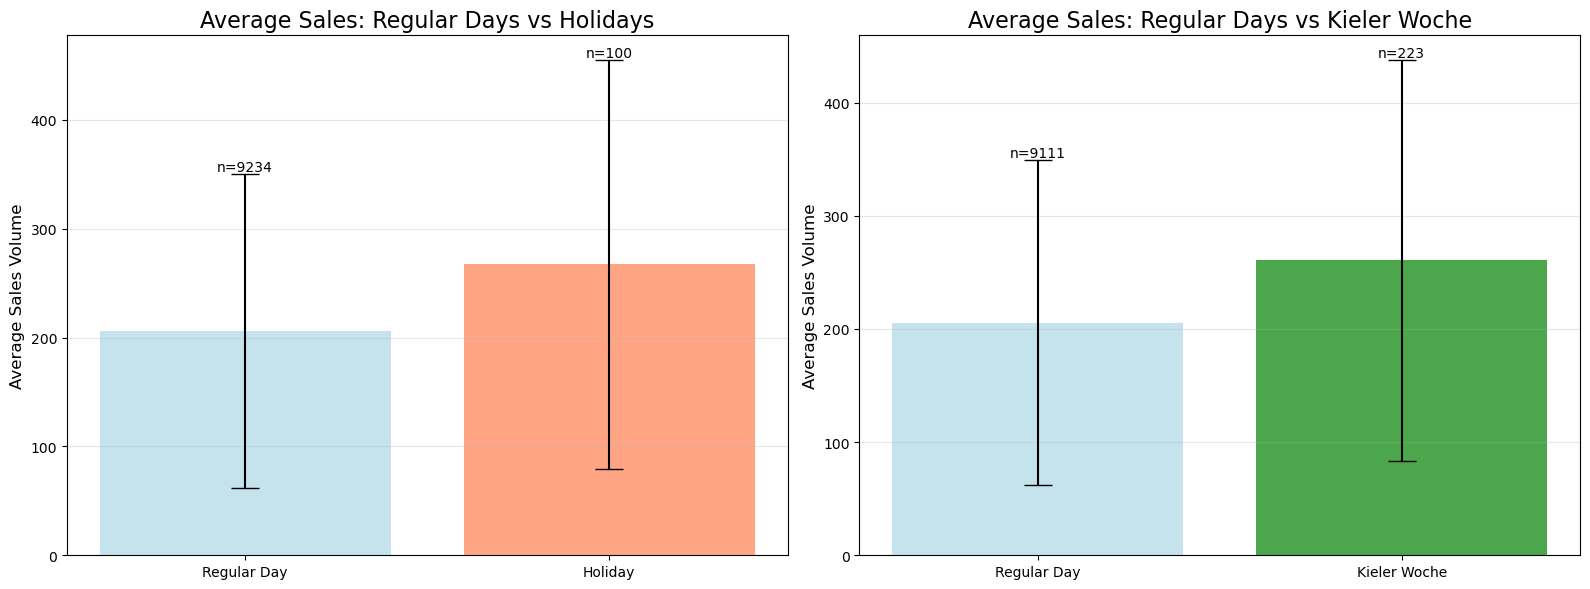

Holiday Impact Statistics:
                  mean         std  count
is_holiday                               
0           206.093639  143.882138   9234
1           267.269150  187.617513    100

Percentage change: 29.68%

Kieler Woche Impact Statistics:
                   mean         std  count
KielerWoche                               
0            205.431992  143.417422   9111
1            260.559219  177.014984    223

Percentage change: 26.83%


In [15]:
# Calculate statistics
holiday_stats = df.groupby('is_holiday')['Sales Volume'].agg(['mean', 'std', 'count'])
kiwo_stats = df.groupby('KielerWoche')['Sales Volume'].agg(['mean', 'std', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Holiday comparison
axes[0].bar(['Regular Day', 'Holiday'], holiday_stats['mean'], 
            yerr=holiday_stats['std'], capsize=10, color=['lightblue', 'coral'], alpha=0.7)
axes[0].set_title('Average Sales: Regular Days vs Holidays', fontsize=16)
axes[0].set_ylabel('Average Sales Volume', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add count annotations
for i, (idx, row) in enumerate(holiday_stats.iterrows()):
    axes[0].text(i, row['mean'] + row['std'], f"n={int(row['count'])}", 
                ha='center', va='bottom', fontsize=10)

# KielerWoche comparison
axes[1].bar(['Regular Day', 'Kieler Woche'], kiwo_stats['mean'], 
            yerr=kiwo_stats['std'], capsize=10, color=['lightblue', 'green'], alpha=0.7)
axes[1].set_title('Average Sales: Regular Days vs Kieler Woche', fontsize=16)
axes[1].set_ylabel('Average Sales Volume', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add count annotations
for i, (idx, row) in enumerate(kiwo_stats.iterrows()):
    axes[1].text(i, row['mean'] + row['std'], f"n={int(row['count'])}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('figures/holiday_kiwo_average_comparison.png')
plt.show()

# Print statistics
print("Holiday Impact Statistics:")
print(holiday_stats)
print(f"\nPercentage change: {((holiday_stats.loc[1, 'mean'] - holiday_stats.loc[0, 'mean']) / holiday_stats.loc[0, 'mean'] * 100):.2f}%")

print("\nKieler Woche Impact Statistics:")
print(kiwo_stats)
print(f"\nPercentage change: {((kiwo_stats.loc[1, 'mean'] - kiwo_stats.loc[0, 'mean']) / kiwo_stats.loc[0, 'mean'] * 100):.2f}%")

Time Series with Highlights (Shows Temporal Pattern)

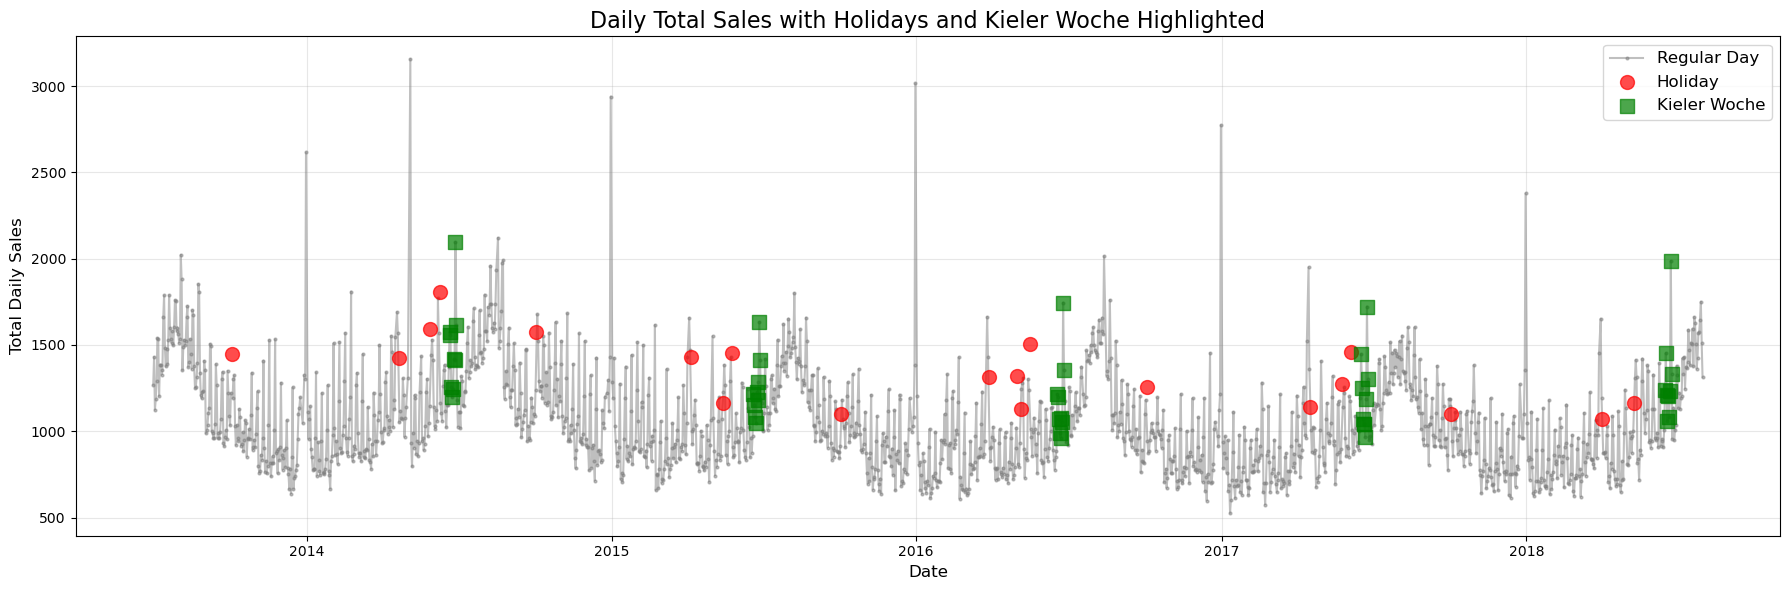

In [16]:
# Aggregate daily sales
daily_sales = df.groupby('Date').agg({
    'Sales Volume': 'sum',
    'is_holiday': 'max',
    'KielerWoche': 'max'
}).reset_index()

fig, ax = plt.subplots(figsize=(18, 6))

# Plot regular days
regular = daily_sales[daily_sales['is_holiday'] == 0]
ax.plot(regular['Date'], regular['Sales Volume'], 'o-', color='gray', alpha=0.5, label='Regular Day', markersize=2)

# Highlight holidays
holidays_data = daily_sales[daily_sales['is_holiday'] == 1]
ax.scatter(holidays_data['Date'], holidays_data['Sales Volume'], color='red', s=100, label='Holiday', zorder=5, alpha=0.7)

# Highlight KielerWoche
kiwo_data = daily_sales[daily_sales['KielerWoche'] == 1]
ax.scatter(kiwo_data['Date'], kiwo_data['Sales Volume'], color='green', s=100, label='Kieler Woche', zorder=5, marker='s', alpha=0.7)

ax.set_title('Daily Total Sales with Holidays and Kieler Woche Highlighted', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Daily Sales', fontsize=12)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/sales_timeline_with_events.png')
plt.show()


 By Product Group (Most Detailed)

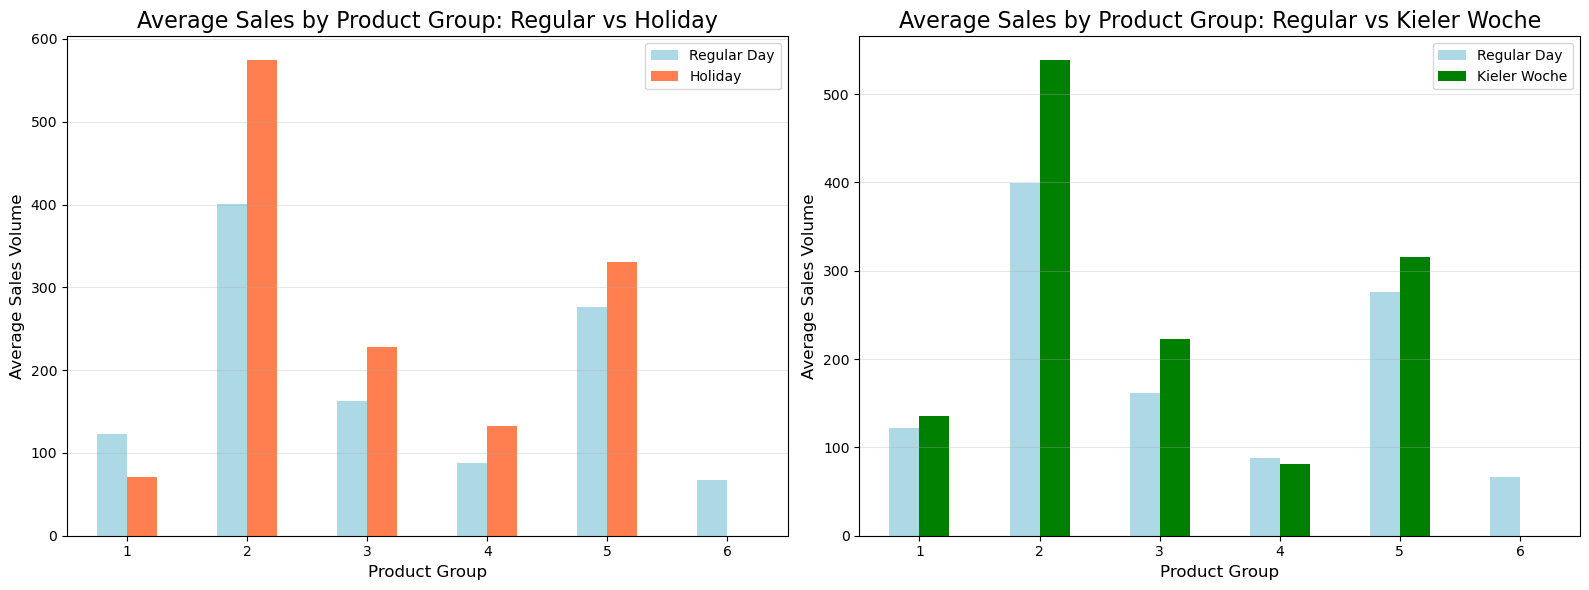

In [17]:
# Create subset for easier visualization
product_holiday = df.groupby(['Product Group', 'is_holiday'])['Sales Volume'].mean().unstack()
product_kiwo = df.groupby(['Product Group', 'KielerWoche'])['Sales Volume'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Holiday impact by product group
product_holiday.plot(kind='bar', ax=axes[0], color=['lightblue', 'coral'])
axes[0].set_title('Average Sales by Product Group: Regular vs Holiday', fontsize=16)
axes[0].set_xlabel('Product Group', fontsize=12)
axes[0].set_ylabel('Average Sales Volume', fontsize=12)
axes[0].legend(['Regular Day', 'Holiday'], fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# KielerWoche impact by product group
product_kiwo.plot(kind='bar', ax=axes[1], color=['lightblue', 'green'])
axes[1].set_title('Average Sales by Product Group: Regular vs Kieler Woche', fontsize=16)
axes[1].set_xlabel('Product Group', fontsize=12)
axes[1].set_ylabel('Average Sales Volume', fontsize=12)
axes[1].legend(['Regular Day', 'Kieler Woche'], fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('figures/holiday_kiwo_by_product_group.png')
plt.show()


## 10. Day of Week Analysis

Understanding weekly patterns in sales:
- Do weekends have higher/lower sales?
- Are there specific weekdays with consistently different performance?

We'll convert numeric day codes (0-6) to readable day names for better interpretation.

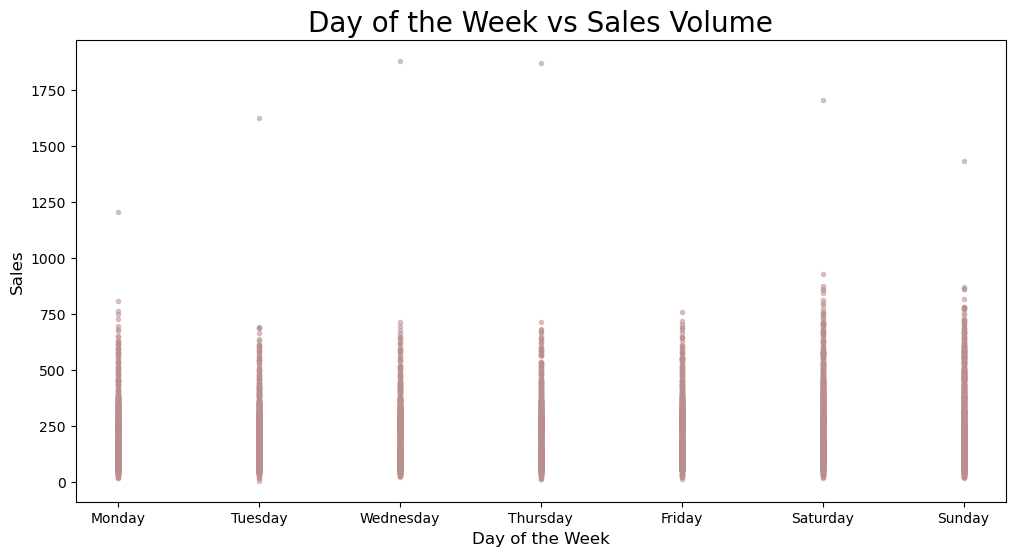

In [18]:
dow_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

df["day_of_week_name"] = df["day_of_week"].map(dow_map)
df_enc["day_of_week_name"] = df["day_of_week_name"]

plt.figure(figsize=(12, 6))
plt.scatter(
    df_enc["day_of_week_name"],
    df_enc["Sales Volume"],
    color="RosyBrown",
    alpha=0.5,
    marker=".",
)
plt.title("Day of the Week vs Sales Volume", fontsize=20)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.savefig(
    "figures/day_of_week_vs_sales_scatter_plot_data_org.png"
)
plt.show()

### Average Sales by Day of Week

Let's calculate the average sales for each day to see the pattern more clearly.

Average Sales by Day of Week:
day_of_week_name
Monday       193.688449
Tuesday      187.944440
Wednesday    187.477523
Thursday     193.232274
Friday       196.796023
Saturday     241.319882
Sunday       246.495651
Name: Sales Volume, dtype: float64


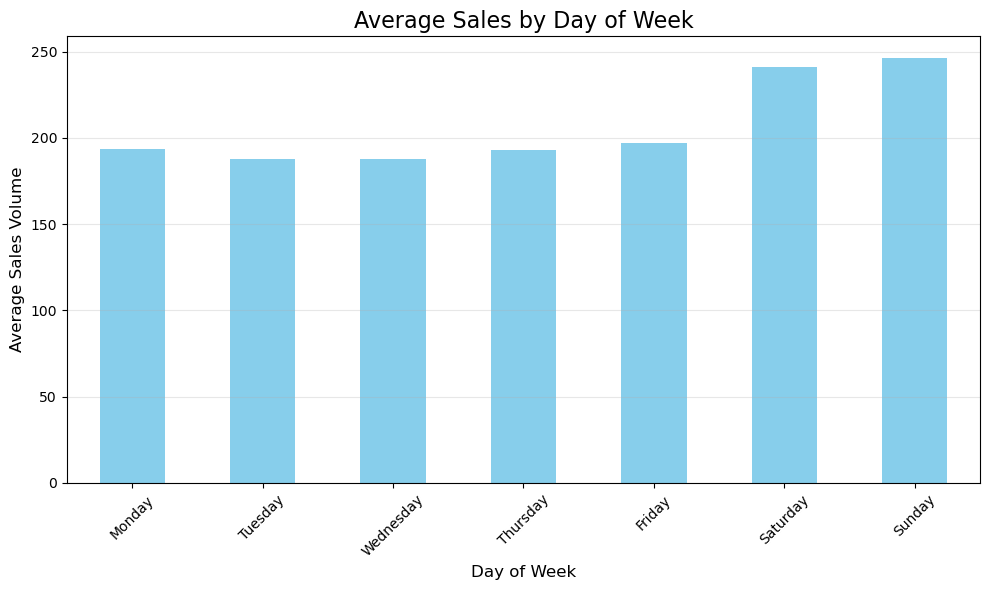

In [19]:
avg_sales_by_dow = df.groupby('day_of_week_name')['Sales Volume'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

print("Average Sales by Day of Week:")
print(avg_sales_by_dow)

plt.figure(figsize=(10, 6))
avg_sales_by_dow.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Sales Volume', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Key Insights

From this analysis, we can now:
1. Identify which features are most correlated with sales
2. Understand how different product groups respond to various factors
3. See visual patterns in the relationship between weather and sales
4. Observe the impact of special events (holidays, KielerWoche) on sales
5. Recognize weekly patterns in sales performance

These insights can guide:
- Feature selection for predictive modeling
- Business decisions about inventory and staffing
- Marketing strategies around holidays and weather patterns

 Detect Outliers 

In [20]:
# --- DAILY-level sanity checks ---
# df_daily is defined earlier (aggregation across all product groups).
# df_item_daily is defined earlier (aggregation per product group/item).

# Confirm "closed days" are based on TOTAL daily sales across ALL items
print(f"Total days: {len(df_daily)}")
print(f"Closed days (total daily sales == 0): {df_daily['is_closed'].sum()}")
print(f"Open days: {(df_daily['is_closed'] == 0).sum()}")

# For outlier stats and thresholds, we will always use OPEN days only.
df_open = df_daily[df_daily["is_closed"] == 0].copy()

print(f"Daily sales range (OPEN days): {df_open['daily_total_sales'].min():.2f} to {df_open['daily_total_sales'].max():.2f}")
print(f"Mean daily sales (OPEN days): {df_open['daily_total_sales'].mean():.2f}")
print(f"Median daily sales (OPEN days): {df_open['daily_total_sales'].median():.2f}")

Total days: 1819
Closed days (total daily sales == 0): 0
Open days: 1819
Daily sales range (OPEN days): 525.97 to 3156.41
Mean daily sales (OPEN days): 1060.91
Median daily sales (OPEN days): 1001.42


IQR (Interquartile Range) Method (more robust)

In [21]:
# --- IQR (Interquartile Range) Method (robust) ---
Q1 = df_open["daily_total_sales"].quantile(0.25)
Q3 = df_open["daily_total_sales"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Flag outliers on df_open, then merge back to df_daily
df_open["outlier_iqr"] = ((df_open["daily_total_sales"] < lower) | (df_open["daily_total_sales"] > upper)).astype(int)
df_daily = df_daily.merge(df_open[["Date", "outlier_iqr"]], on="Date", how="left")
df_daily["outlier_iqr"] = df_daily["outlier_iqr"].fillna(0).astype(int)

print(f"IQR bounds (OPEN days): lower={lower:.2f}, upper={upper:.2f}")
print(f"Outliers by IQR (OPEN days): {df_daily['outlier_iqr'].sum()}")

IQR bounds (OPEN days): lower=287.50, upper=1789.65
Outliers by IQR (OPEN days): 23


 Z-Score Method (distribution sensitive)

In [22]:
# --- Z-Score Method (distribution sensitive) ---
# Z-score is computed ONLY on OPEN days.
import scipy.stats as stats  # ensure available even if earlier imports were skipped

df_open["z_score"] = stats.zscore(df_open["daily_total_sales"])
df_open["outlier_z"] = (df_open["z_score"].abs() > 3).astype(int)

df_daily = df_daily.merge(df_open[["Date", "z_score", "outlier_z"]], on="Date", how="left")
df_daily["outlier_z"] = df_daily["outlier_z"].fillna(0).astype(int)

# Convenience table(s) promised by the notebook markdown
# Default outlier definition = IQR flag (swap to outlier_z if you prefer).
outliers_df = df_daily[(df_daily["is_closed"] == 0) & (df_daily["outlier_iqr"] == 1)].copy()

# Alias (some cells/markdown may refer to the singular name)
outlier_df = outliers_df

print(f"Outliers by Z-score (OPEN days): {df_daily['outlier_z'].sum()}")
print(f"Outliers table created: outliers_df with {len(outliers_df)} rows")

Outliers by Z-score (OPEN days): 16
Outliers table created: outliers_df with 23 rows


 Visualize Outliers

In [23]:
# --- Visualize Outliers / Special days (daily-level) ---
# df_daily contains:
#   daily_total_sales, is_closed, is_holiday, KielerWoche, outlier_iqr, outlier_z

# Sanity check: outlier thresholds ignored CLOSED days
assert (df_daily.loc[df_daily["is_closed"] == 1, "outlier_iqr"].sum() == 0), "Closed days should not be flagged as outliers (IQR)."
assert (df_daily.loc[df_daily["is_closed"] == 1, "outlier_z"].sum() == 0), "Closed days should not be flagged as outliers (Z-score)."

# Ensure outliers_df exists even if the Z-score cell hasn't been run yet
if "outliers_df" not in globals():
    outliers_df = df_daily[(df_daily["is_closed"] == 0) & (df_daily["outlier_iqr"] == 1)].copy()
    outlier_df = outliers_df  # alias

# List of outlier dates (IQR)
outlier_dates = outliers_df["Date"].sort_values().dt.date.tolist()
print("Outlier dates (IQR, OPEN days):")
print(outlier_dates[:50], "..." if len(outlier_dates) > 50 else "")

Outlier dates (IQR, OPEN days):
[datetime.date(2013, 8, 3), datetime.date(2013, 8, 4), datetime.date(2013, 8, 24), datetime.date(2013, 8, 25), datetime.date(2013, 12, 31), datetime.date(2014, 2, 23), datetime.date(2014, 5, 5), datetime.date(2014, 6, 9), datetime.date(2014, 6, 28), datetime.date(2014, 8, 2), datetime.date(2014, 8, 9), datetime.date(2014, 8, 16), datetime.date(2014, 8, 18), datetime.date(2014, 8, 23), datetime.date(2014, 8, 24), datetime.date(2014, 12, 31), datetime.date(2015, 8, 8), datetime.date(2015, 12, 31), datetime.date(2016, 8, 13), datetime.date(2016, 12, 31), datetime.date(2017, 4, 15), datetime.date(2017, 12, 31), datetime.date(2018, 6, 23)] 


Analyze Patterns in Outliers

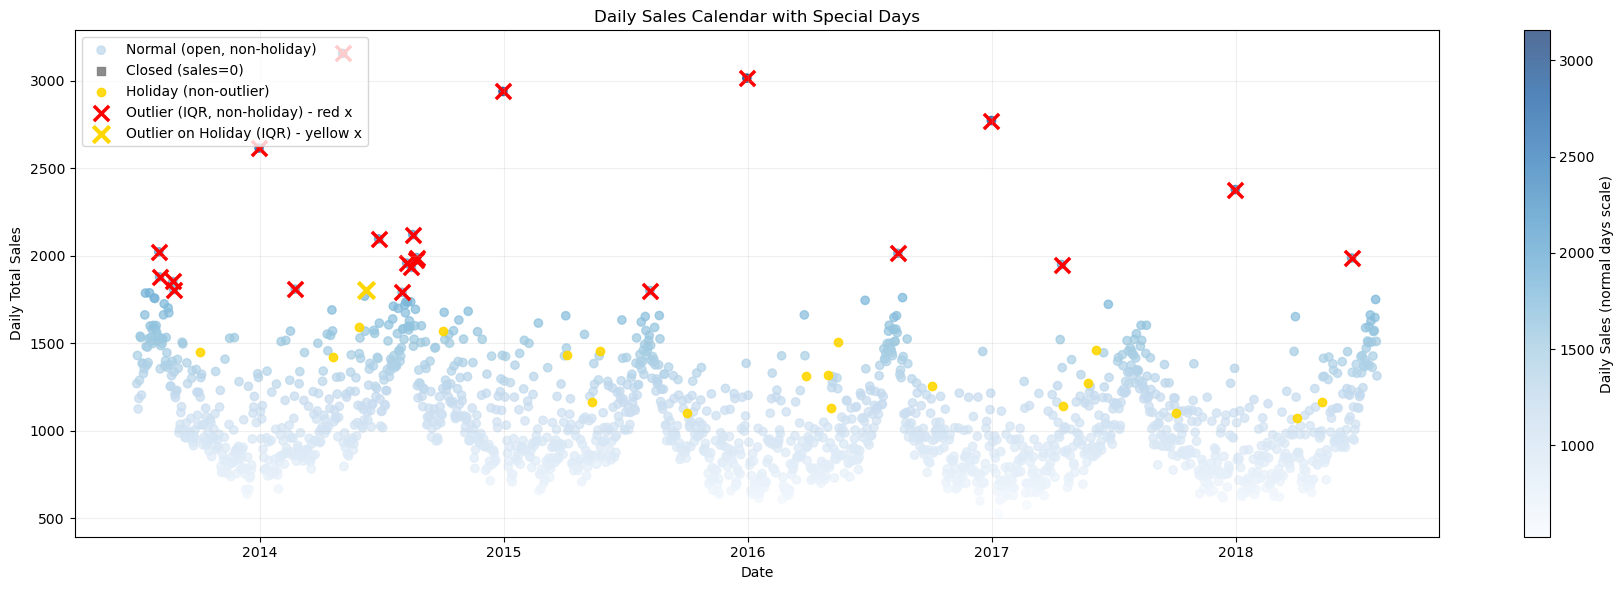

In [24]:
# --- Daily Sales Calendar with Special Days ---
fig, ax = plt.subplots(figsize=(18, 6))

# Base layer: NORMAL open, non-holiday days as a sales-colored scatter
normal = df_daily[(df_daily["is_closed"] == 0) & (df_daily["is_holiday"] == 0)]
sc = ax.scatter(
    normal["Date"],
    normal["daily_total_sales"],
    c=normal["daily_total_sales"],
    cmap="Blues",
    alpha=0.7,
    marker="o",
    label="Normal (open, non-holiday)",
)

# Closed days: gray
closed = df_daily[df_daily["is_closed"] == 1]
ax.scatter(
    closed["Date"],
    closed["daily_total_sales"],
    color="gray",
    alpha=0.9,
    marker="s",
    label="Closed (sales=0)",
)

# Holidays (that are NOT outliers): yellow circles
holidays_non_outlier = df_daily[
    (df_daily["is_holiday"] == 1) &
    (df_daily["is_closed"] == 0) &
    (df_daily["outlier_iqr"] == 0)
]
ax.scatter(
    holidays_non_outlier["Date"],
    holidays_non_outlier["daily_total_sales"],
    color="gold",
    alpha=0.9,
    marker="o",
    label="Holiday (non-outlier)",
)

# Outliers on NON-holidays: red cross (x)
outliers_non_holiday = df_daily[
    (df_daily["is_closed"] == 0) &
    (df_daily["outlier_iqr"] == 1) &
    (df_daily["is_holiday"] == 0)
]
ax.scatter(
    outliers_non_holiday["Date"],
    outliers_non_holiday["daily_total_sales"],
    color="red",
    marker="x",
    s=120,
    linewidths=2.5,
    label="Outlier (IQR, non-holiday) - red x",
)

# Outliers on HOLIDAYS: yellow cross (x)  ✅ as requested
outliers_on_holiday = df_daily[
    (df_daily["is_closed"] == 0) &
    (df_daily["outlier_iqr"] == 1) &
    (df_daily["is_holiday"] == 1)
]
ax.scatter(
    outliers_on_holiday["Date"],
    outliers_on_holiday["daily_total_sales"],
    color="gold",
    marker="x",
    s=140,
    linewidths=3,
    label="Outlier on Holiday (IQR) - yellow x",
)

ax.set_title("Daily Sales Calendar with Special Days")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Total Sales")
ax.grid(True, alpha=0.2)
fig.colorbar(sc, ax=ax, label="Daily Sales (normal days scale)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

Visualize Outlier Patterns

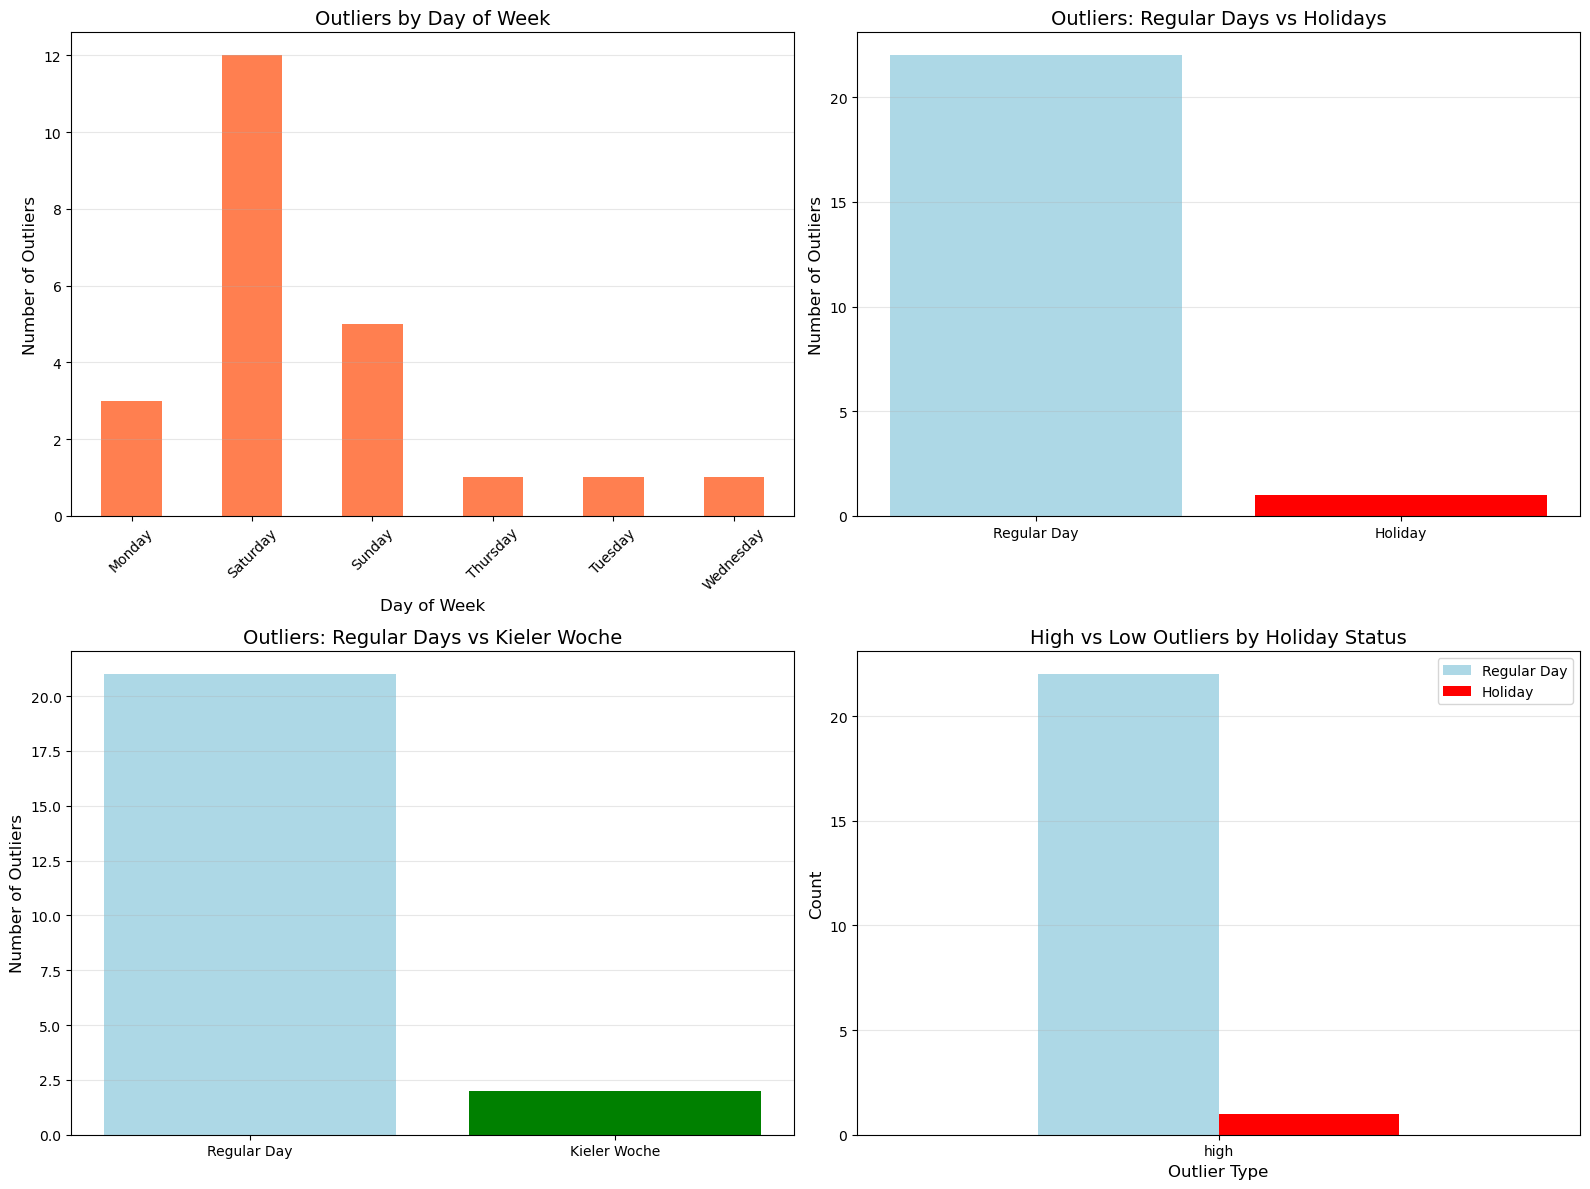

In [25]:
# Create outlier_type = "high" / "low" for OPEN days only
# Requires 'lower' and 'upper' bounds from the IQR method to exist

df_daily["outlier_type"] = "none"

mask_open = df_daily["is_closed"] == 0
mask_low = mask_open & (df_daily["daily_total_sales"] < lower)
mask_high = mask_open & (df_daily["daily_total_sales"] > upper)

df_daily.loc[mask_low, "outlier_type"] = "low"
df_daily.loc[mask_high, "outlier_type"] = "high"

# Rebuild outliers_df with the new column included
outliers_df = df_daily[df_daily["outlier_type"].isin(["low", "high"])].copy()

outlier_breakdown = outliers_df.groupby(['outlier_type', 'is_holiday']).size().unstack(fill_value=0)

# Ensure outliers_df exists and has required columns
if "outliers_df" not in globals():
    # default: IQR outliers on OPEN days using df_daily (must exist from earlier cells)
    df_open = df_daily[df_daily["is_closed"] == 0].copy()
    Q1 = df_open["daily_total_sales"].quantile(0.25)
    Q3 = df_open["daily_total_sales"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_daily["outlier_iqr"] = 0
    df_daily.loc[df_daily["is_closed"] == 0, "outlier_iqr"] = (
        ((df_open["daily_total_sales"] < lower) | (df_open["daily_total_sales"] > upper)).astype(int).values
    )
    outliers_df = df_daily[(df_daily["is_closed"] == 0) & (df_daily["outlier_iqr"] == 1)].copy()

# Make sure day_name exists
if "day_name" not in outliers_df.columns:
    outliers_df["day_name"] = outliers_df["Date"].dt.day_name()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Outliers by day of week
outliers_df['day_name'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0, 0], color='coral'
)
axes[0, 0].set_title('Outliers by Day of Week', fontsize=14)
axes[0, 0].set_xlabel('Day of Week', fontsize=12)
axes[0, 0].set_ylabel('Number of Outliers', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Holiday vs Non-Holiday outliers
holiday_outliers = outliers_df.groupby('is_holiday').size()
axes[0, 1].bar(['Regular Day', 'Holiday'], 
               [holiday_outliers.get(0, 0), holiday_outliers.get(1, 0)],
               color=['lightblue', 'red'])
axes[0, 1].set_title('Outliers: Regular Days vs Holidays', fontsize=14)
axes[0, 1].set_ylabel('Number of Outliers', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: KielerWoche vs Non-KielerWoche outliers
kiwo_outliers = outliers_df.groupby('KielerWoche').size()
axes[1, 0].bar(['Regular Day', 'Kieler Woche'], 
               [kiwo_outliers.get(0, 0), kiwo_outliers.get(1, 0)],
               color=['lightblue', 'green'])
axes[1, 0].set_title('Outliers: Regular Days vs Kieler Woche', fontsize=14)
axes[1, 0].set_ylabel('Number of Outliers', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: High vs Low outliers by type
outlier_breakdown = outliers_df.groupby(['outlier_type', 'is_holiday']).size().unstack(fill_value=0)
outlier_breakdown.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'red'])
axes[1, 1].set_title('High vs Low Outliers by Holiday Status', fontsize=14)
axes[1, 1].set_xlabel('Outlier Type', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].legend(['Regular Day', 'Holiday'])
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/outlier_patterns.png', dpi=300)
plt.show()

Show Actual Outlier Dates

In [26]:
# Display outlier details (daily total sales)
# Ensure outliers_df exists
if "outliers_df" not in globals():
    df_open = df_daily[df_daily["is_closed"] == 0].copy()
    Q1 = df_open["daily_total_sales"].quantile(0.25)
    Q3 = df_open["daily_total_sales"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_daily["outlier_iqr"] = 0
    df_daily.loc[df_daily["is_closed"] == 0, "outlier_iqr"] = (
        ((df_open["daily_total_sales"] < lower) | (df_open["daily_total_sales"] > upper)).astype(int).values
    )
    outliers_df = df_daily[(df_daily["is_closed"] == 0) & (df_daily["outlier_iqr"] == 1)].copy()

if "day_name" not in outliers_df.columns:
    outliers_df["day_name"] = outliers_df["Date"].dt.day_name()

print("\n=== OUTLIER DETAILS (DAILY TOTAL SALES, OPEN DAYS ONLY) ===\n")
outliers_display = outliers_df[
    ["Date", "daily_total_sales", "day_name", "is_holiday", "KielerWoche"]
].copy().sort_values("daily_total_sales", ascending=False)

print("Top 10 Highest Sales Outlier Days:")
print(outliers_display.head(10).to_string(index=False))

print("\nTop 10 Lowest Sales Outlier Days:")
print(outliers_display.tail(10).to_string(index=False))


=== OUTLIER DETAILS (DAILY TOTAL SALES, OPEN DAYS ONLY) ===

Top 10 Highest Sales Outlier Days:
      Date  daily_total_sales  day_name  is_holiday  KielerWoche
2014-05-05        3156.413344    Monday           0            0
2015-12-31        3014.915888  Thursday           0            0
2014-12-31        2938.717609 Wednesday           0            0
2016-12-31        2772.611848  Saturday           0            0
2013-12-31        2615.411466   Tuesday           0            0
2017-12-31        2377.797450    Sunday           0            0
2014-08-18        2120.587134    Monday           0            0
2014-06-28        2096.209536  Saturday           0            1
2013-08-03        2022.092978  Saturday           0            0
2016-08-13        2014.038470  Saturday           0            0

Top 10 Lowest Sales Outlier Days:
      Date  daily_total_sales day_name  is_holiday  KielerWoche
2014-08-09        1958.276501 Saturday           0            0
2017-04-15        1949.71

Calendar KielerWoche and holyday with Outliers

Creating calendar from 2013-07-01 00:00:00 to 2018-07-31 00:00:00
Holidays: 20 days
Kieler Woche: 45 days
Closed days: 0 days
Outliers: 23 days

Generating 61 calendar months...
Saved calendar page 1/16


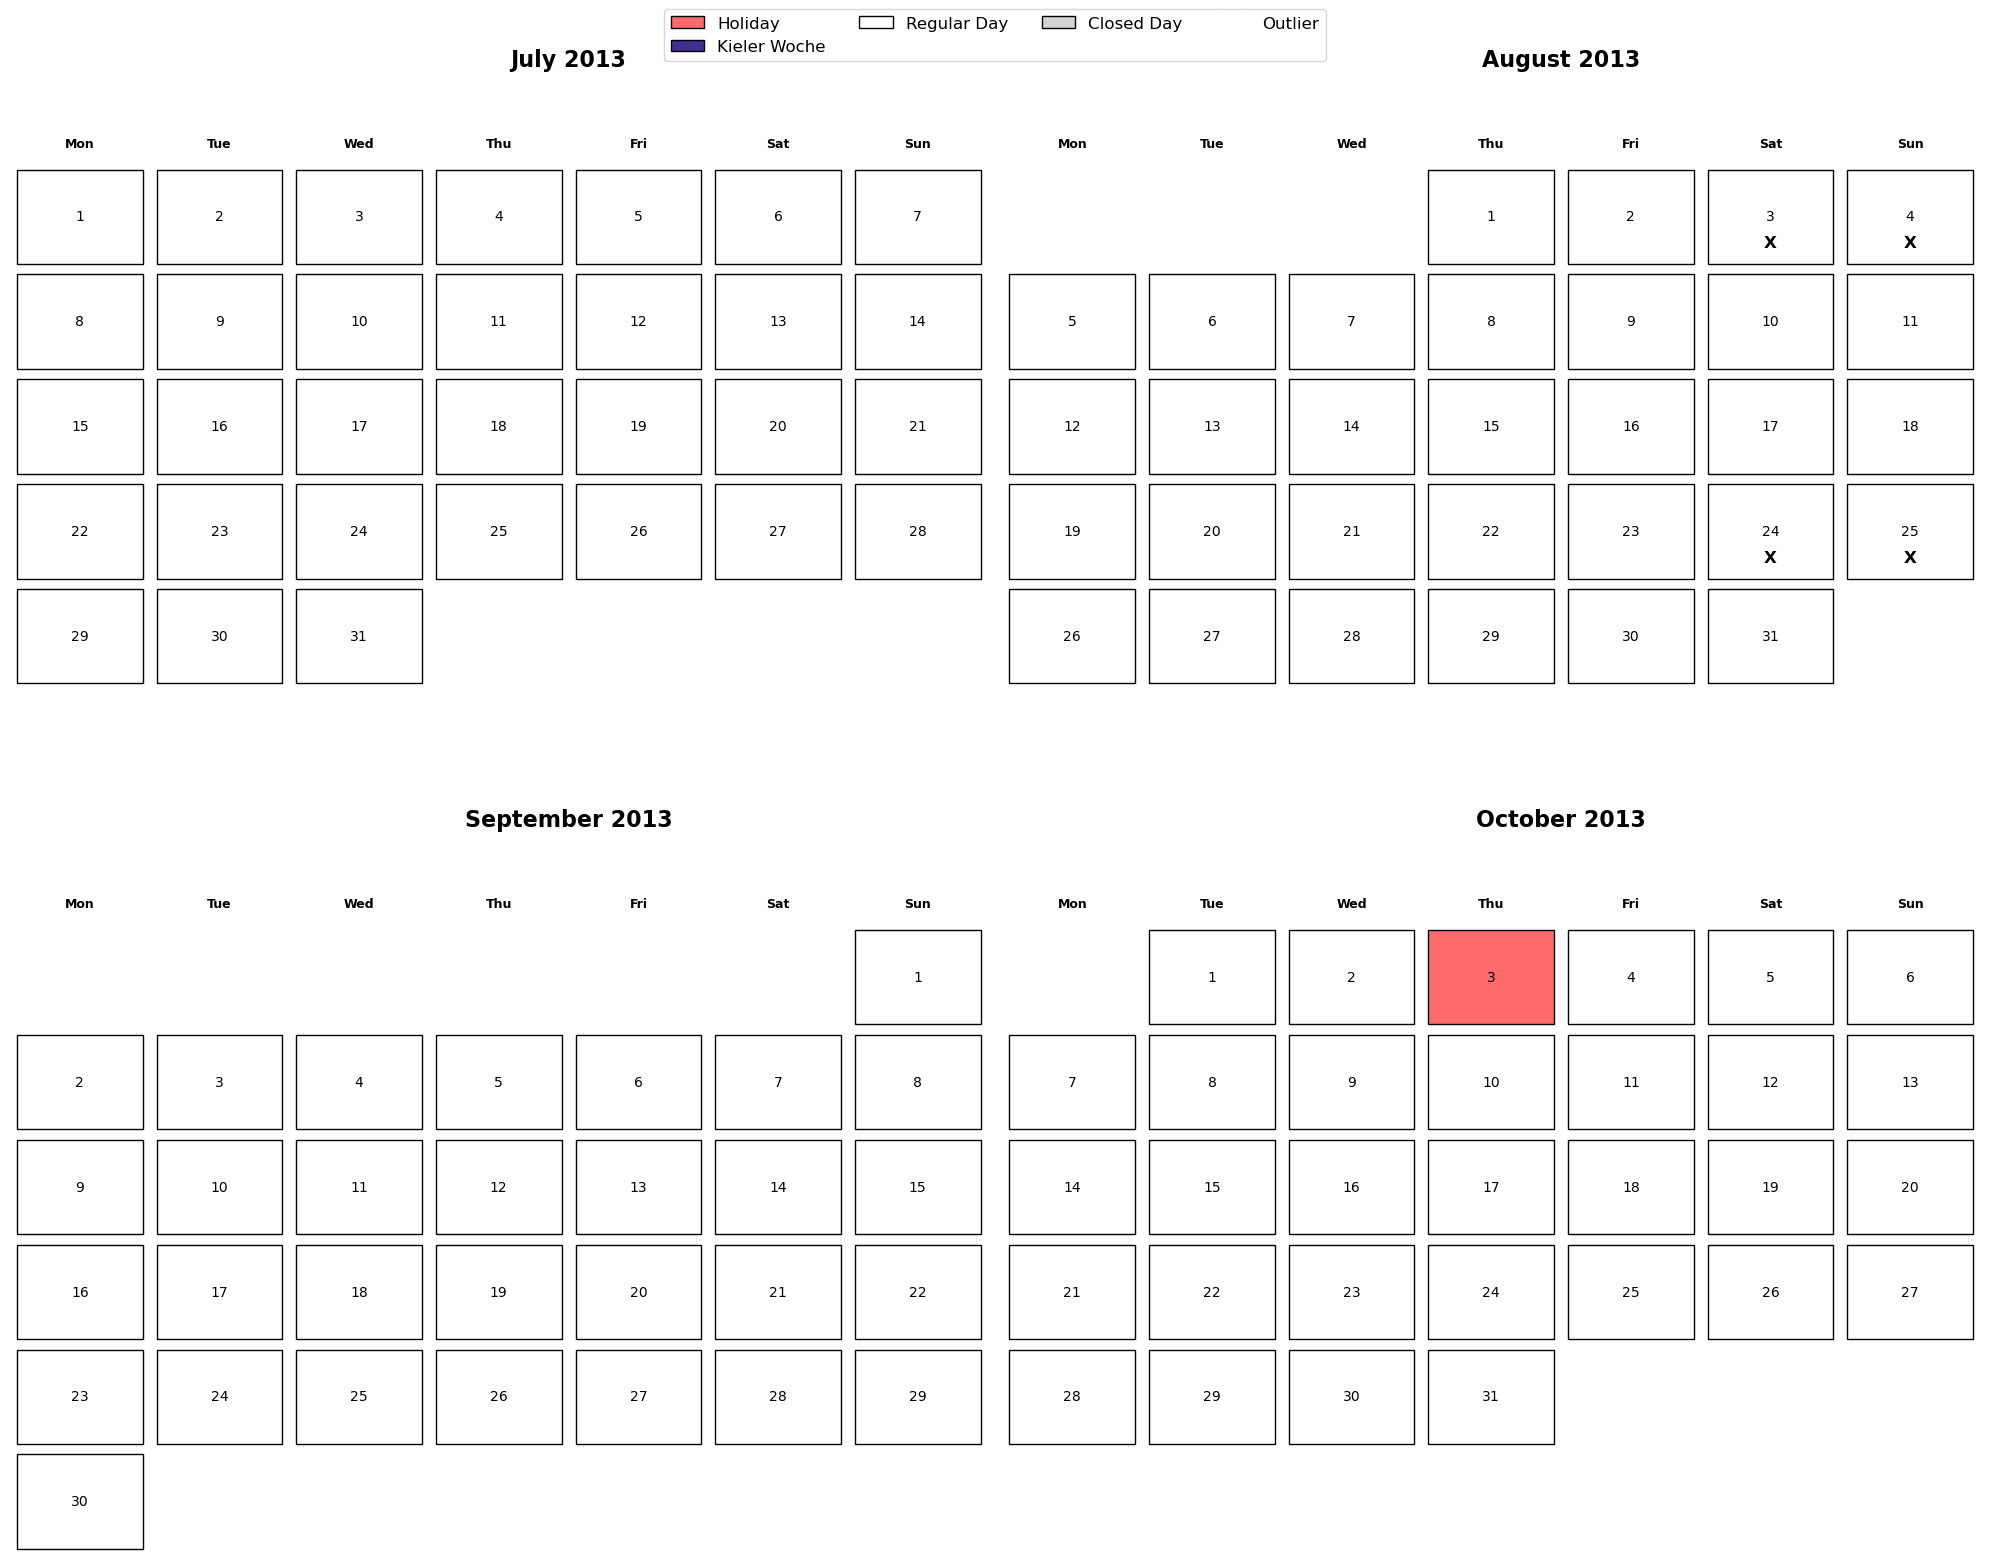

Saved calendar page 2/16


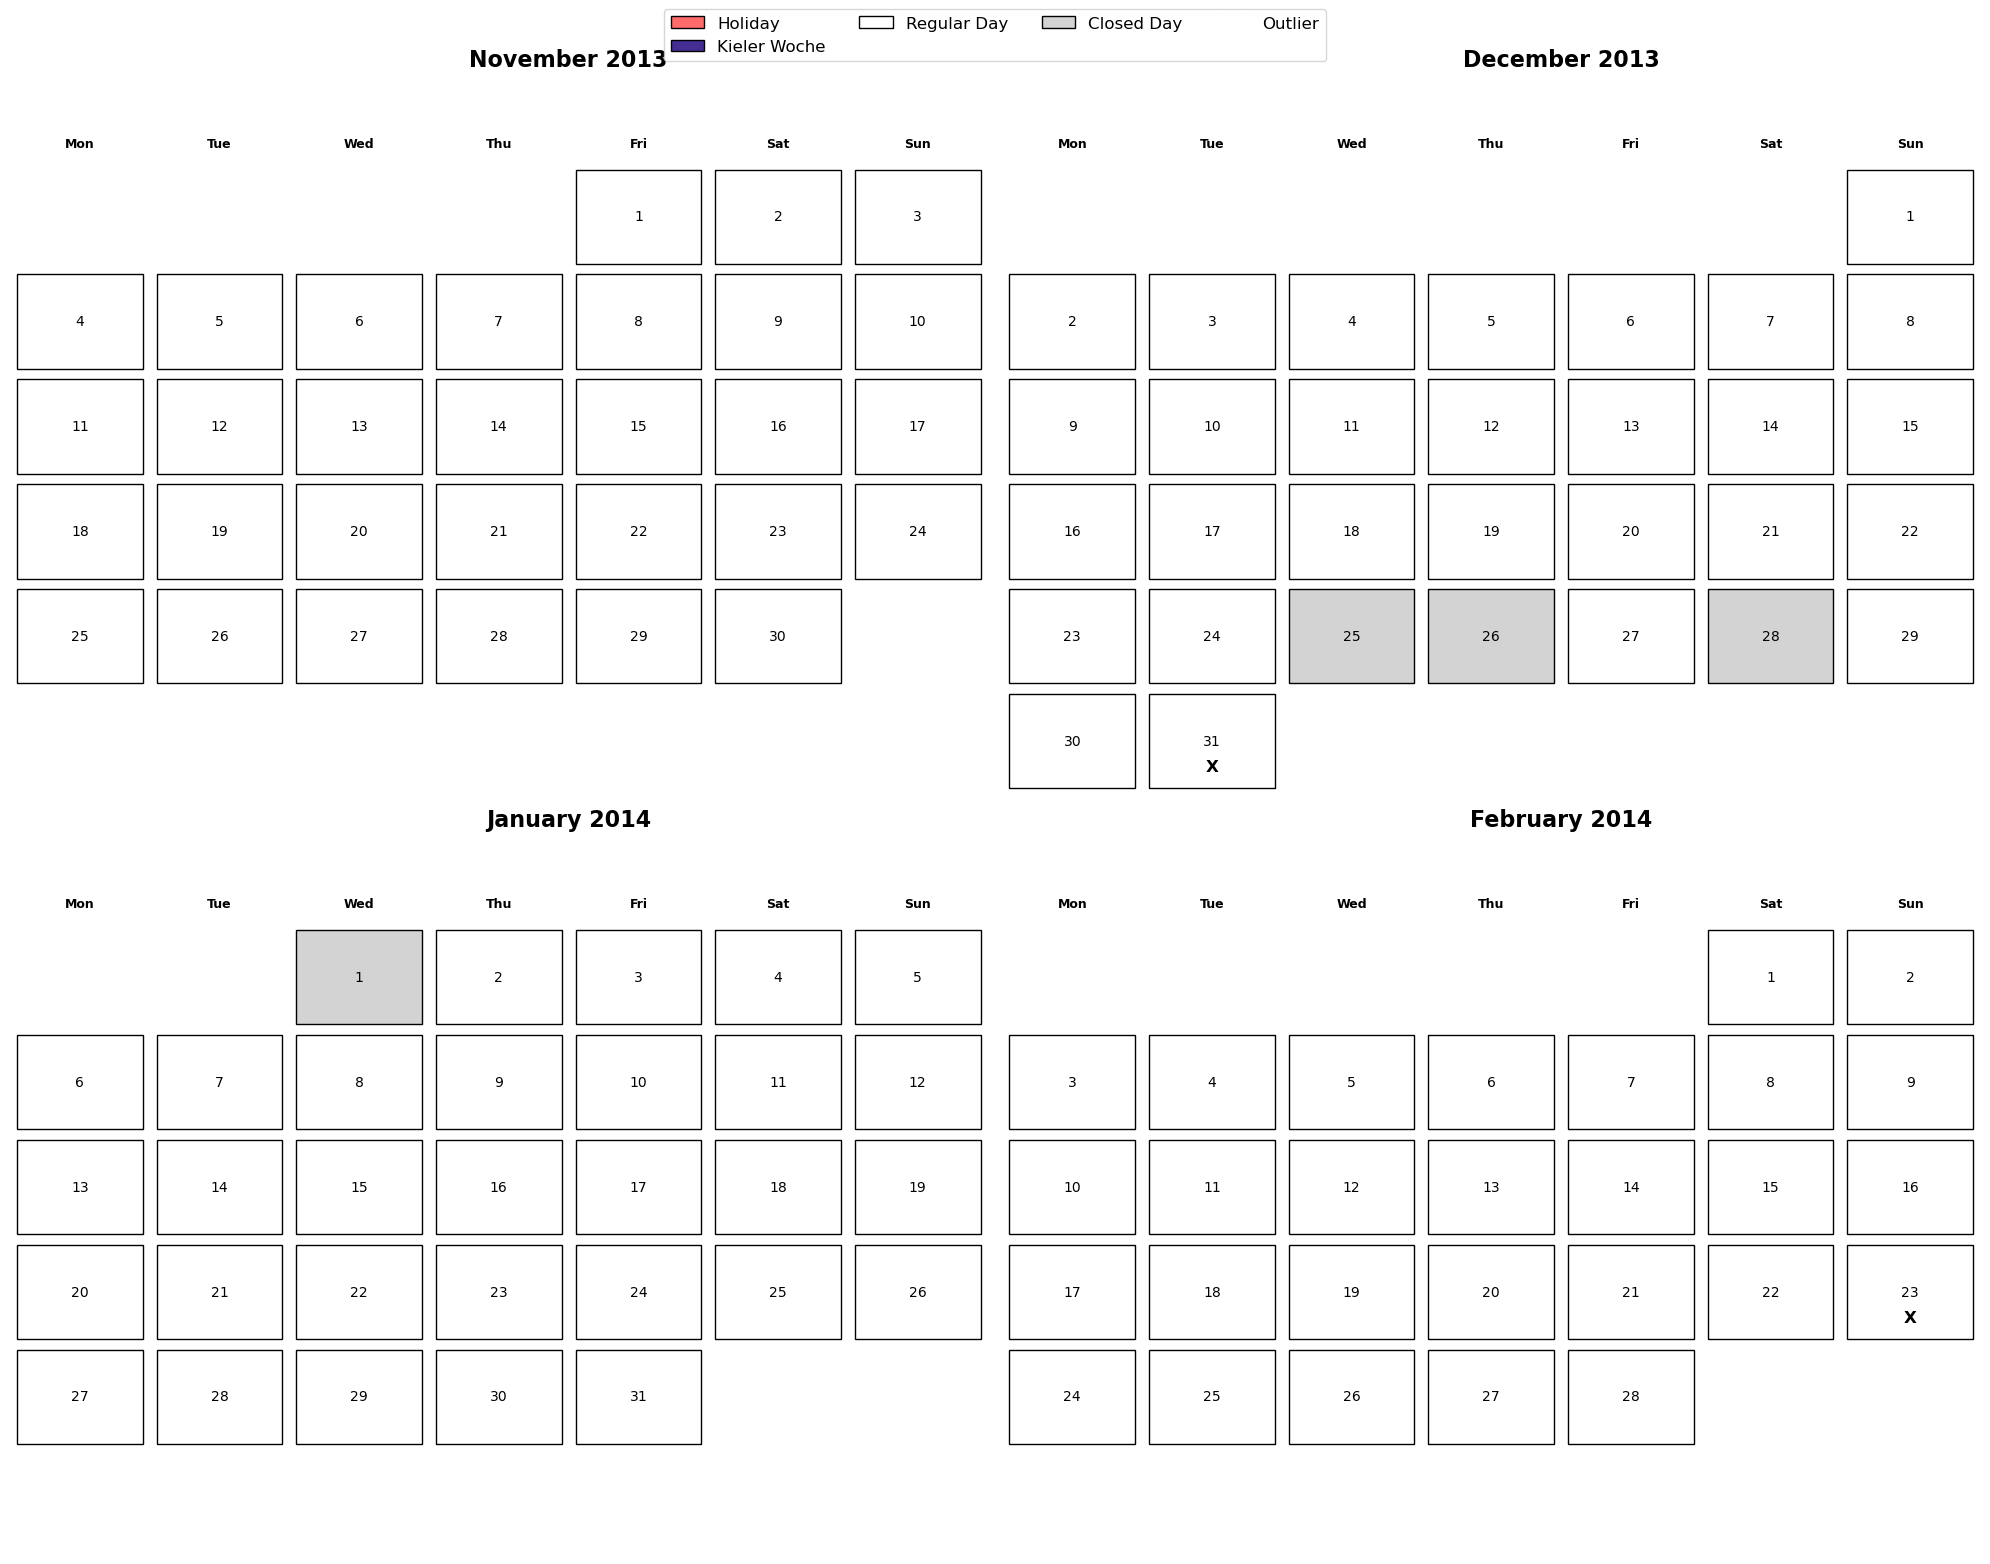

Saved calendar page 3/16


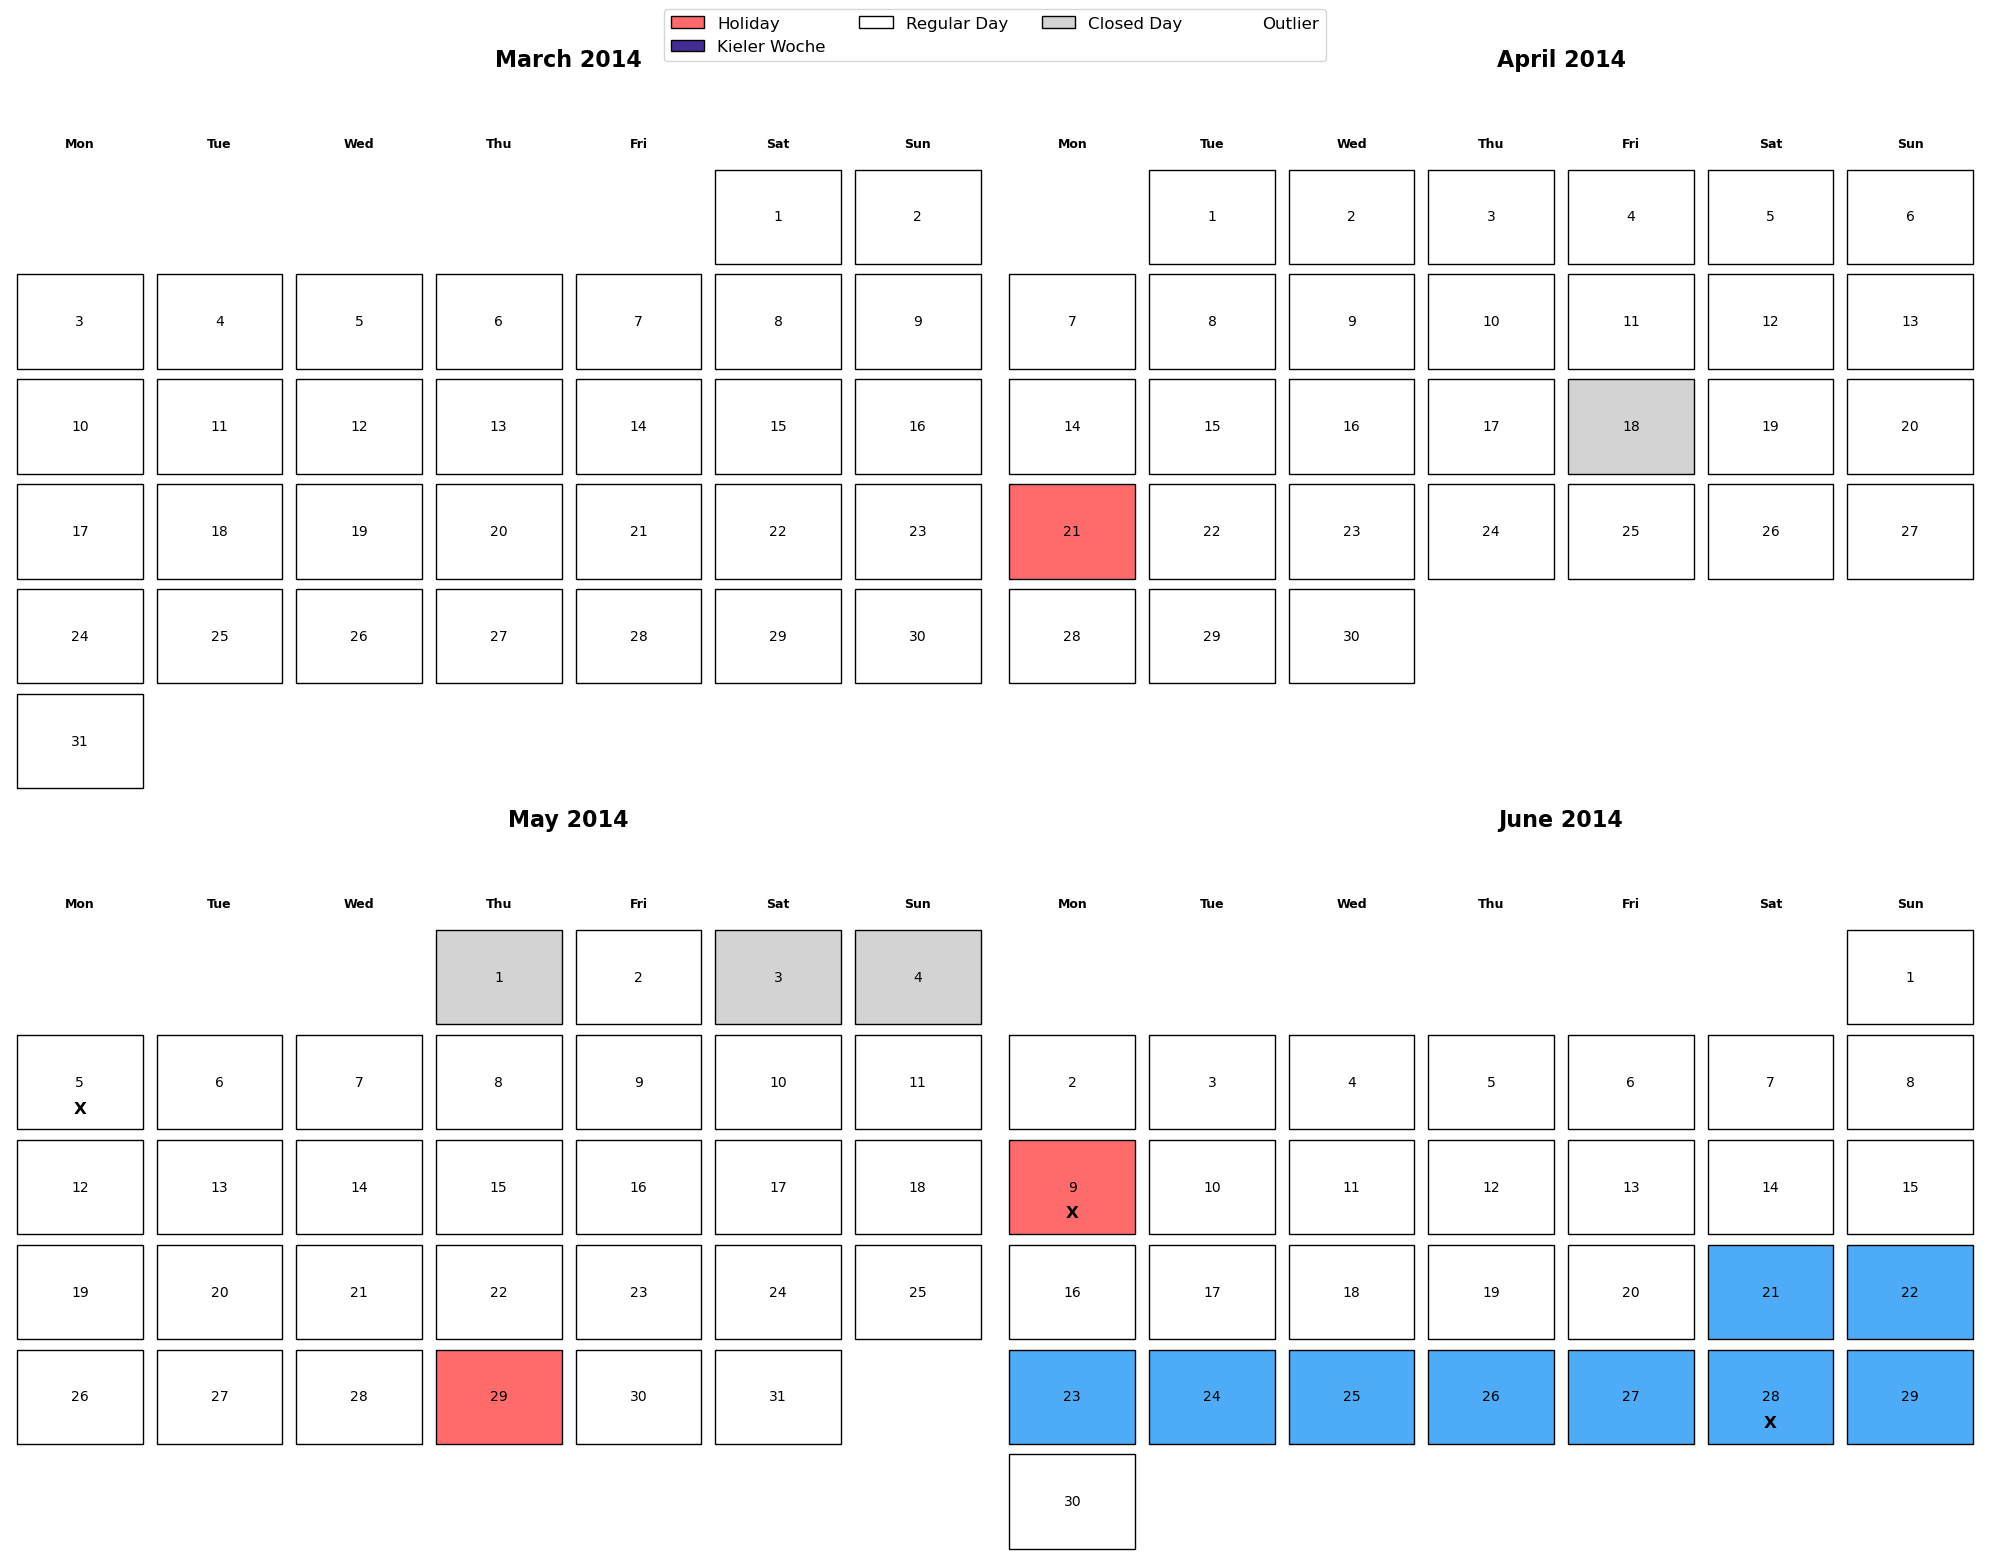

Saved calendar page 4/16


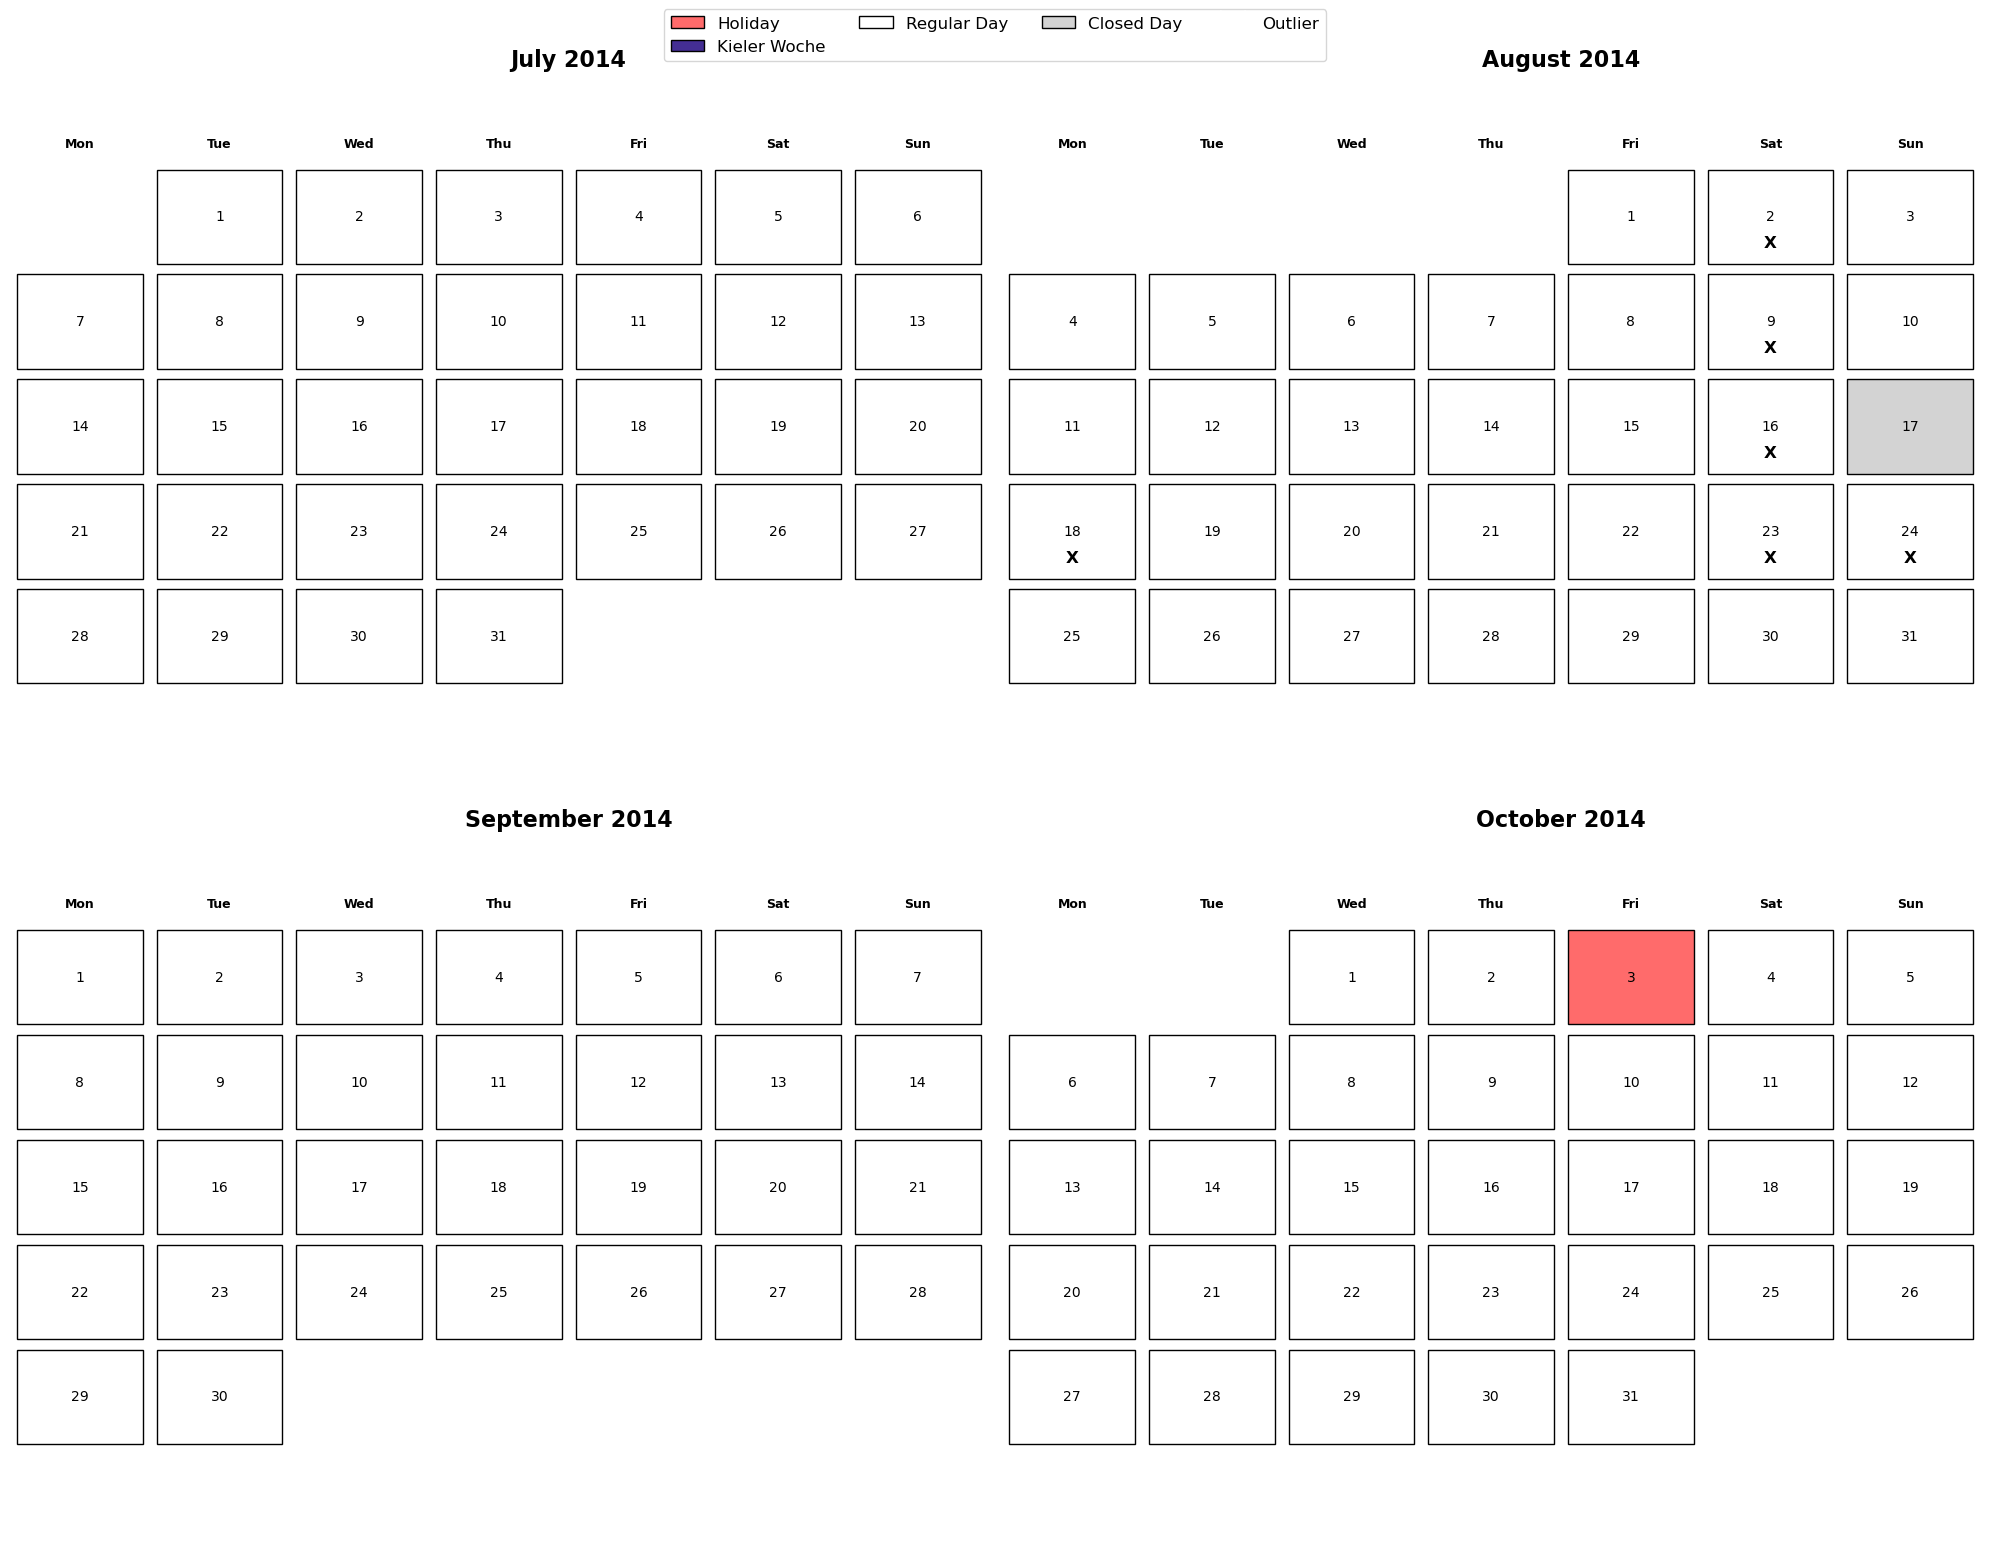

Saved calendar page 5/16


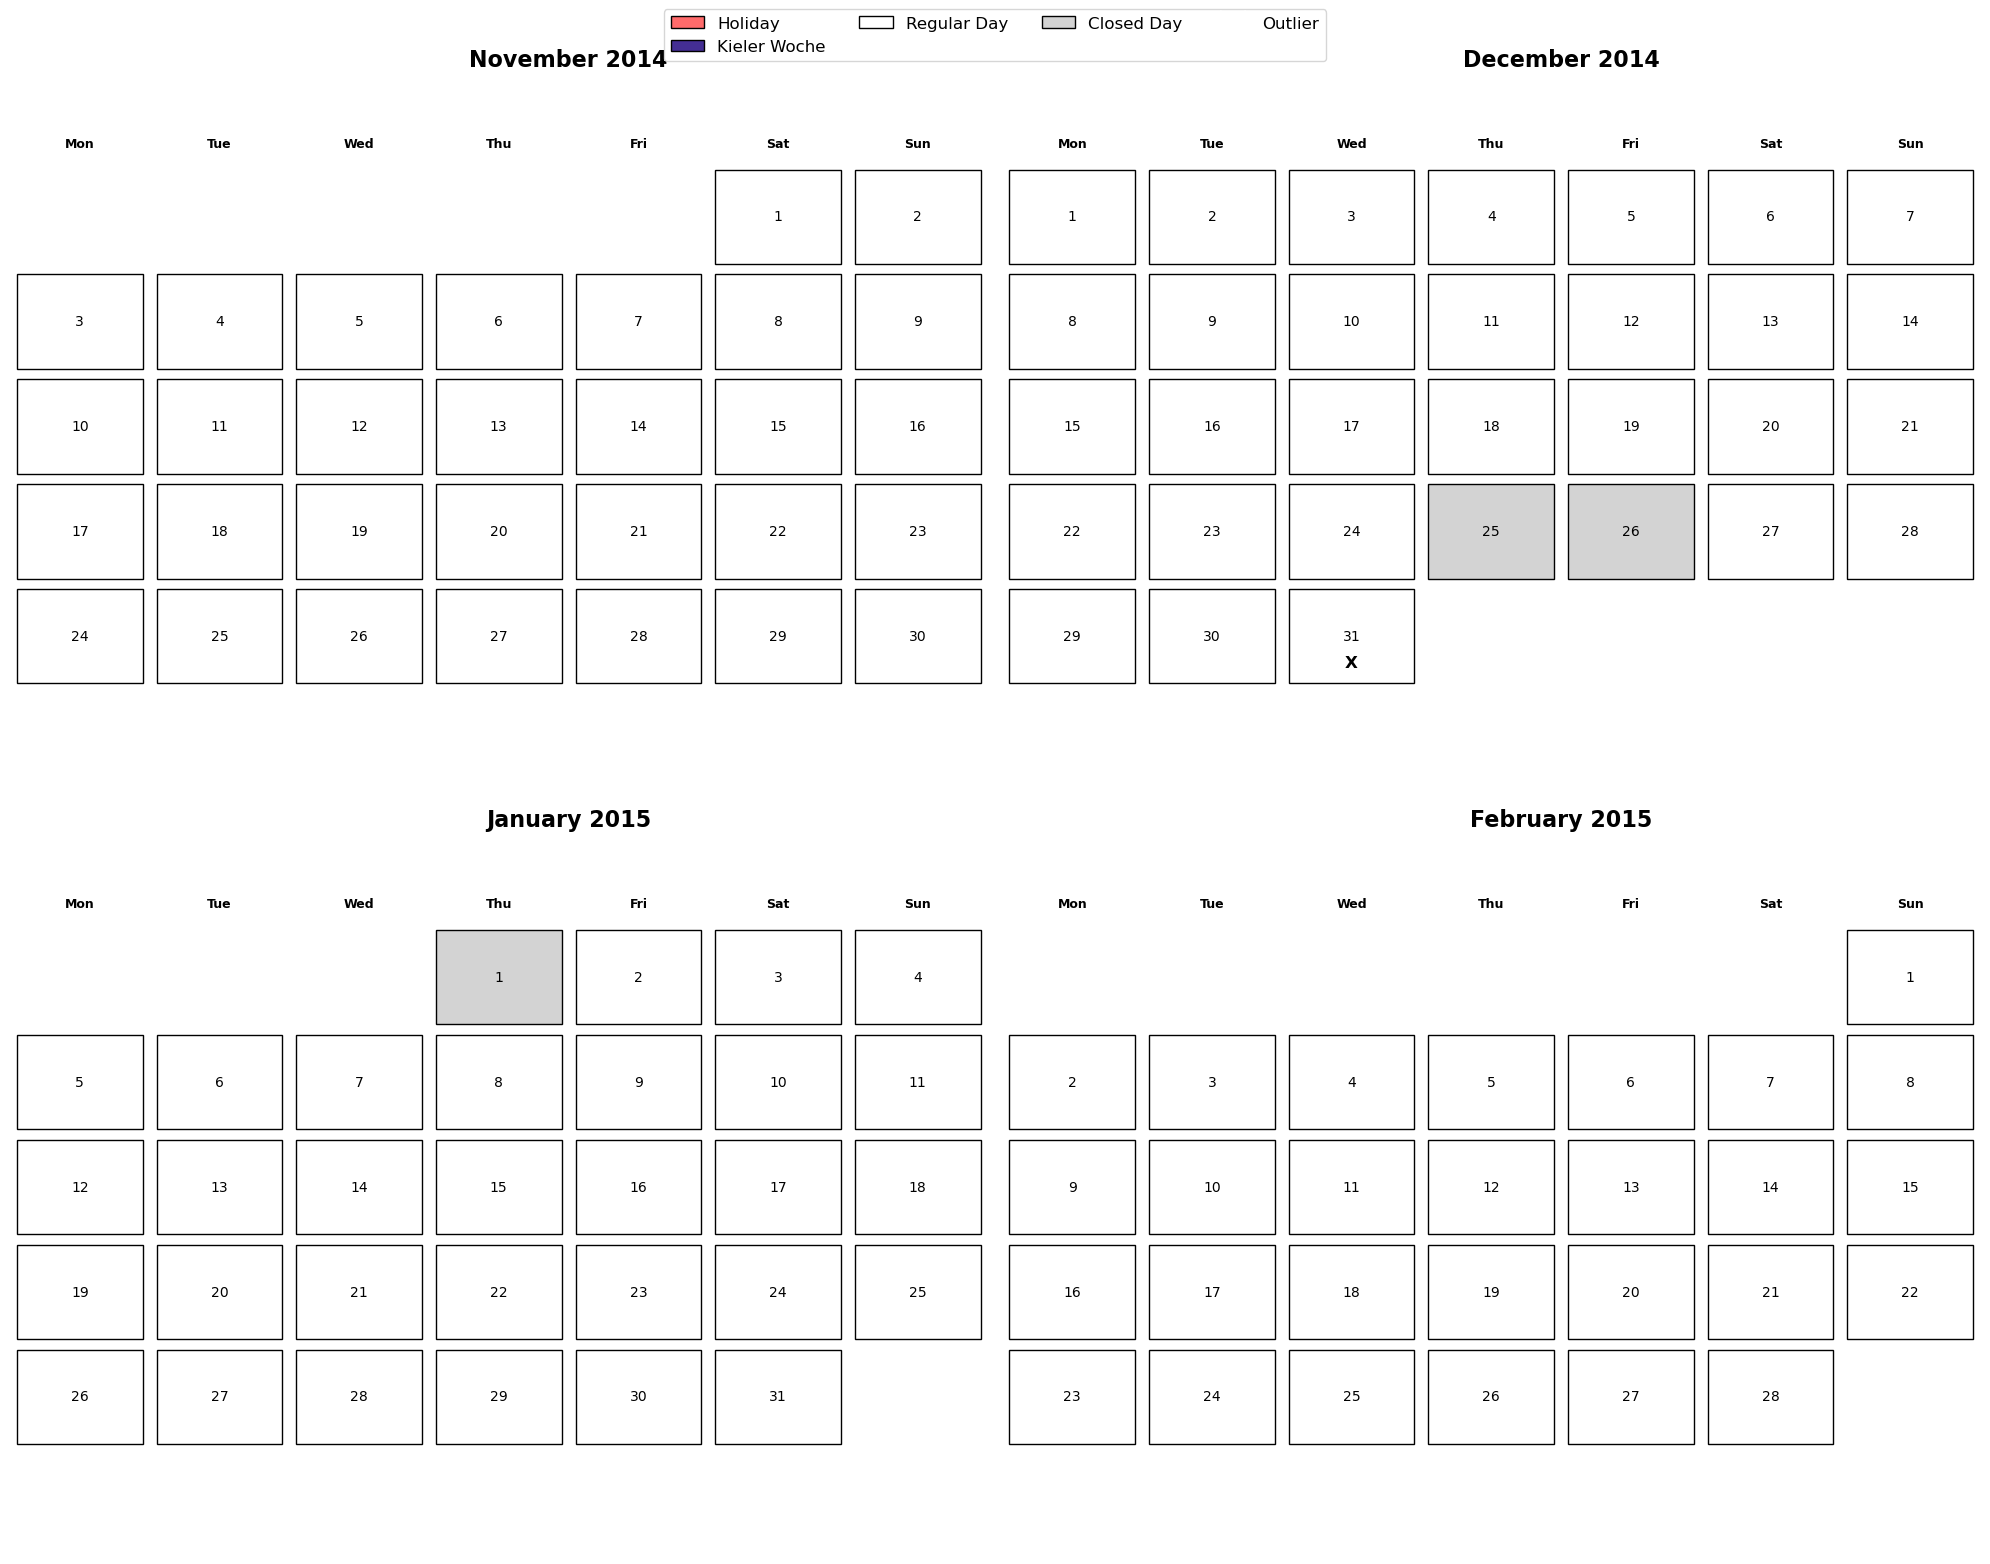

Saved calendar page 6/16


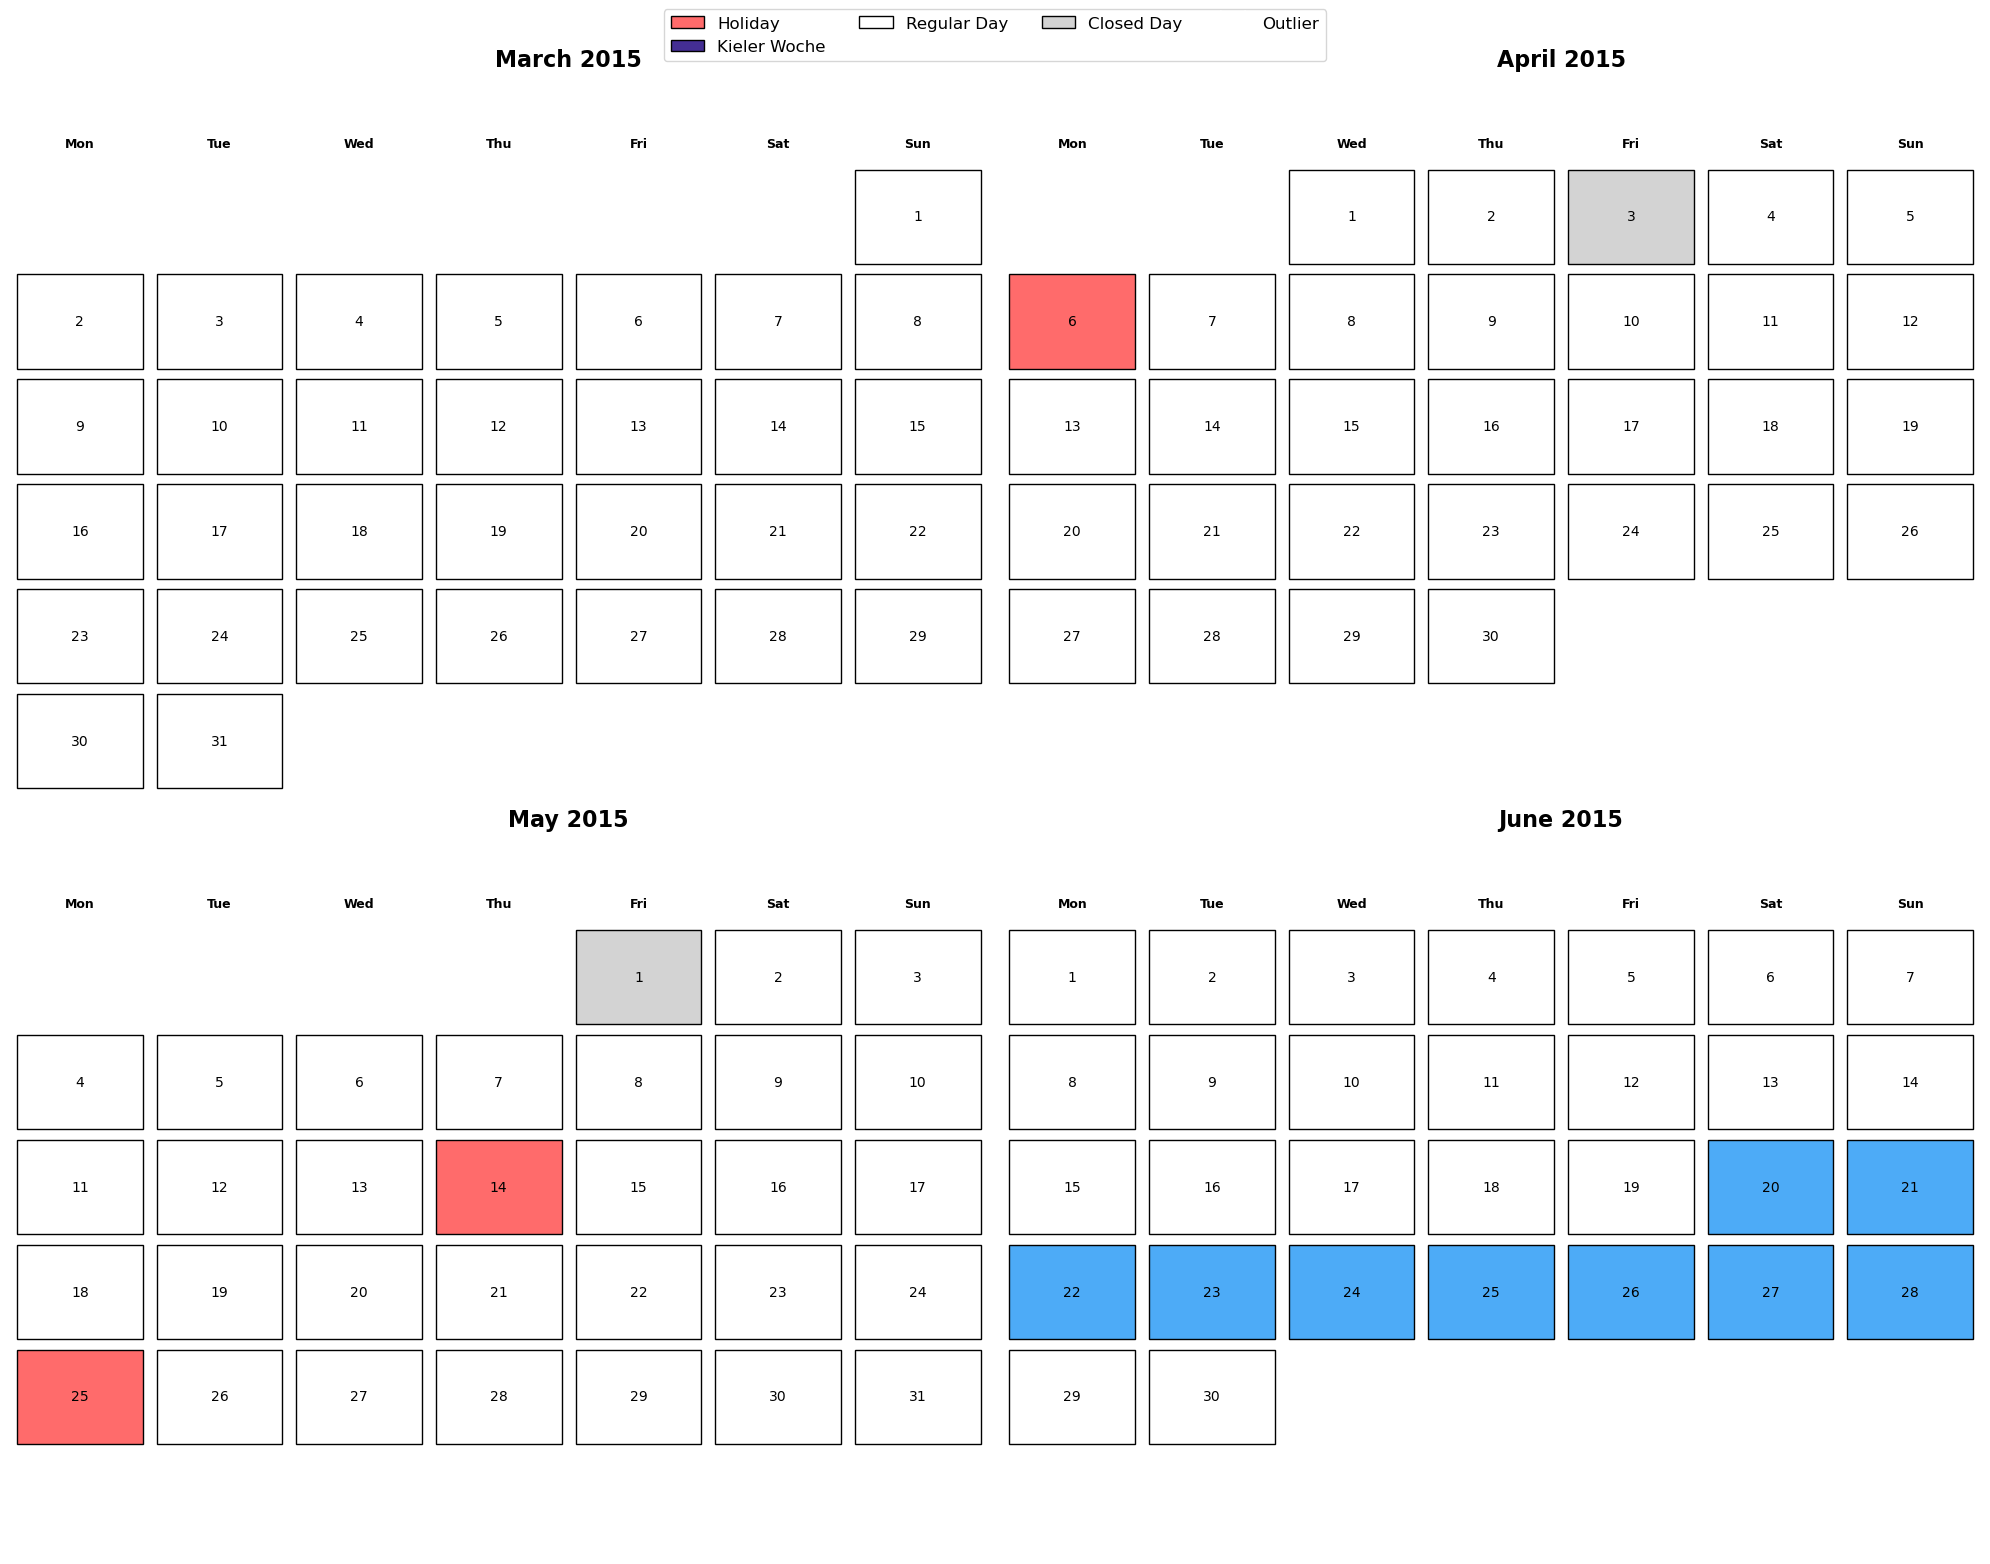

Saved calendar page 7/16


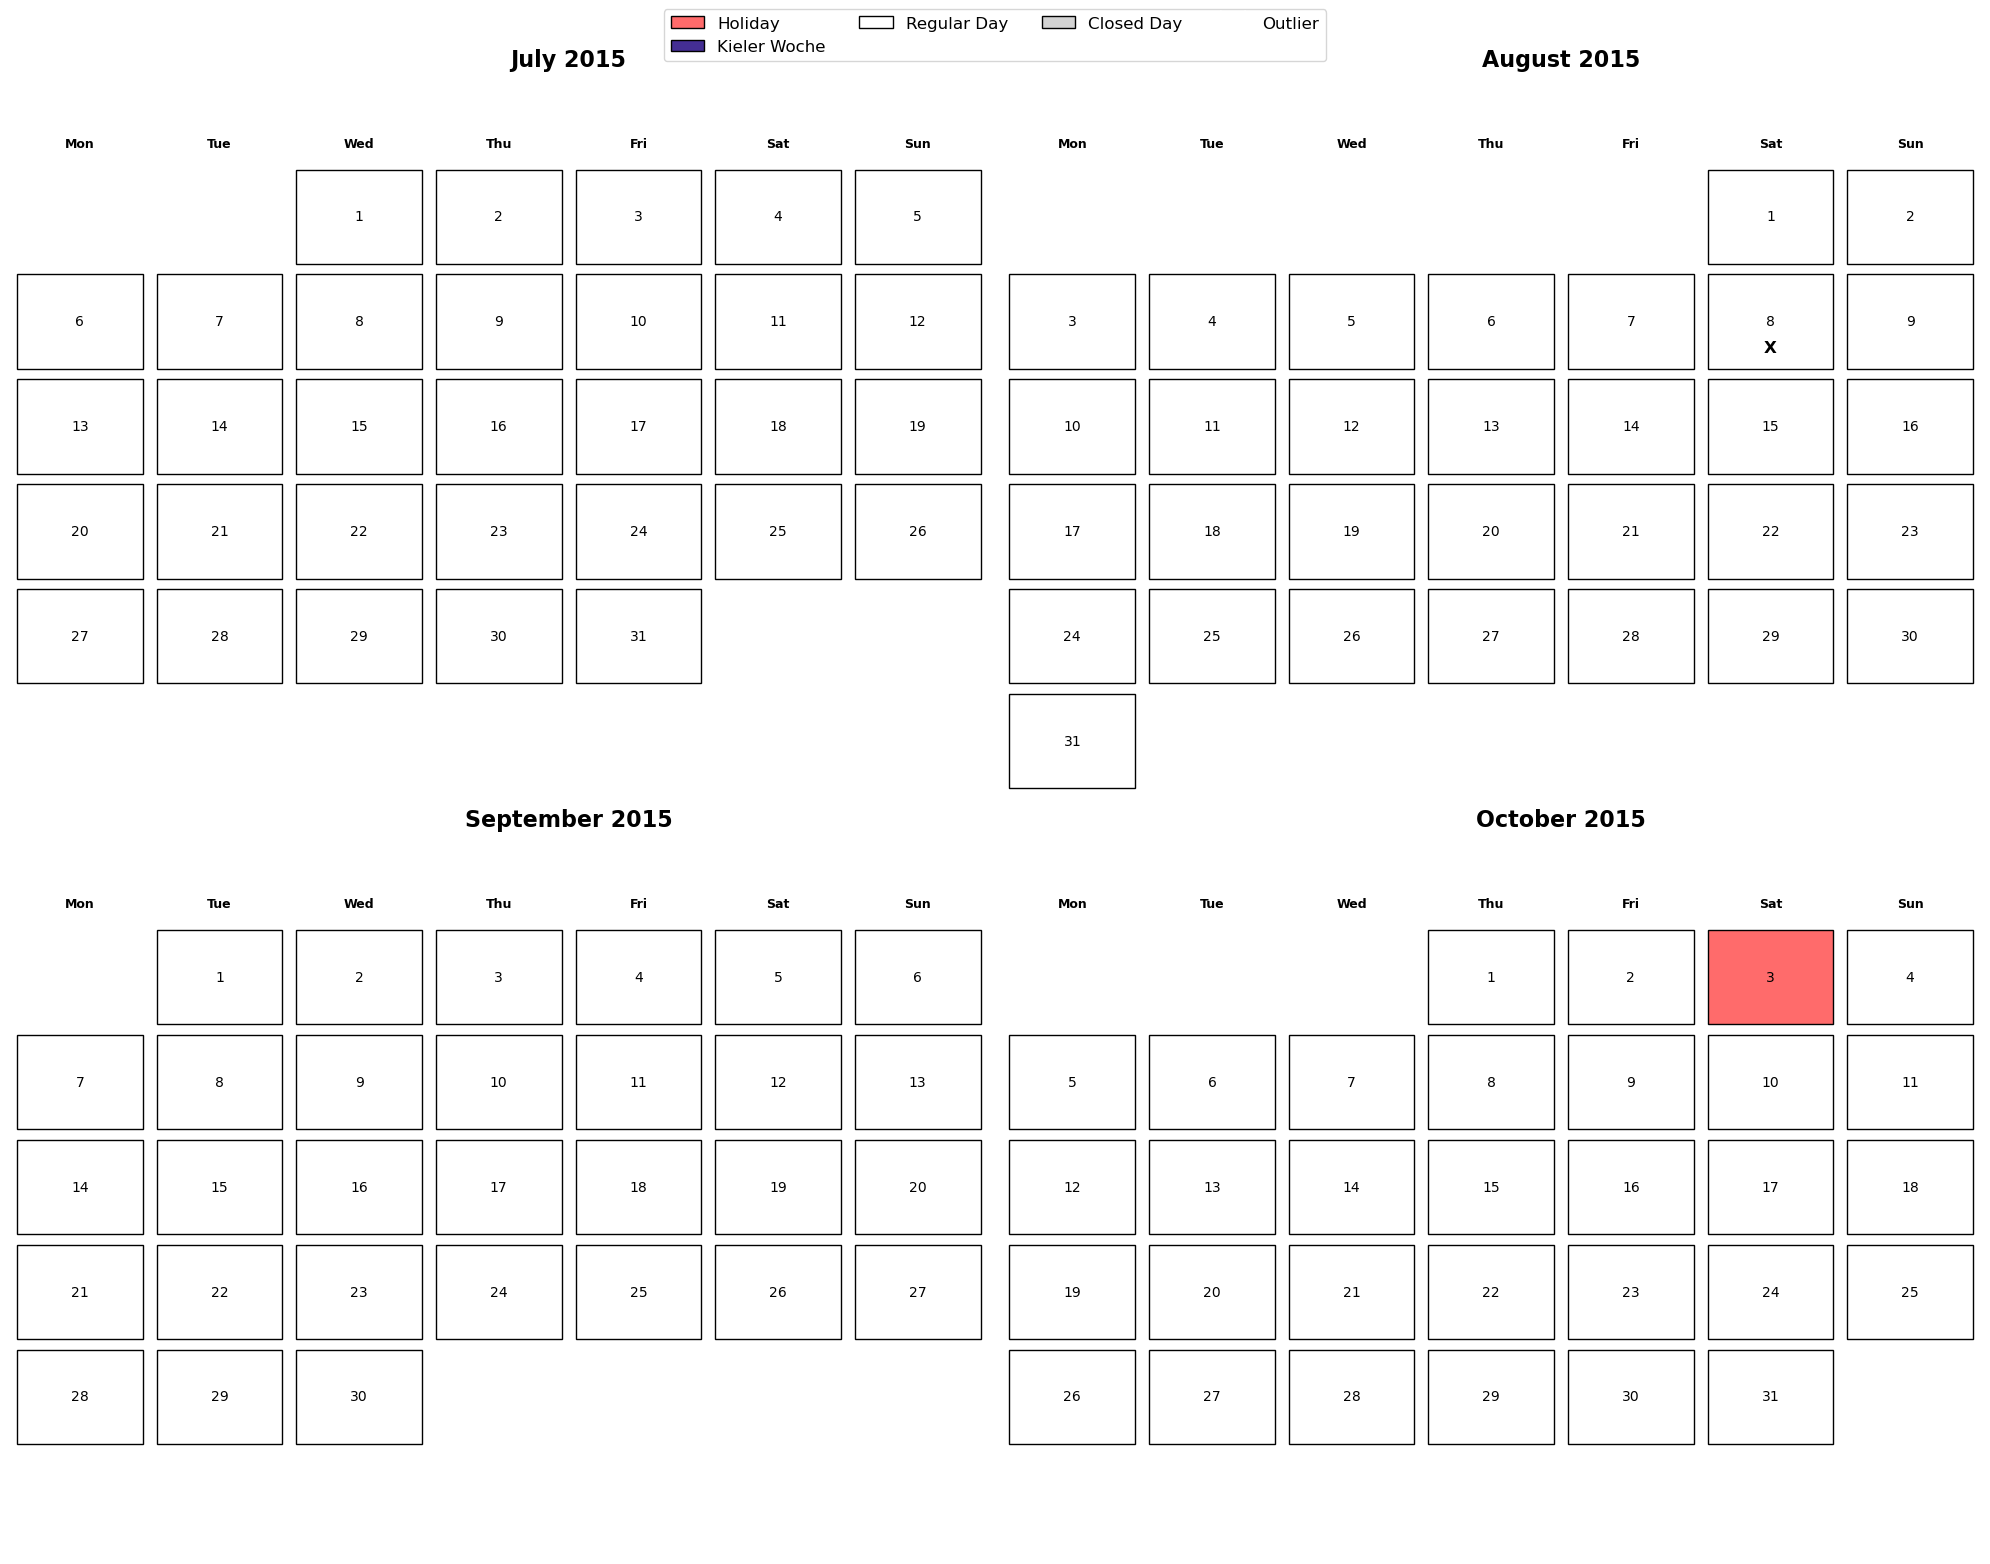

Saved calendar page 8/16


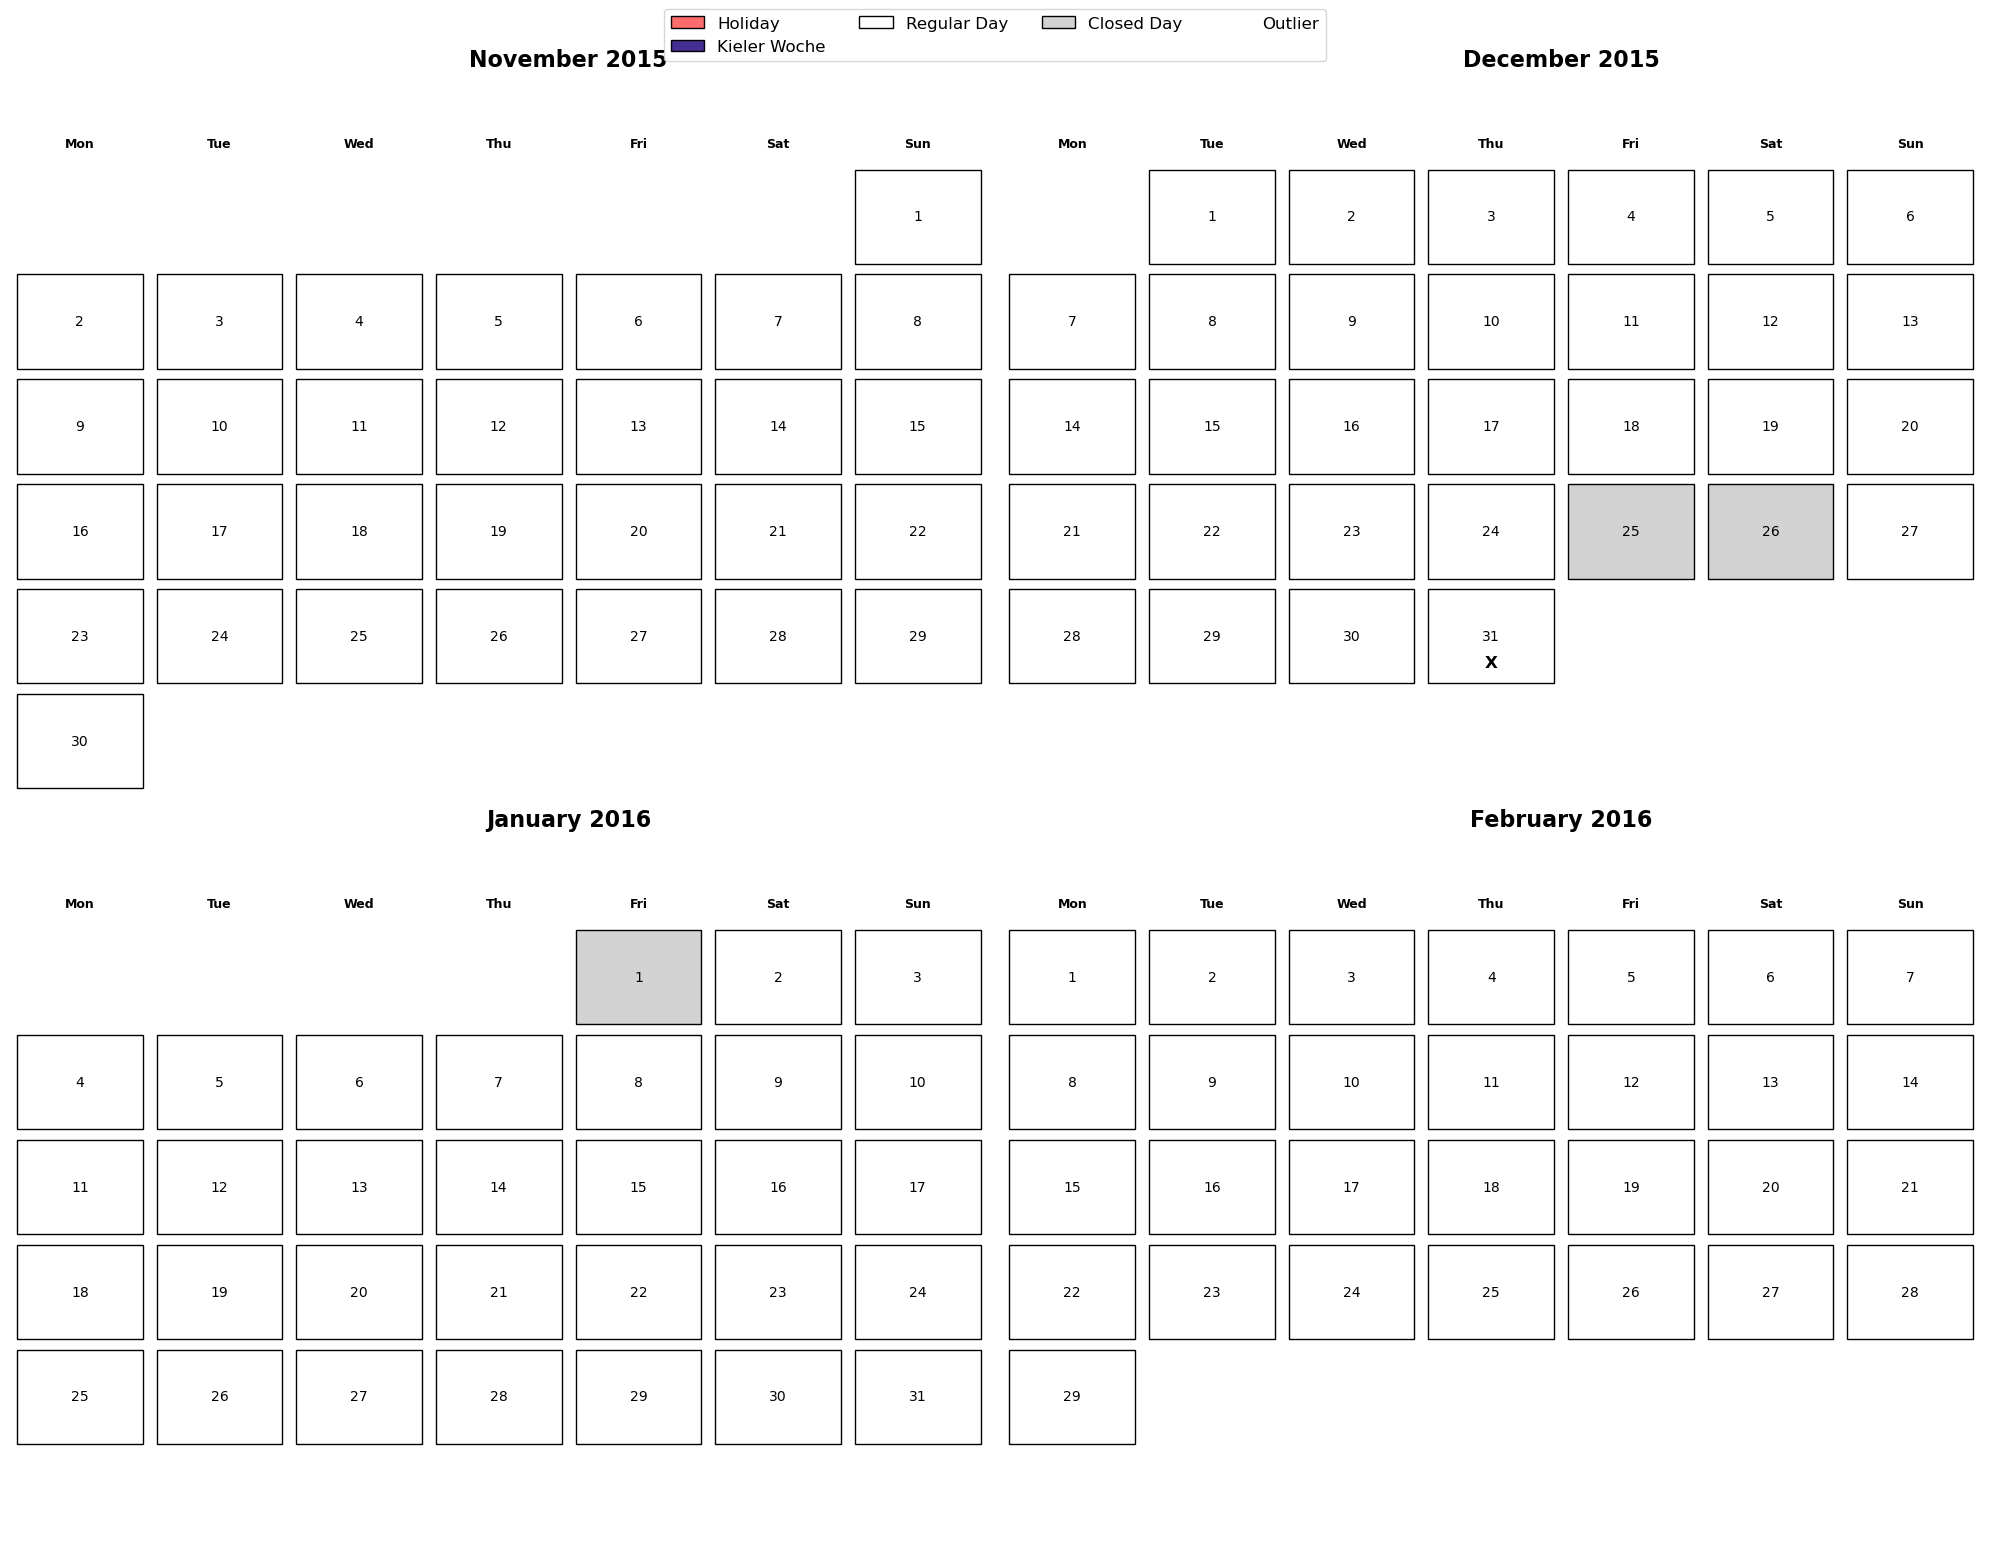

Saved calendar page 9/16


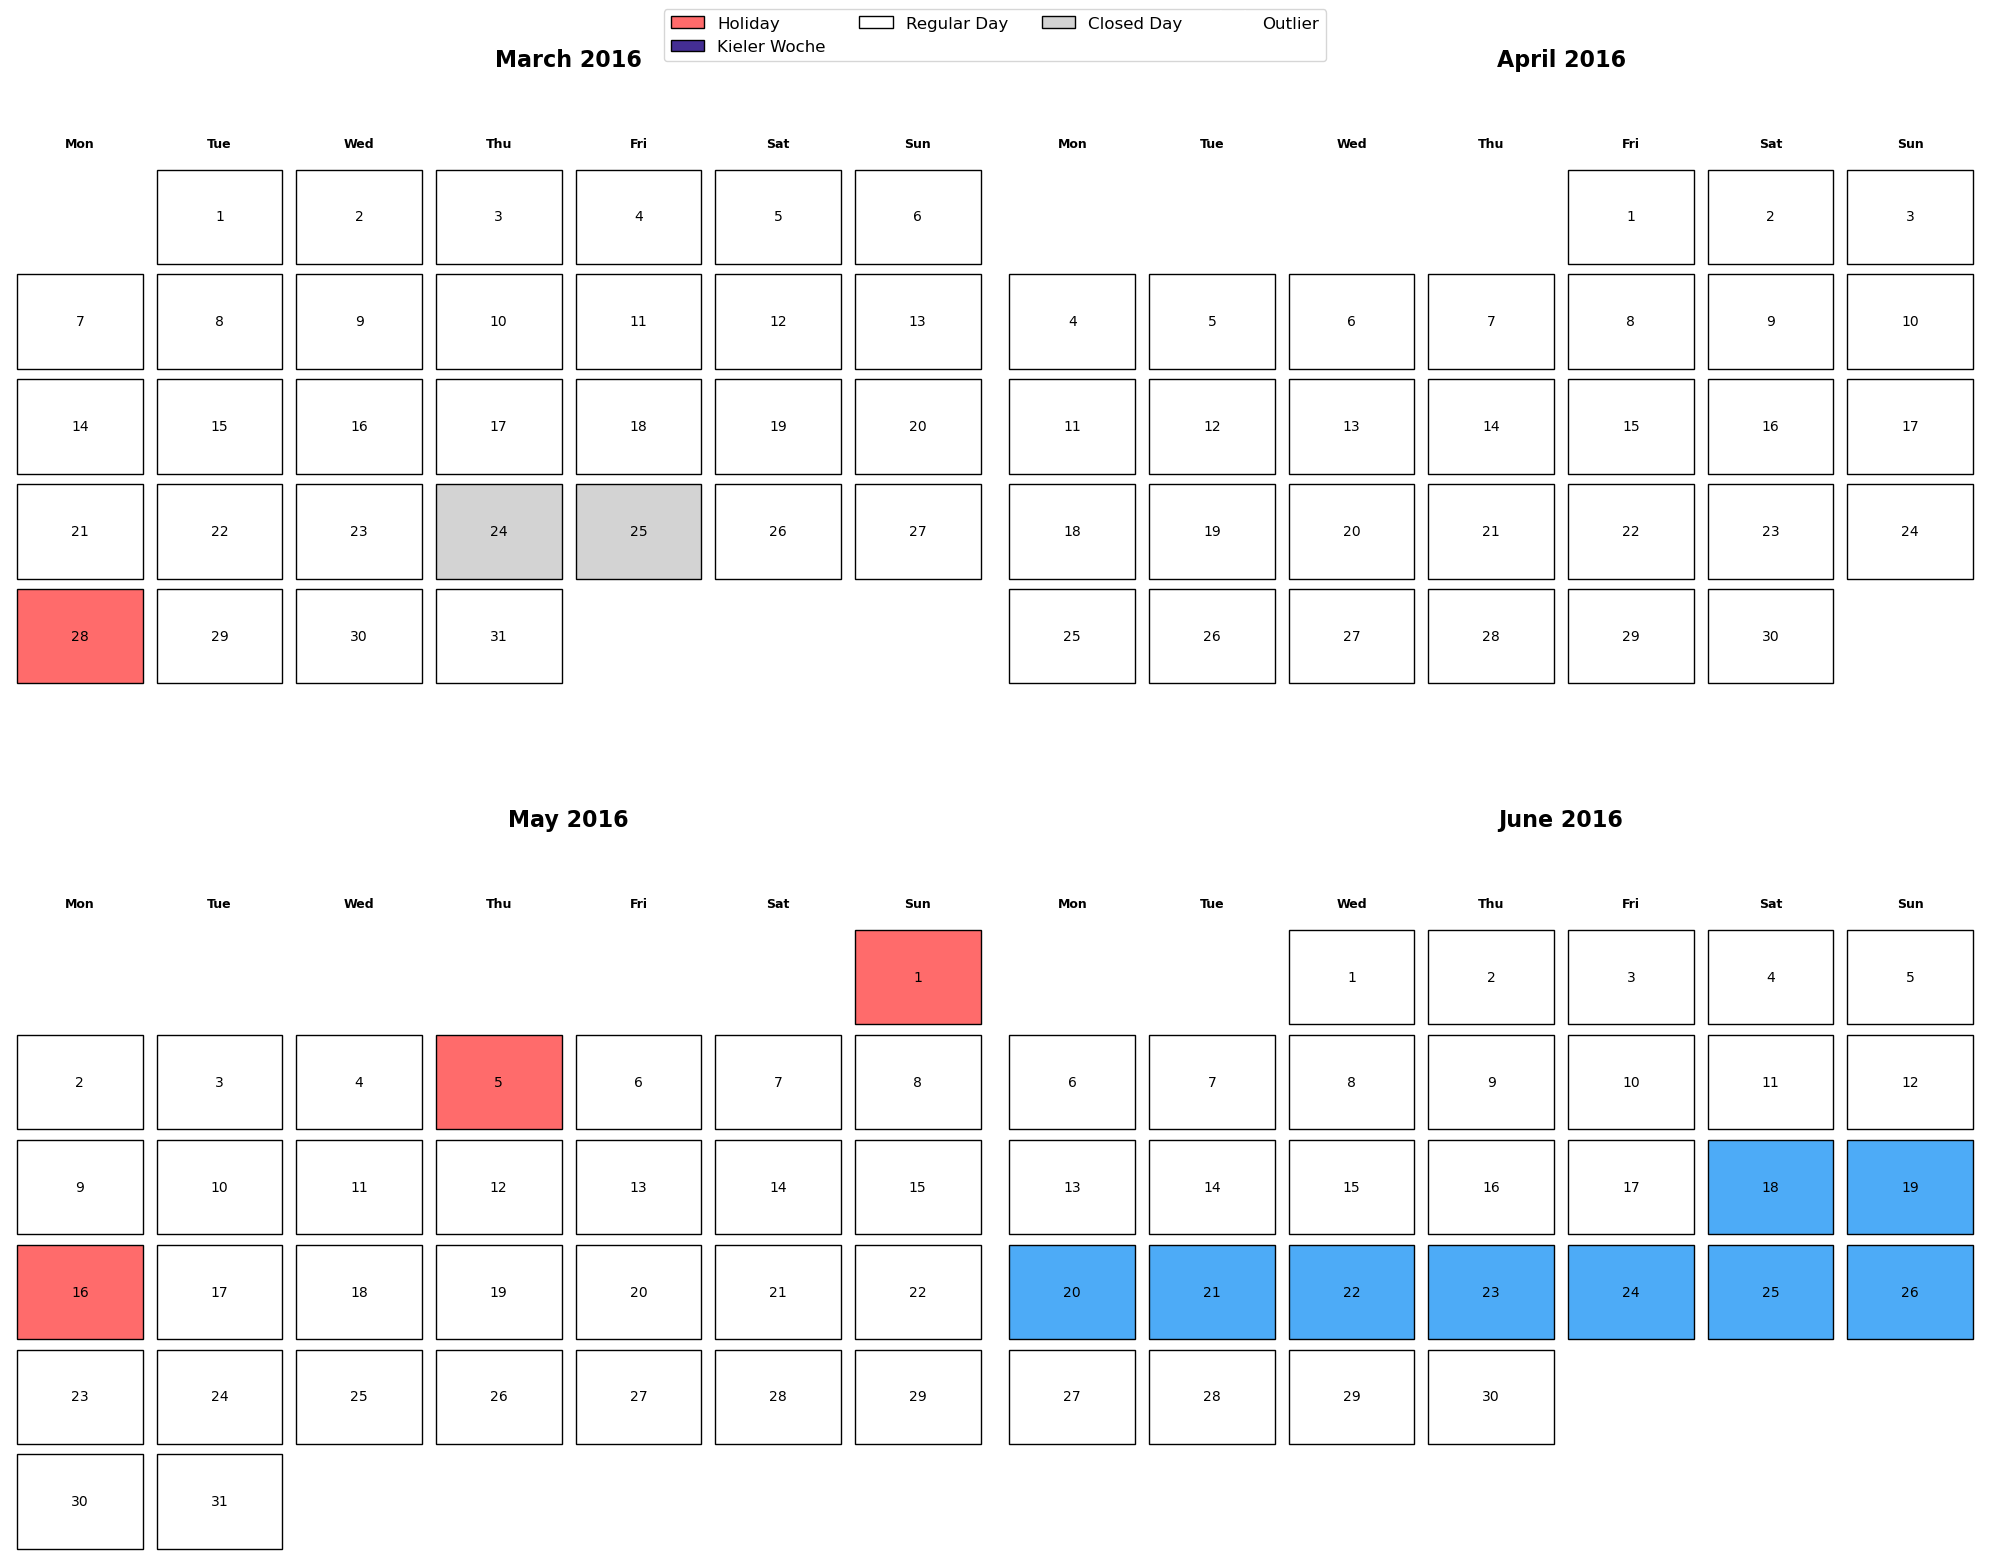

Saved calendar page 10/16


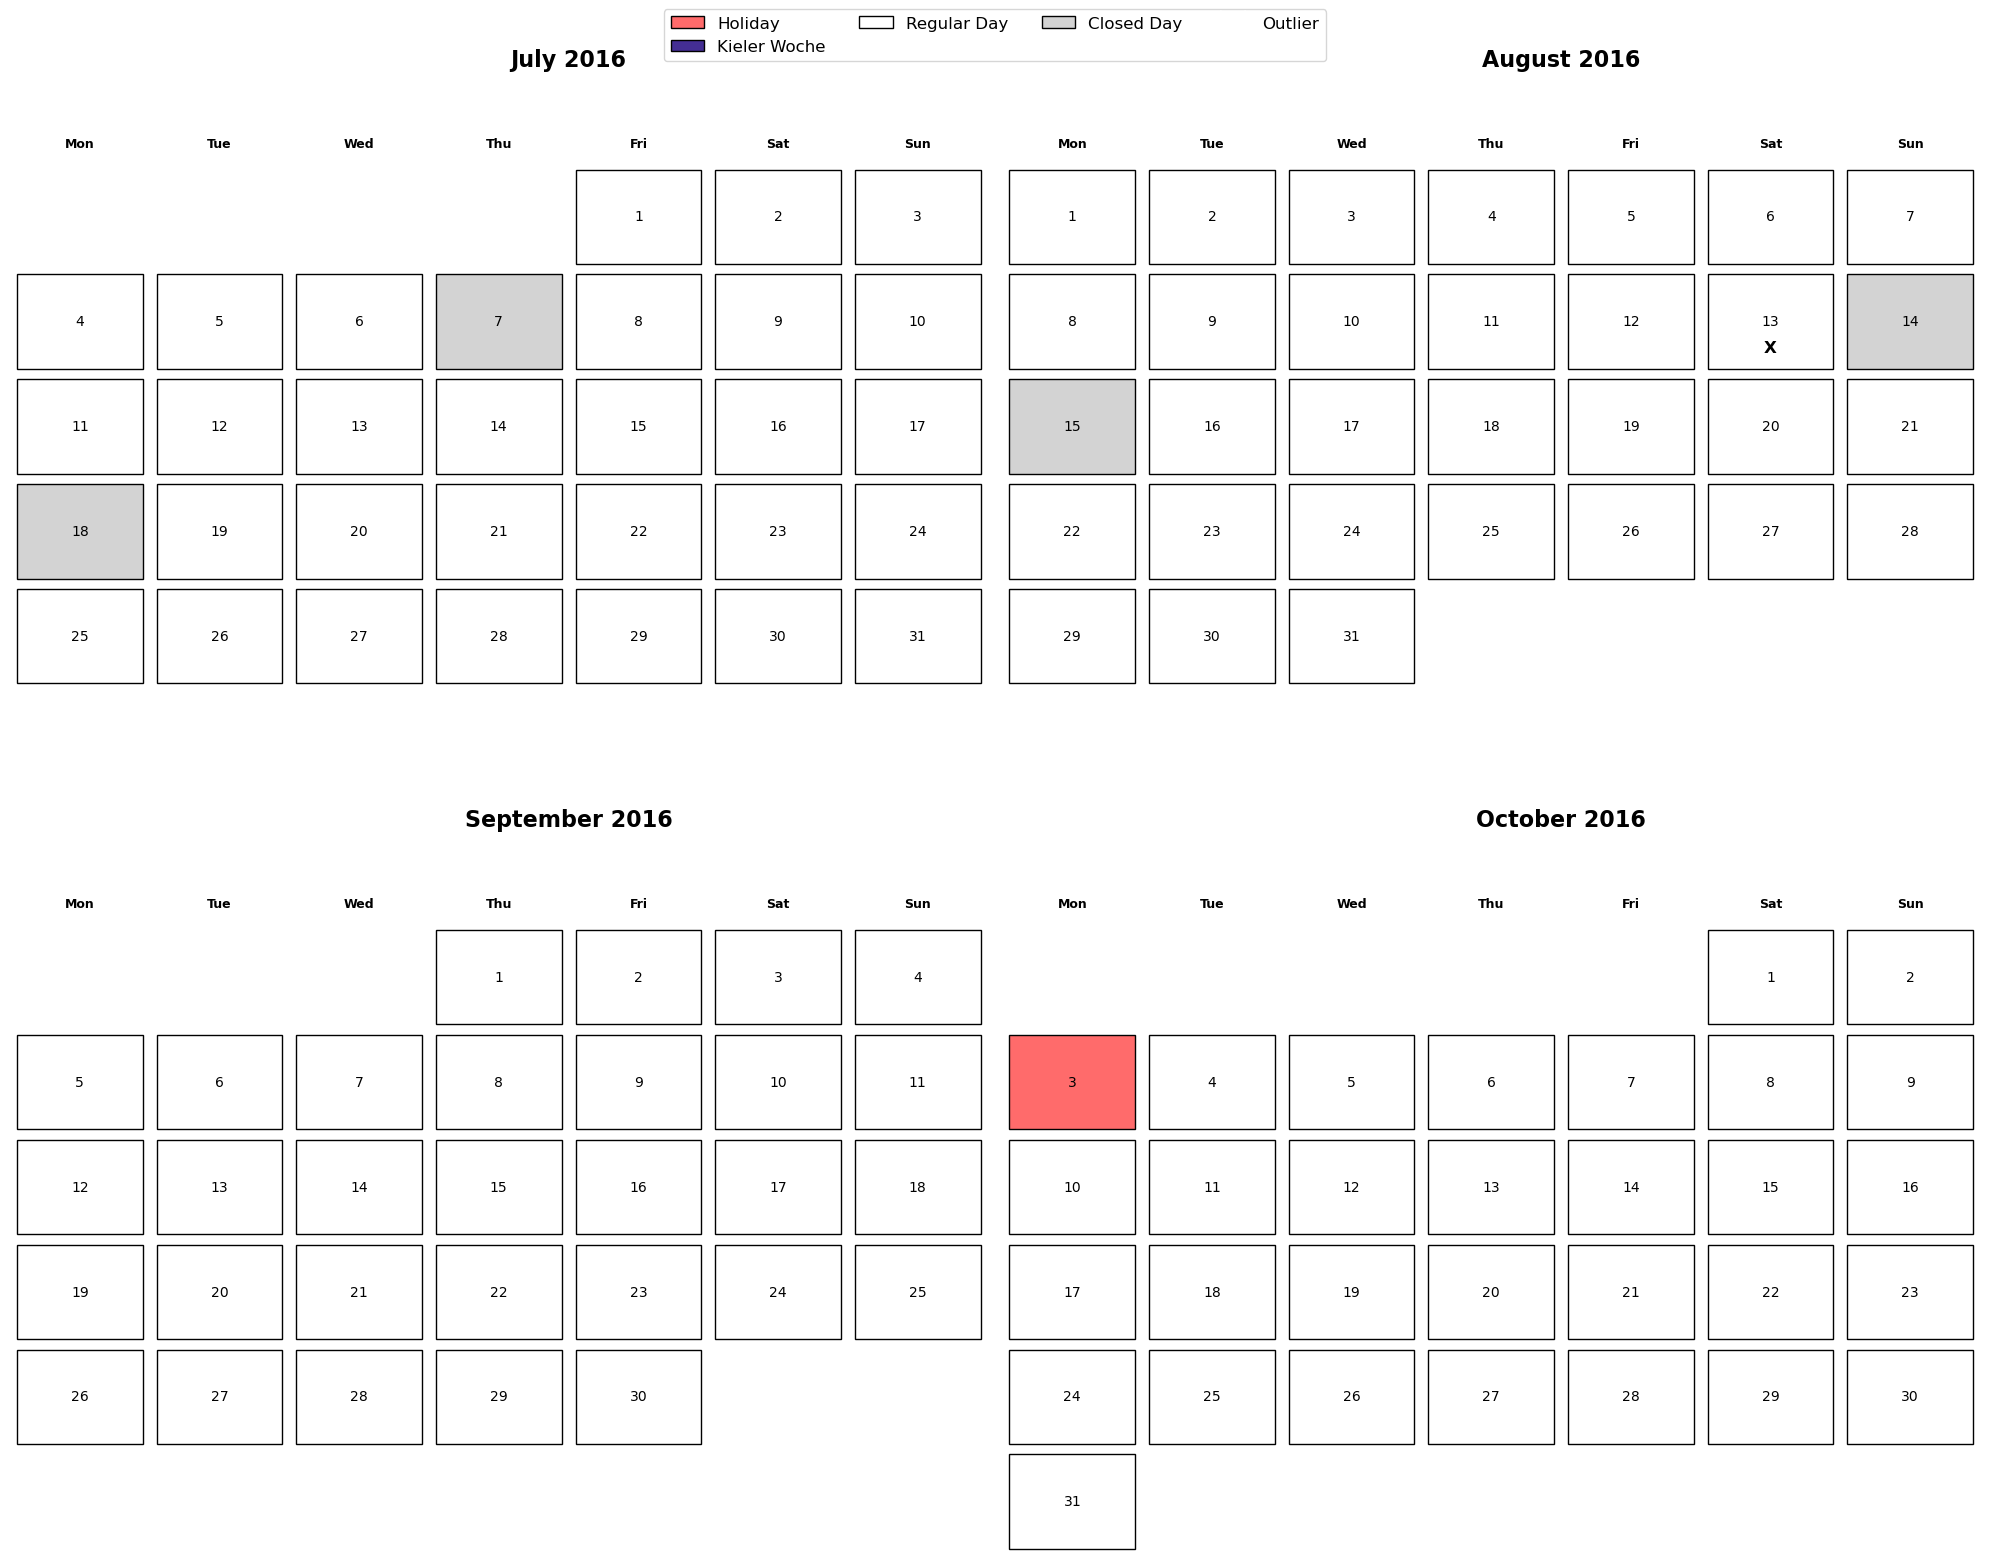

Saved calendar page 11/16


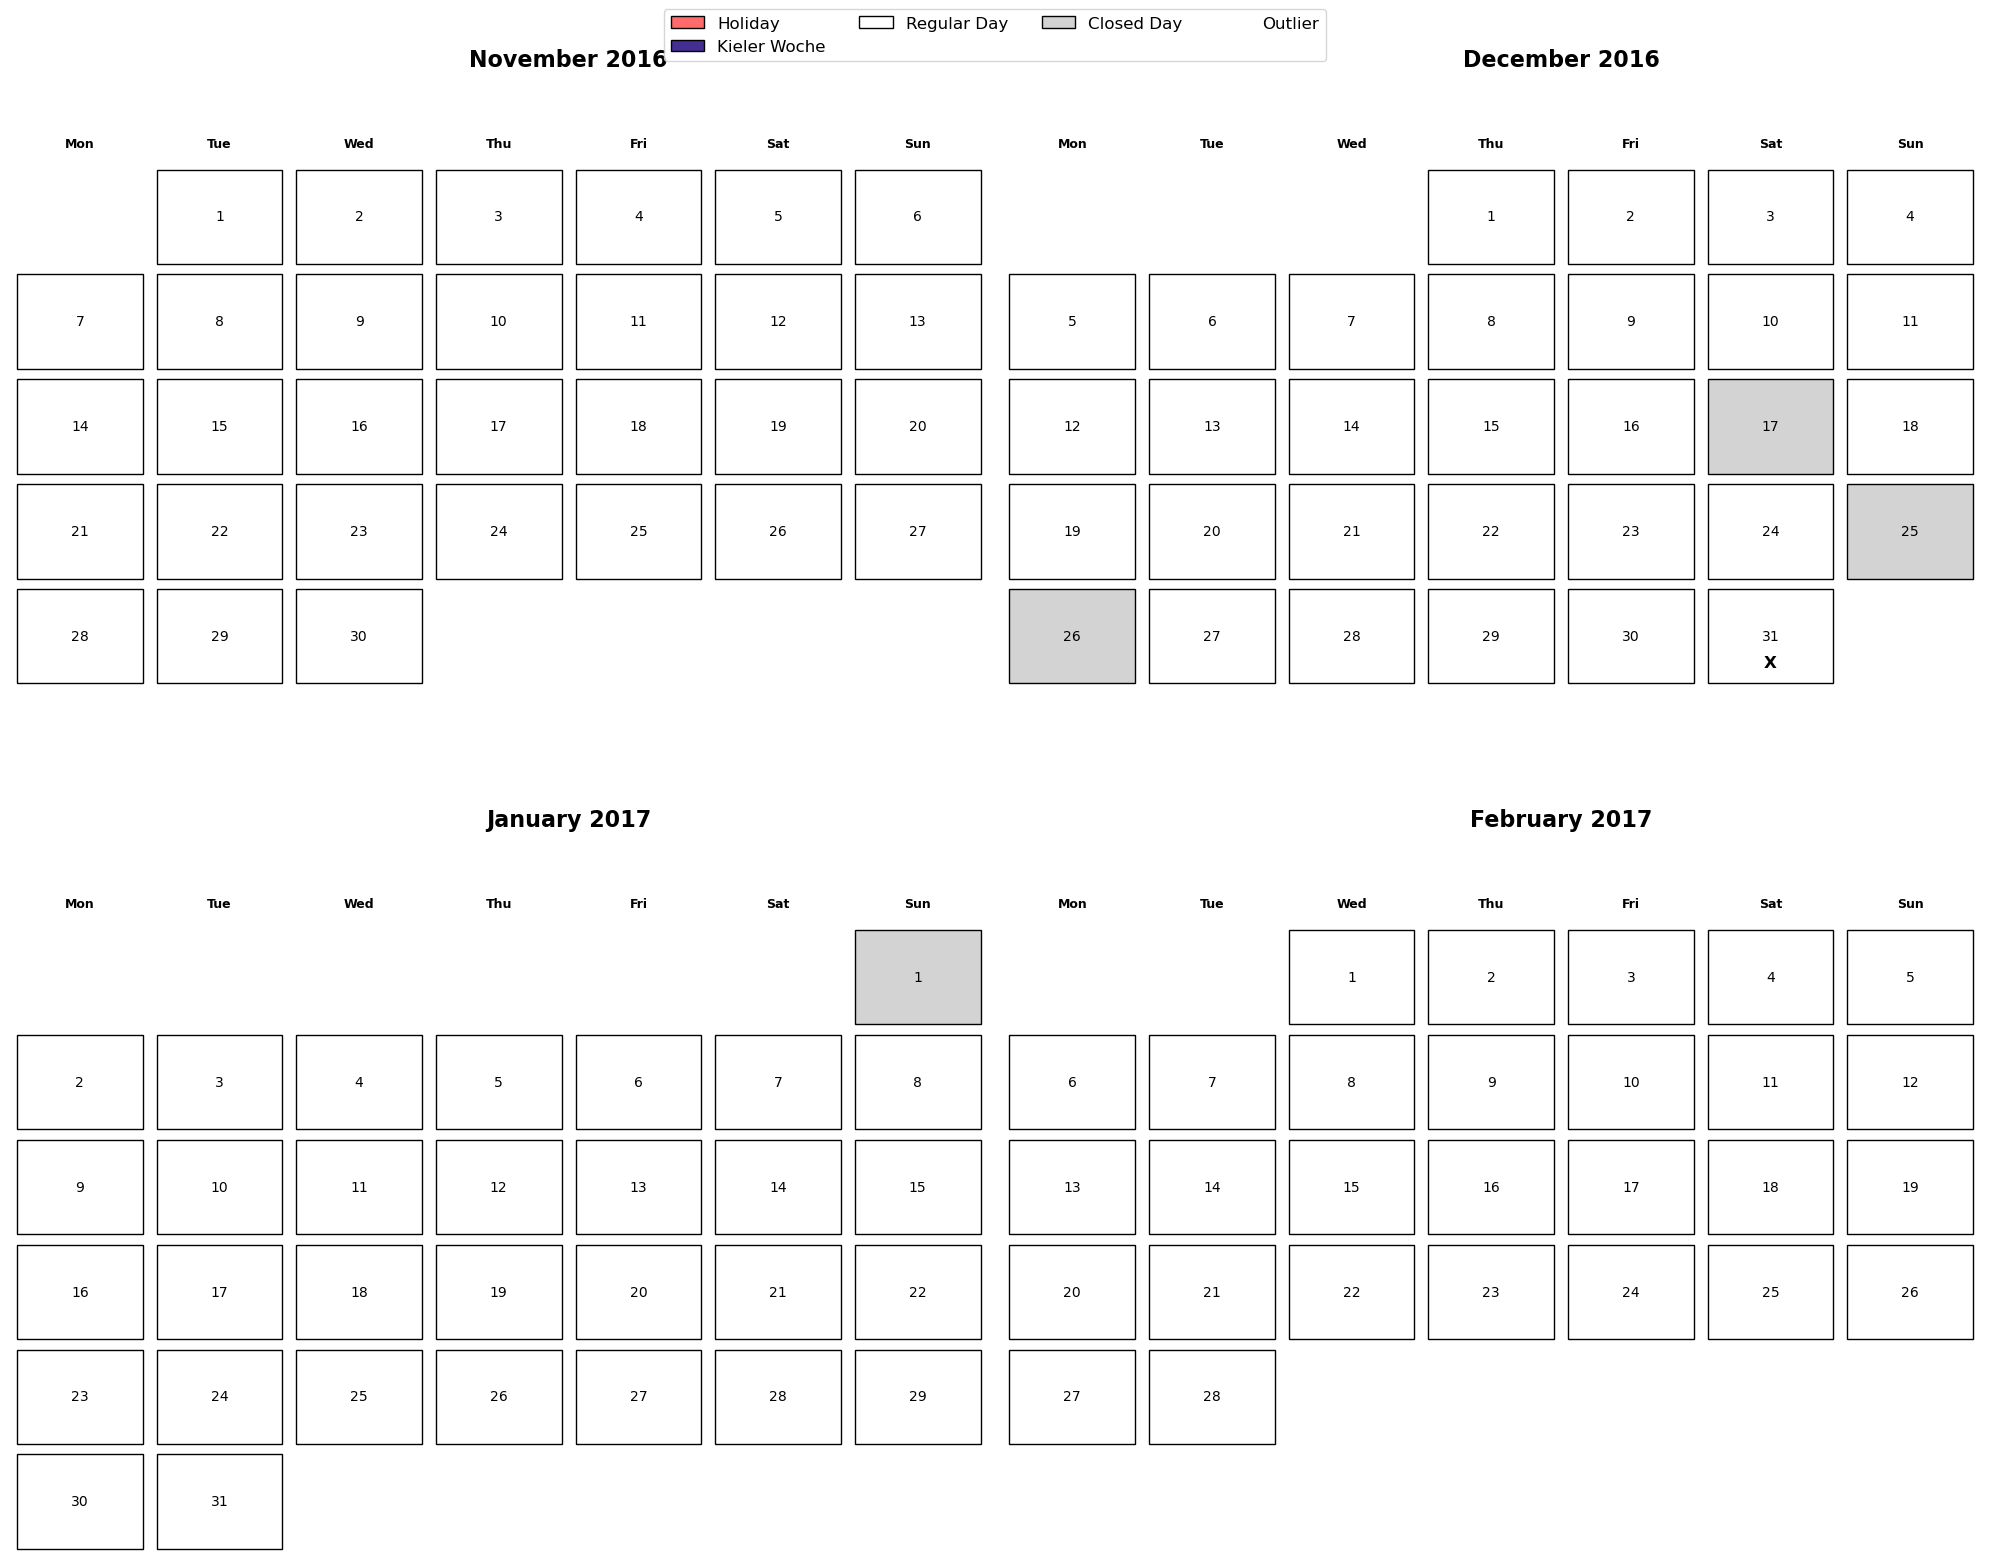

Saved calendar page 12/16


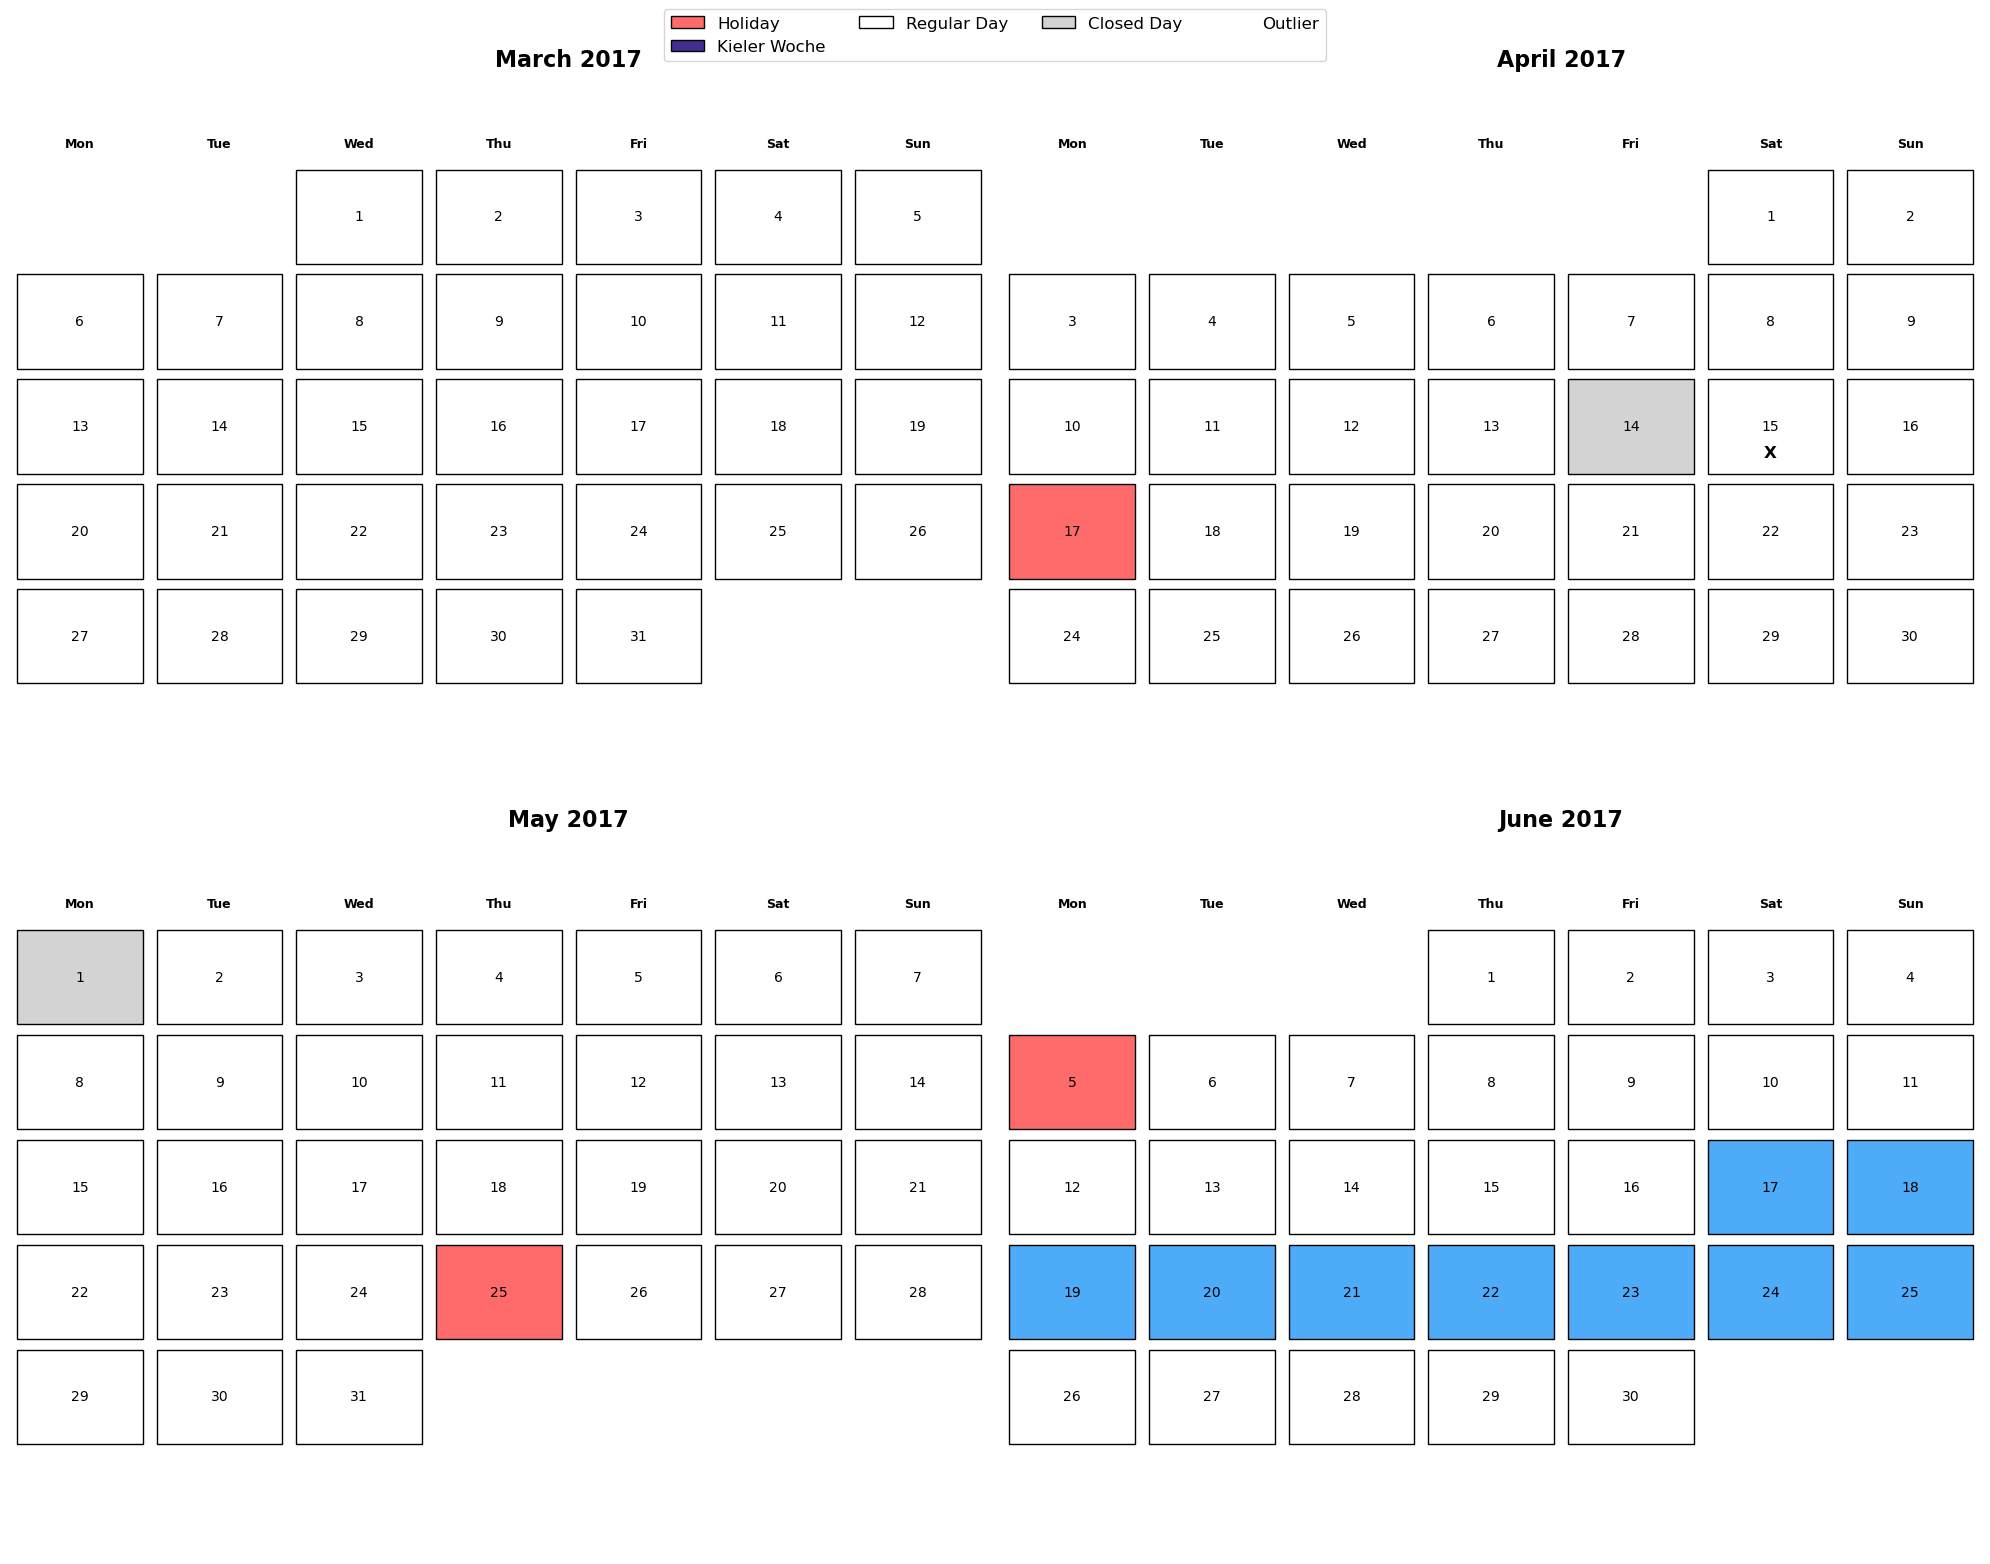

Saved calendar page 13/16


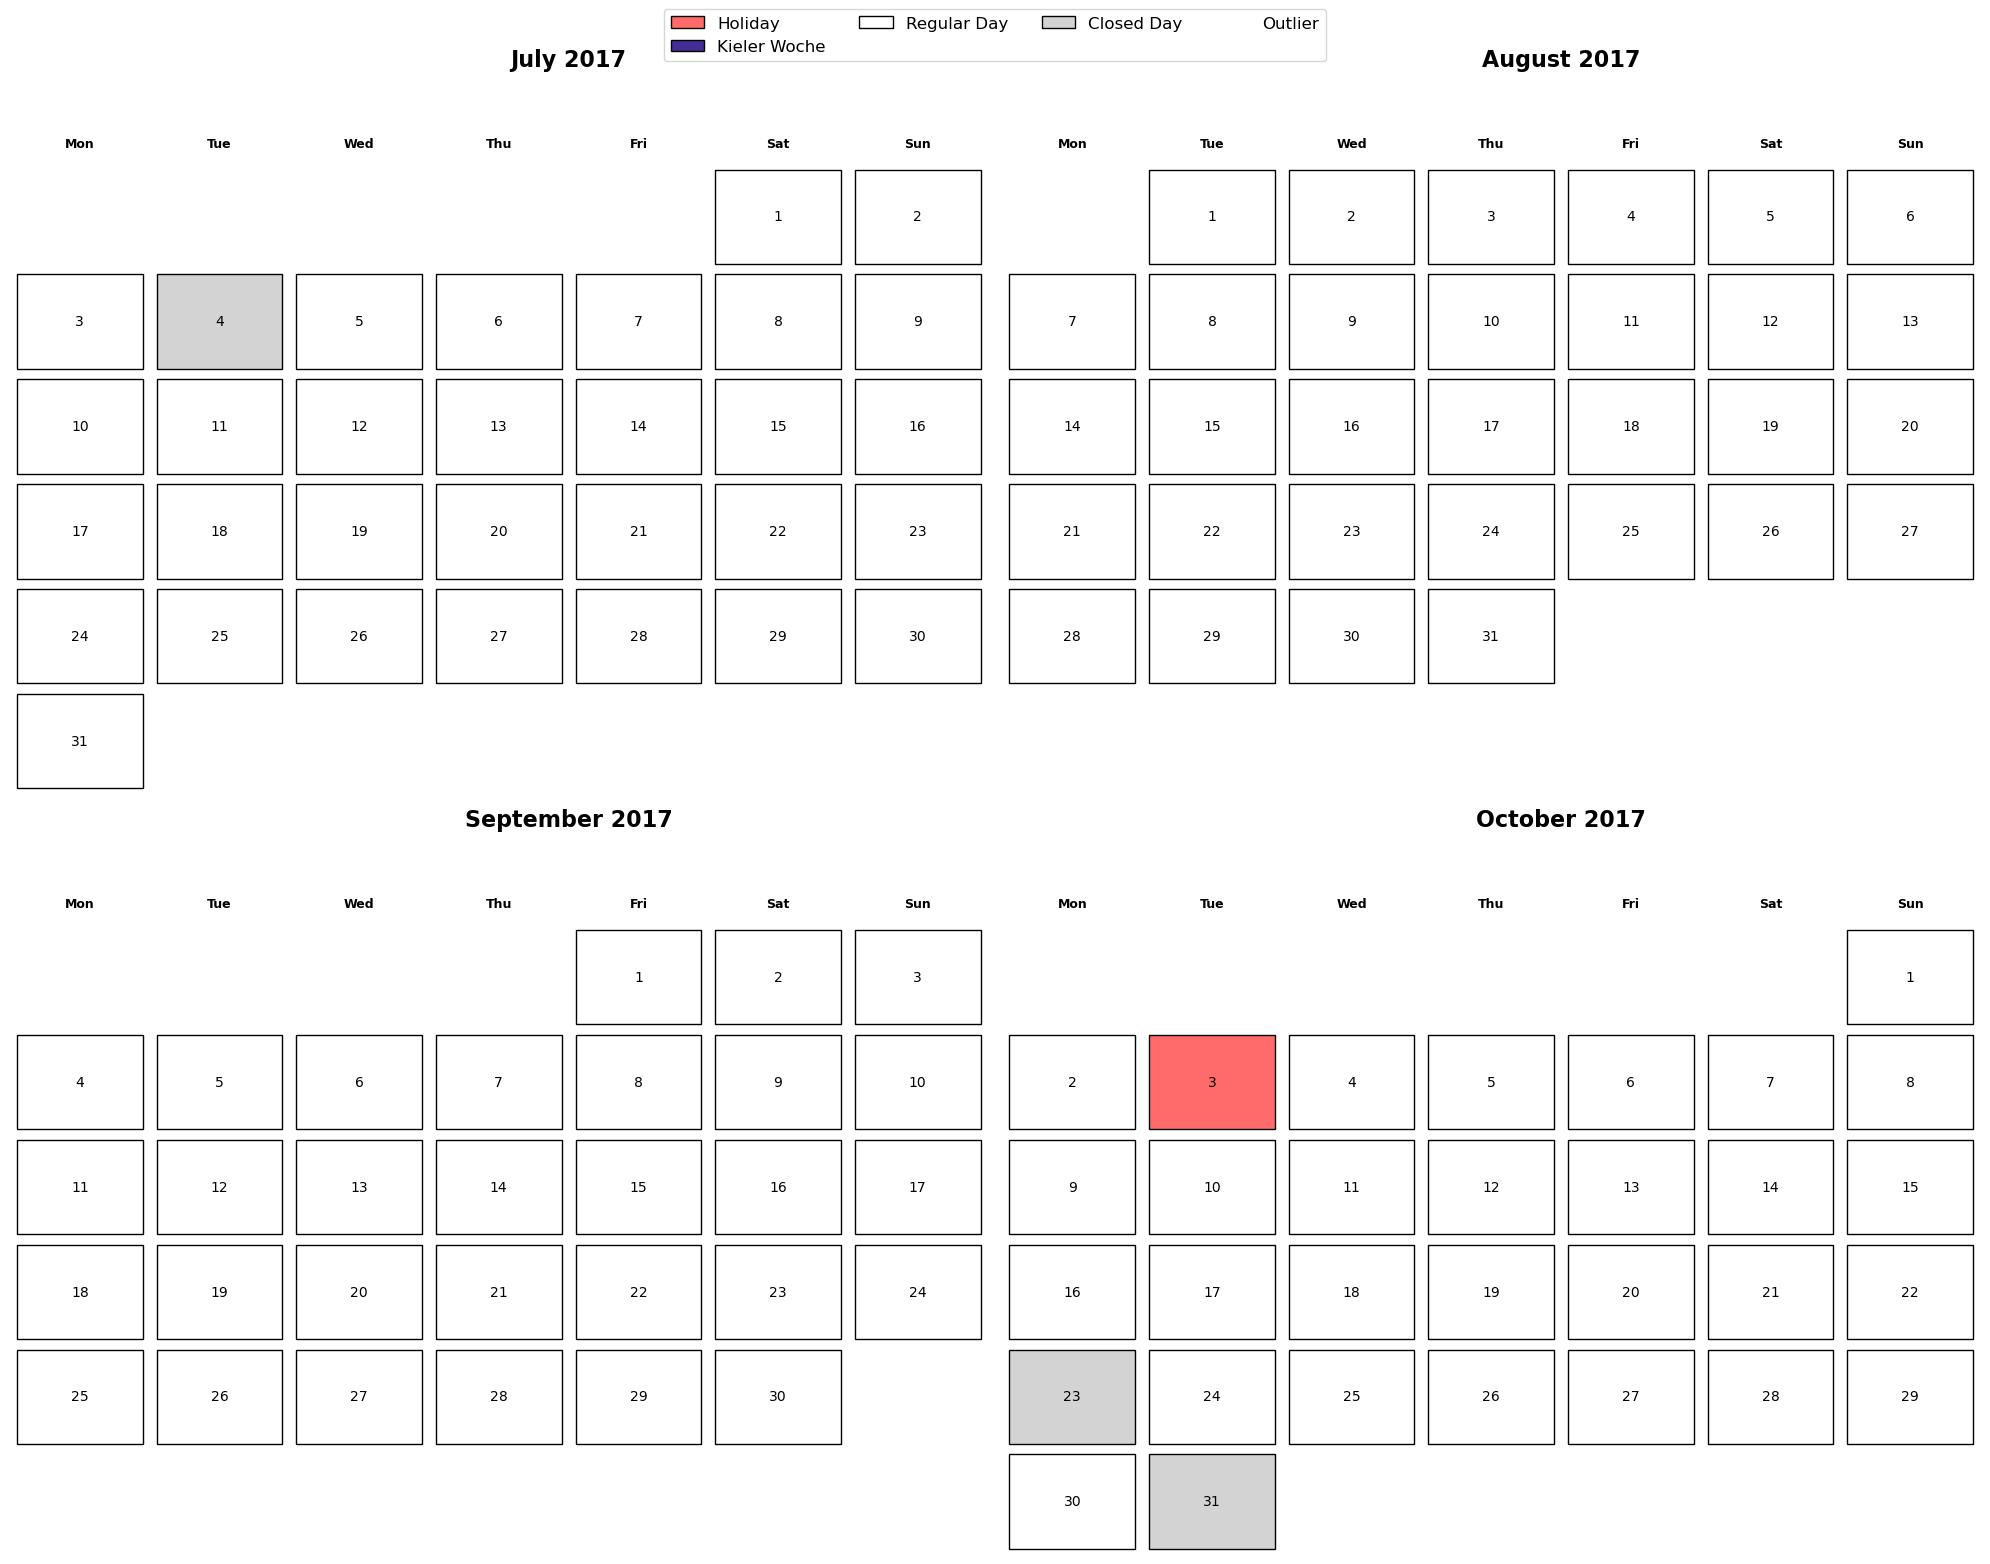

Saved calendar page 14/16


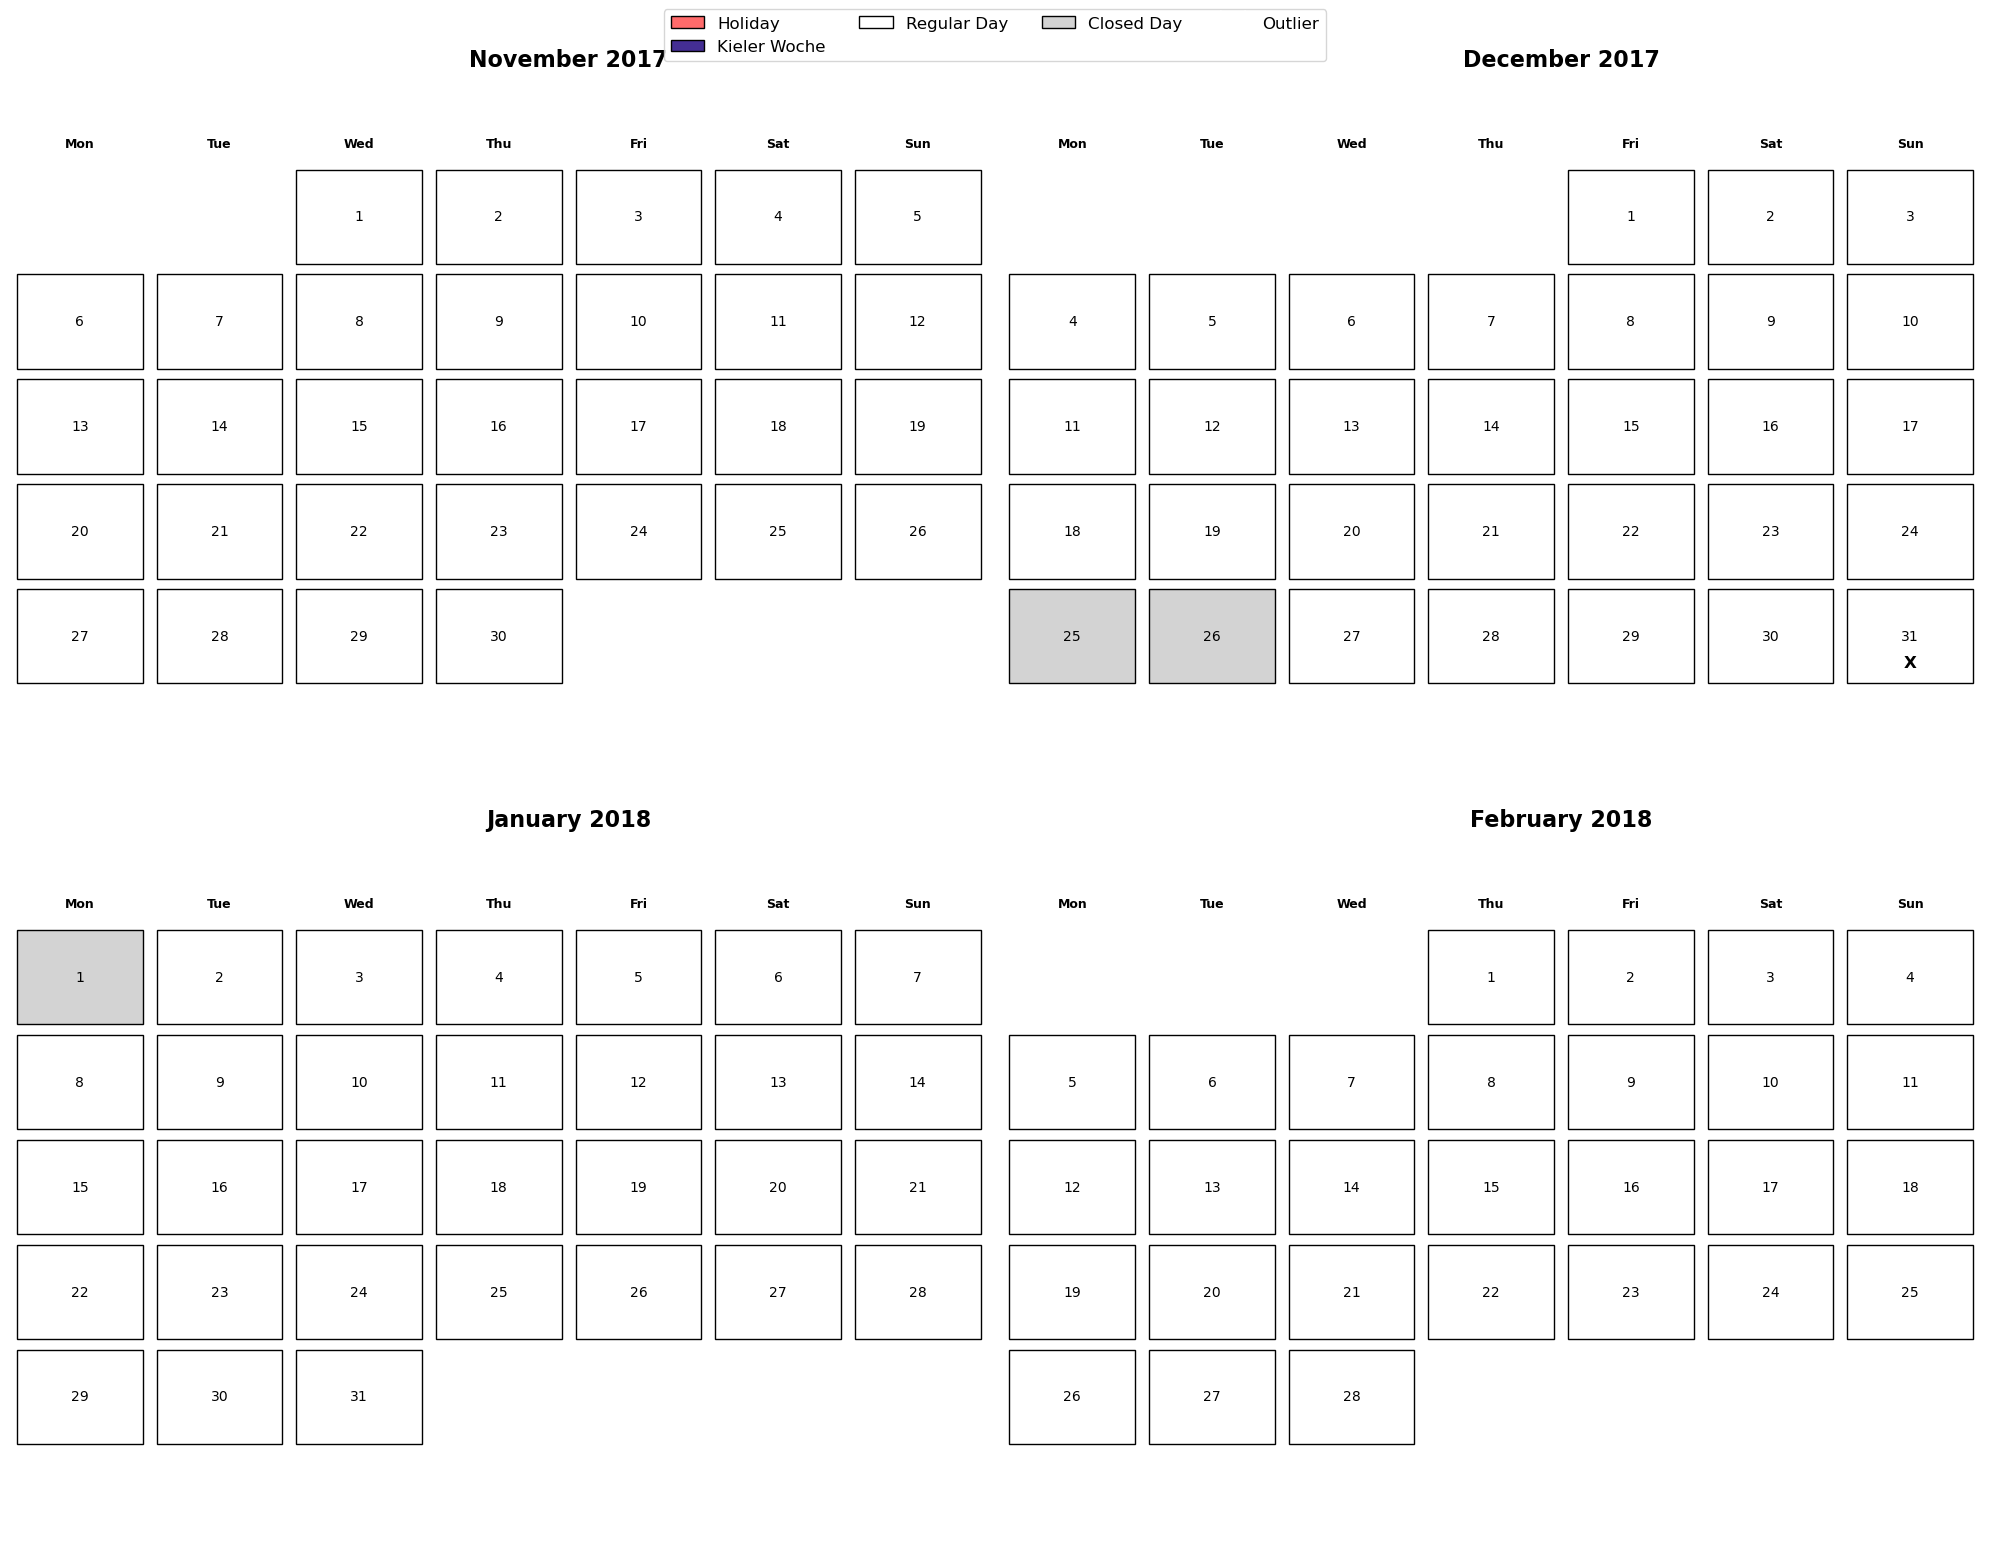

Saved calendar page 15/16


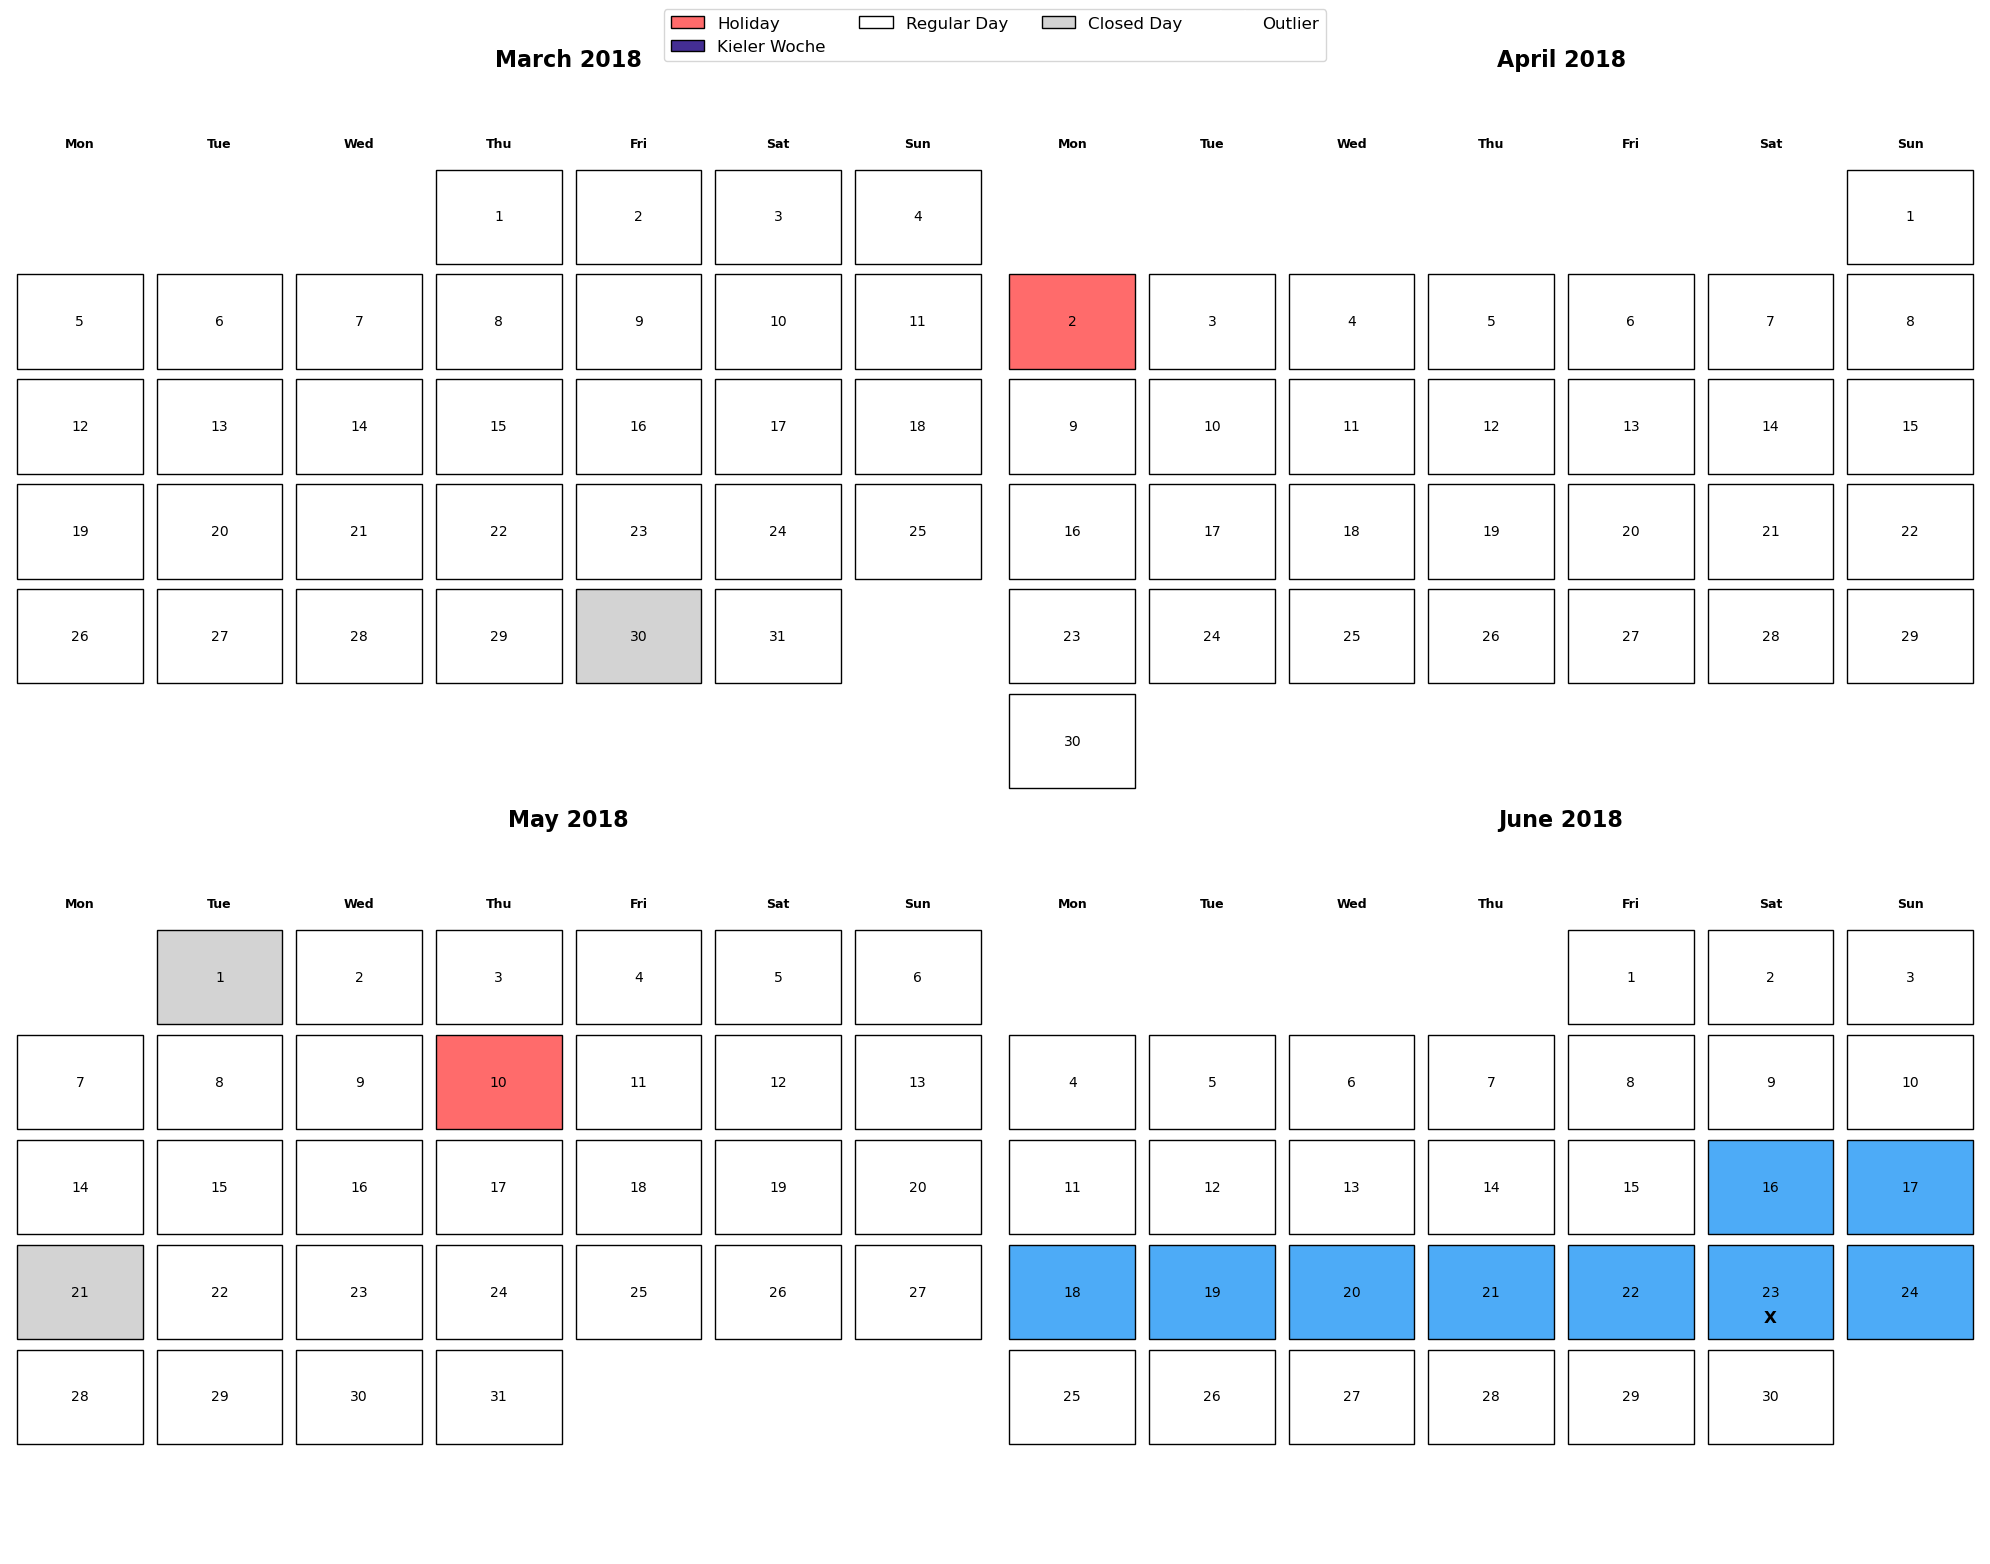

Saved calendar page 16/16


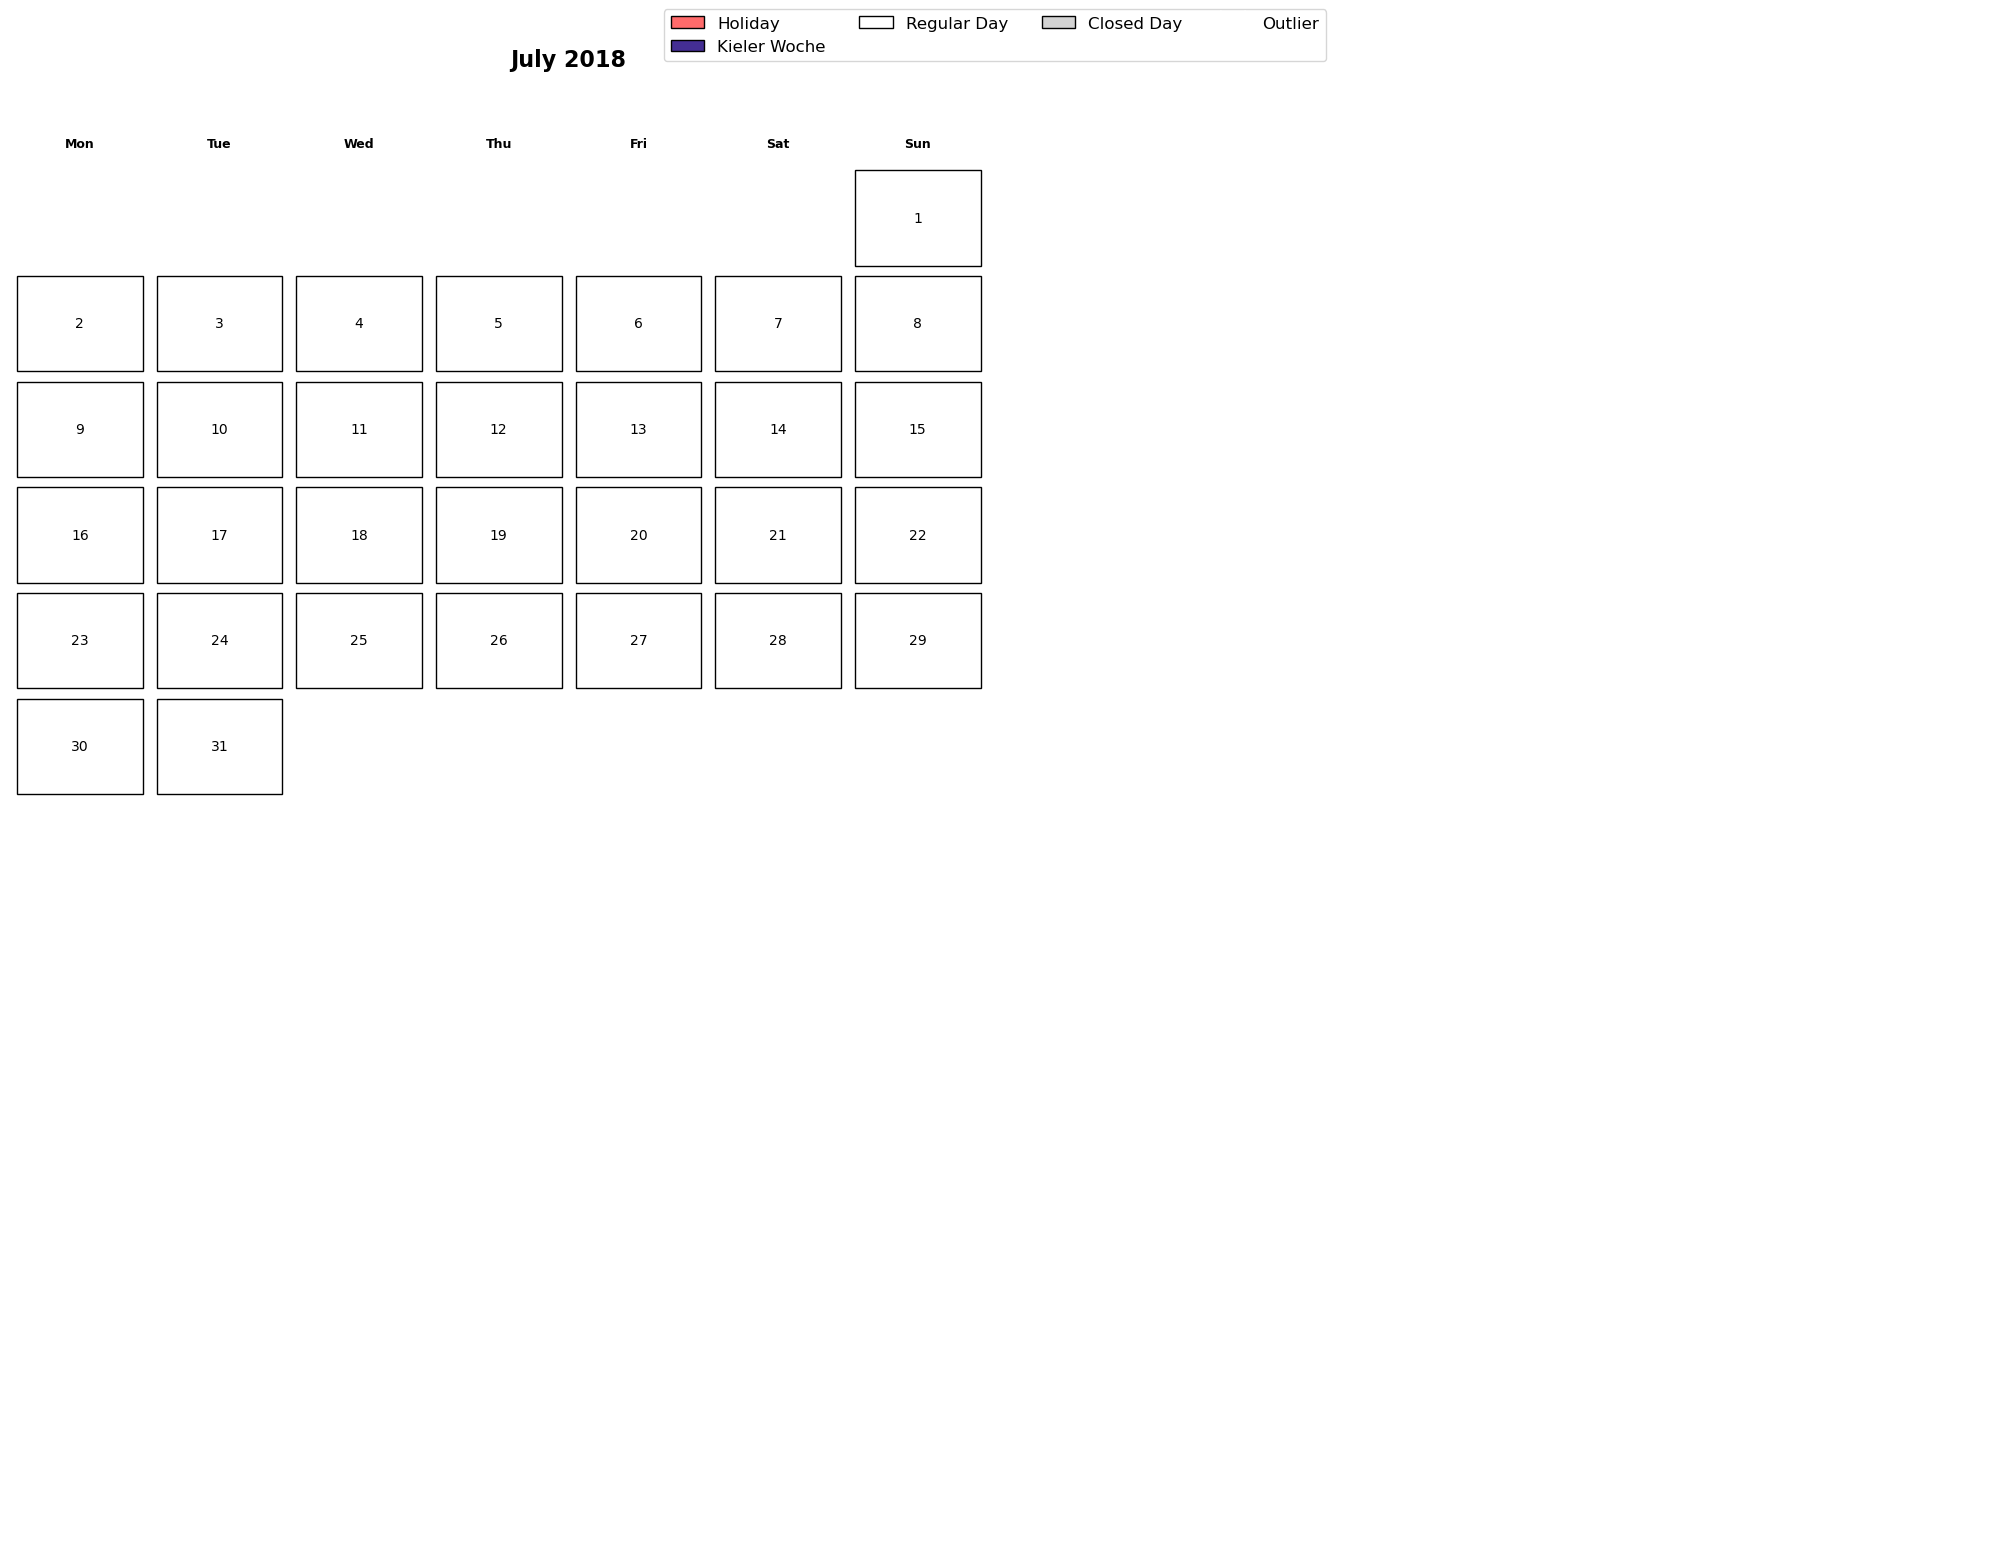


Calendar visualization complete!


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import calendar

# First, prepare the daily data with outliers
daily_sales = df.groupby('Date').agg({
    'Sales Volume': 'sum',
    'is_holiday': 'max',
    'KielerWoche': 'max',
}).reset_index()
daily_sales.rename(columns={'Sales Volume': 'Daily_Sales'}, inplace=True)

# Add is_closed column if it exists in the original dataframe
if 'is_closed' in df.columns:
    daily_sales_with_closed = df.groupby('Date').agg({
        'Sales Volume': 'sum',
        'is_holiday': 'max',
        'KielerWoche': 'max',
        'is_closed': 'max'
    }).reset_index()
    daily_sales = daily_sales_with_closed
    print("is_closed column found and added to daily_sales!")
else:
    daily_sales['is_closed'] = 0
    print("Warning: is_closed column not found, assuming all days are open")

daily_sales.rename(columns={'Sales Volume': 'Daily_Sales'}, inplace=True)


# Detect outliers using IQR method
Q1 = daily_sales['Daily_Sales'].quantile(0.25)
Q3 = daily_sales['Daily_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_sales['is_outlier'] = (
    (daily_sales['Daily_Sales'] < lower_bound) | 
    (daily_sales['Daily_Sales'] > upper_bound)
)

# Get date range
start_date = daily_sales['Date'].min()
end_date = daily_sales['Date'].max()

print(f"Creating calendar from {start_date} to {end_date}")
print(f"Holidays: {daily_sales['is_holiday'].sum()} days")
print(f"Kieler Woche: {daily_sales['KielerWoche'].sum()} days")
print(f"Closed days: {daily_sales['is_closed'].sum()} days")
print(f"Outliers: {daily_sales['is_outlier'].sum()} days")

# Function to draw calendar
def draw_calendar_with_events(daily_data, year, month):
    """Draw a single month calendar with events marked"""
    
    # Get calendar for the month
    cal = calendar.monthcalendar(year, month)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Month name
    month_name = calendar.month_name[month]
    ax.text(3.5, 6.5, f"{month_name} {year}", 
            ha='center', va='center', fontsize=20, fontweight='bold')
    
    # Day names
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        ax.text(i, 5.7, day, ha='center', va='center', 
                fontsize=10, fontweight='bold')
    
    # Draw grid and dates
    for week_num, week in enumerate(cal):
        for day_num, day in enumerate(week):
            if day == 0:
                continue
            
            # Create date
            date = pd.Timestamp(year=year, month=month, day=day)
            
            # Get data for this date
            day_data = daily_data[daily_data['Date'] == date]
            
            # Determine color
            if len(day_data) > 0:
                is_kiwo = day_data['KielerWoche'].values[0] == 1
                is_holiday = day_data['is_holiday'].values[0] == 1
                is_outlier = day_data['is_outlier'].values[0]
                is_closed = day_data['is_closed'].values[0] == 1

                
                # Priority: Holiday > Kiwo > Normal
                if is_holiday:
                    color = '#ff6b6b'  # Red
                elif is_kiwo:
                    color = '#4dabf7'  # Blue
                else:
                    color = 'white'
            else:
                color = 'white'
            
            # Draw cell
            y_pos = 5 - week_num
            rect = Rectangle((day_num - 0.45, y_pos - 0.45), 0.9, 0.9, 
                           facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            
            # Add day number
            ax.text(day_num, y_pos, str(day), 
                   ha='center', va='center', fontsize=12)
            
            # Mark outliers with X
            if len(day_data) > 0 and is_outlier:
                ax.text(day_num, y_pos - 0.25, 'X', 
                       ha='center', va='center', fontsize=14, 
                       fontweight='bold', color='black')
    
    # Set limits and remove axes
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 6.5)
    ax.axis('off')
    
    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor='#ff6b6b', edgecolor='black', label='Holiday'),
        mpatches.Patch(facecolor='#4dabf7', edgecolor='black', label='Kieler Woche'),
        mpatches.Patch(facecolor='white', edgecolor='black', label='Regular Day'),
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='black', 
                  markersize=10, label='Outlier', linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc='upper right', 
             bbox_to_anchor=(1.15, 1), fontsize=10)
    
    return fig

# Generate calendars for all months in the date range
start_year = start_date.year
start_month = start_date.month
end_year = end_date.year
end_month = end_date.month

# Create a list of (year, month) tuples
months_to_plot = []
current_year = start_year
current_month = start_month

while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
    months_to_plot.append((current_year, current_month))
    current_month += 1
    if current_month > 12:
        current_month = 1
        current_year += 1

print(f"\nGenerating {len(months_to_plot)} calendar months...")

# Create multi-page calendar (4 months per page)
months_per_page = 4
num_pages = (len(months_to_plot) + months_per_page - 1) // months_per_page

for page in range(num_pages):
    start_idx = page * months_per_page
    end_idx = min(start_idx + months_per_page, len(months_to_plot))
    months_on_page = months_to_plot[start_idx:end_idx]
    
    # Create figure with subplots
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.flatten()
    
    for idx, (year, month) in enumerate(months_on_page):
        ax = axes[idx]
        
        # Get calendar for the month
        cal = calendar.monthcalendar(year, month)
        
        # Month name
        month_name = calendar.month_name[month]
        ax.text(3.5, 6.5, f"{month_name} {year}", 
                ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Day names
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        for i, day in enumerate(days):
            ax.text(i, 5.7, day, ha='center', va='center', 
                    fontsize=9, fontweight='bold')
        
        # Draw grid and dates
        for week_num, week in enumerate(cal):
            for day_num, day in enumerate(week):
                if day == 0:
                    continue
                
                # Create date
                date = pd.Timestamp(year=year, month=month, day=day)
                
                # Get data for this date
                day_data = daily_sales[daily_sales['Date'] == date]
                
                # Determine color
                if len(day_data) > 0:
                    is_kiwo = day_data['KielerWoche'].values[0] == 1
                    is_holiday = day_data['is_holiday'].values[0] == 1
                    is_outlier = day_data['is_outlier'].values[0]
                    
                    # Priority: Holiday > Kiwo > Normal
                    if is_holiday:
                        color = '#ff6b6b'  # Red
                    elif is_kiwo:
                        color = '#4dabf7'  # Blue
                    else:
                        color = 'white'
                else:
                    color = 'lightgray'  # Outside data range
                
                # Draw cell
                y_pos = 5 - week_num
                rect = Rectangle((day_num - 0.45, y_pos - 0.45), 0.9, 0.9, 
                               facecolor=color, edgecolor='black', linewidth=1)
                ax.add_patch(rect)
                
                # Add day number
                ax.text(day_num, y_pos, str(day), 
                       ha='center', va='center', fontsize=10)
                
                # Mark outliers with X
                if len(day_data) > 0 and is_outlier:
                    ax.text(day_num, y_pos - 0.25, 'X', 
                           ha='center', va='center', fontsize=12, 
                           fontweight='bold', color='black')
        
        # Set limits and remove axes
        ax.set_xlim(-0.5, 6.5)
        ax.set_ylim(-0.5, 6.5)
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(months_on_page), len(axes)):
        axes[idx].axis('off')
    
    # Add legend to the figure
    legend_elements = [
        mpatches.Patch(facecolor='#ff6b6b', edgecolor='black', label='Holiday'),
        mpatches.Patch(facecolor="#442E94", edgecolor='black', label='Kieler Woche'),
        mpatches.Patch(facecolor='white', edgecolor='black', label='Regular Day'),
        mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Closed Day'),
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='black', 
                  markersize=18, label='Outlier', linestyle='None')
    ]
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), fontsize=12, ncol=4)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'figures/calendar_page_{page+1}.png', dpi=300, bbox_inches='tight')
    print(f"Saved calendar page {page+1}/{num_pages}")
    plt.show()

print("\nCalendar visualization complete!")


In [28]:
# Check date range in your data
print(f"First date in data: {daily_sales['Date'].min()}")
print(f"Last date in data: {daily_sales['Date'].max()}")
print(f"Total days in data: {len(daily_sales)}")

# Check for missing dates in the range
date_range = pd.date_range(start=daily_sales['Date'].min(), 
                           end=daily_sales['Date'].max(), 
                           freq='D')
missing_dates = set(date_range) - set(daily_sales['Date'])
print(f"\nMissing dates in range: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("First few missing dates:")
    for date in sorted(missing_dates)[:10]:
        print(f"  {date.date()}")

First date in data: 2013-07-01 00:00:00
Last date in data: 2018-07-31 00:00:00
Total days in data: 1819

Missing dates in range: 38
First few missing dates:
  2013-12-25
  2013-12-26
  2013-12-28
  2014-01-01
  2014-04-18
  2014-05-01
  2014-05-03
  2014-05-04
  2014-08-17
  2014-12-25


Total missing dates: 38

=== RECURRING MISSING DATES (Same date missing in multiple years) ===

month_day  years_count                     years_list example_date
    01-01            5 [2014, 2015, 2016, 2017, 2018]   2014-01-01
    12-26            5 [2013, 2014, 2015, 2016, 2017]   2013-12-26
    12-25            5 [2013, 2014, 2015, 2016, 2017]   2013-12-25
    05-01            4       [2014, 2015, 2017, 2018]   2014-05-01


=== DETAILED VIEW: Dates missing in ALL or MOST years ===

Total years in dataset: 6
January 1 (01-01): Missing in 5/6 years
  Years: [2014, 2015, 2016, 2017, 2018]

December 26 (12-26): Missing in 5/6 years
  Years: [2013, 2014, 2015, 2016, 2017]

December 25 (12-25): Missing in 5/6 years
  Years: [2013, 2014, 2015, 2016, 2017]



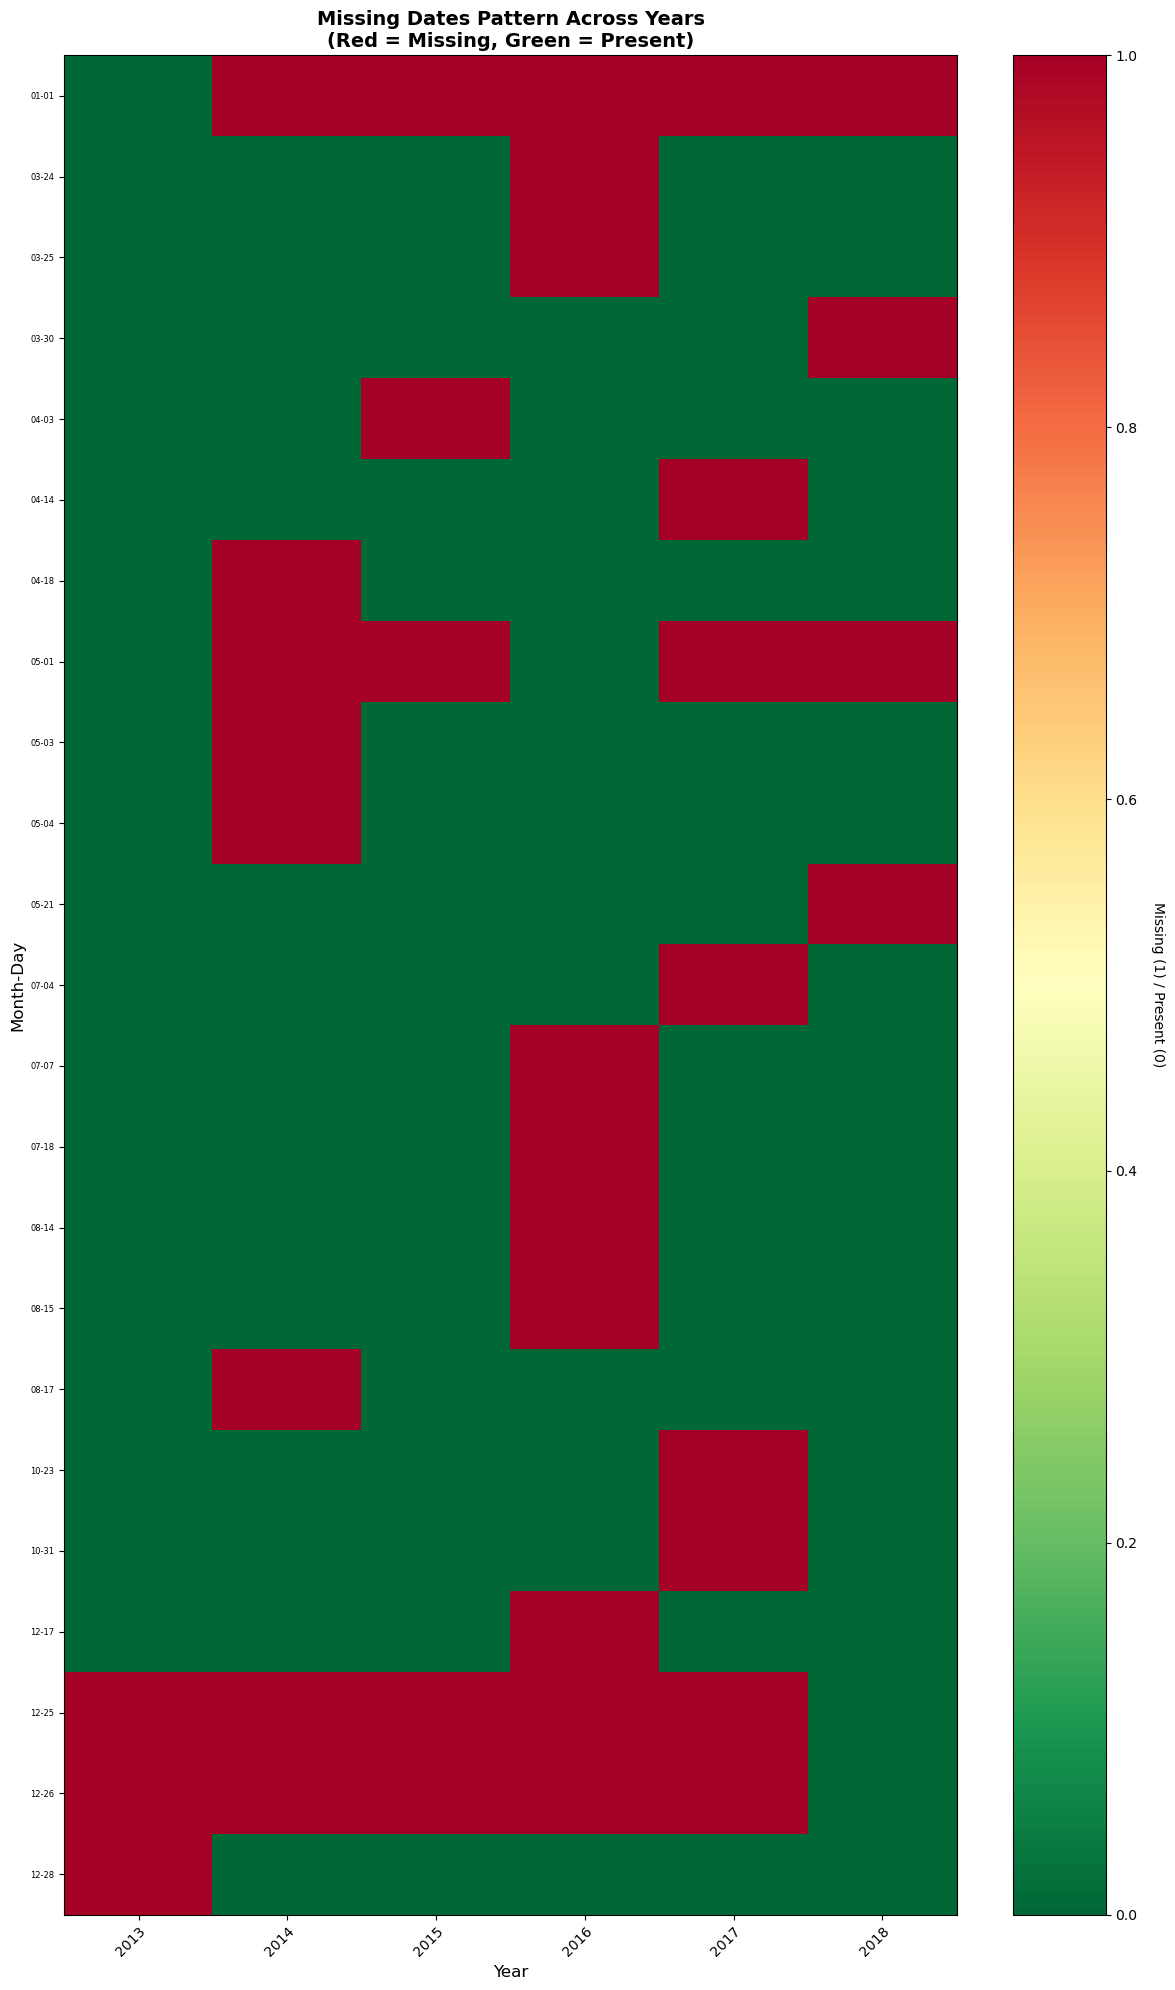


=== SUMMARY STATISTICS ===

Total missing dates: 38
Dates missing in ALL years: 0
Dates missing in MOST years (≥5): 3


Missing dates by month:
  Jan: 5 days
  Mar: 3 days
  Apr: 3 days
  May: 7 days
  Jul: 3 days
  Aug: 3 days
  Oct: 2 days
  Dec: 12 days


In [29]:
import pandas as pd

# Check for missing dates
date_range_full = pd.date_range(start=daily_sales['Date'].min(), 
                                end=daily_sales['Date'].max(), 
                                freq='D')
missing_dates = set(date_range_full) - set(daily_sales['Date'])
missing_df = pd.DataFrame({'Date': sorted(missing_dates)})
missing_df['Date'] = pd.to_datetime(missing_df['Date'])

print(f"Total missing dates: {len(missing_dates)}")

# Extract month and day for pattern detection
missing_df['month'] = missing_df['Date'].dt.month
missing_df['day'] = missing_df['Date'].dt.day
missing_df['month_day'] = missing_df['Date'].dt.strftime('%m-%d')
missing_df['year'] = missing_df['Date'].dt.year

# Find recurring missing dates (same month-day across multiple years)
recurring_pattern = missing_df.groupby('month_day').agg({
    'year': ['count', lambda x: sorted(list(x))],
    'Date': 'first'
}).reset_index()
recurring_pattern.columns = ['month_day', 'years_count', 'years_list', 'example_date']

# Sort by frequency
recurring_pattern = recurring_pattern.sort_values('years_count', ascending=False)

print("\n=== RECURRING MISSING DATES (Same date missing in multiple years) ===\n")
print(recurring_pattern[recurring_pattern['years_count'] > 1].to_string(index=False))

# More detailed view
print("\n\n=== DETAILED VIEW: Dates missing in ALL or MOST years ===\n")

# Calculate how many years we have data for
total_years = daily_sales['Date'].dt.year.nunique()
print(f"Total years in dataset: {total_years}")

# Find dates missing in all years
for _, row in recurring_pattern.iterrows():
    if row['years_count'] >= total_years - 1:  # Missing in all or all-but-one years
        example = pd.to_datetime(row['example_date'])
        month_name = example.strftime('%B')
        day_num = example.day
        print(f"{month_name} {day_num} ({row['month_day']}): Missing in {row['years_count']}/{total_years} years")
        print(f"  Years: {row['years_list']}")
        print()

# Visualize missing dates pattern
import matplotlib.pyplot as plt
import numpy as np

# Create a heatmap of missing dates by month-day
missing_df['day_of_year'] = missing_df['Date'].dt.dayofyear
missing_by_year = missing_df.pivot_table(
    index='month_day', 
    columns='year', 
    values='day_of_year',
    aggfunc='count',
    fill_value=0
)

# Convert to binary (missing=1, present=0)
missing_by_year = (missing_by_year > 0).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(12, 20))

# Create heatmap
im = ax.imshow(missing_by_year.values, cmap='RdYlGn_r', aspect='auto')

# Set ticks
ax.set_xticks(np.arange(len(missing_by_year.columns)))
ax.set_yticks(np.arange(len(missing_by_year.index)))
ax.set_xticklabels(missing_by_year.columns)
ax.set_yticklabels(missing_by_year.index, fontsize=6)

# Labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Month-Day', fontsize=12)
ax.set_title('Missing Dates Pattern Across Years\n(Red = Missing, Green = Present)', 
             fontsize=14, fontweight='bold')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Missing (1) / Present (0)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('figures/missing_dates_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n=== SUMMARY STATISTICS ===\n")
print(f"Total missing dates: {len(missing_dates)}")
print(f"Dates missing in ALL years: {(recurring_pattern['years_count'] == total_years).sum()}")
print(f"Dates missing in MOST years (≥{total_years-1}): {(recurring_pattern['years_count'] >= total_years-1).sum()}")

# Month-by-month breakdown
print("\n\nMissing dates by month:")
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
missing_by_month = missing_df['month'].value_counts().sort_index()
for month, count in missing_by_month.items():
    print(f"  {month_names[month]}: {count} days")
